# PROJET 5 : CREATION DE TAGG POUR LES QUESTIONS DE STAKEOVERFLOW

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## PARTIE 1 : récupérer les données

https://data.stackexchange.com/stackoverflow/query/edit/1485025

Récupération des questions :

- SELECT Id, OwnerUserId, CreationDate, ClosedDate, Score, Title, Body FROM posts 
- WHERE Id < 50000 
- AND OwnerUserId is not Null 
- AND Score > 0 
- AND Title is not Null
- AND AnswerCount > 0
- AND FAvoriteCount > 0

Récupération des Tags 

- SELECT PostId, TagName 
- FROM  PostTags left join Tags on TagId = Tags.Id 
- WHERE PostId < 50000

Nous récupérons les questions et les tags dans deux csv différents de façon à alléger la requête

azur / https://www.heroku.com/


In [2]:
#!pip install nltk
#!pip install bs4 

#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [3]:
# liste des bibliothèques utiles dans ce script
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import re 
import time
from datetime import datetime

from collections import Counter
from string import punctuation
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import nltk

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [4]:
#df = pd.read_csv('QueryResults.csv')
dfQR = pd.read_csv('questions.csv')
dfT = pd.read_csv('tags.csv')


## PARTIE 2 : EDA / Analyse exploratoire

Analyse exploratoire du fichier de questions :
Le fichier comporte 7 colonnes, comme le montre la capture des premières lignes ci-dessous : 
- nombre de Tags par questions
- Tags les plus communs

### Exploration de la table des questions et détails des questions
- on remarque que dans le corps du texte il y a des balise HTML à retirer
- la langue principale est l'anglais
- il va falloir faire attention à la ponctuation : tout retirer sauf les - les + et les # 
- le score médian d'une question est de 11 mais celui ci peut monter jusque plus de 7000

In [5]:
dfQR.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,4,8,2008-07-31 21:42:52,NaN,752,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...
1,6,9,2008-07-31 22:08:08,NaN,312,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...
2,9,1,2008-07-31 23:40:59,NaN,2083,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...
3,11,1,2008-07-31 23:55:37,NaN,1599,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...
4,13,9,2008-08-01 00:42:38,NaN,667,Determine a user's timezone,<p>Is there a standard way for a web server to...


In [6]:
dfQR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            5031 non-null   int64 
 1   OwnerUserId   5031 non-null   int64 
 2   CreationDate  5031 non-null   object
 3   ClosedDate    704 non-null    object
 4   Score         5031 non-null   int64 
 5   Title         5031 non-null   object
 6   Body          5031 non-null   object
dtypes: int64(3), object(4)
memory usage: 275.3+ KB


In [7]:
dfQR[['Score']].describe()

,Score
count,5031.000000
mean,70.814550
std,315.624477
min,1.000000
25%,4.500000
50%,11.000000
75%,33.000000
max,7318.000000


### Affichage des Tags les plus courants

- présence de quelques lignes avec des Tags 'NULL' à retirer
- les tags les plus courants sont C# et .net

In [8]:
dfT.columns = ['Id', 'Tag']
dfT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15715 entries, 0 to 15714
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      15715 non-null  int64 
 1   Tag     15709 non-null  object
dtypes: int64(1), object(1)
memory usage: 245.7+ KB


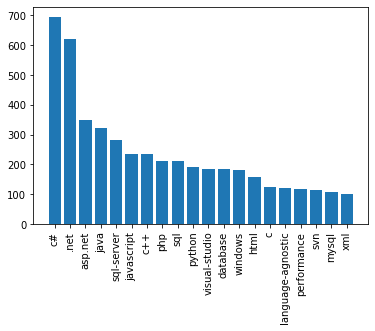

In [9]:

liste = dfT['Tag']
words = liste.values
dt = Counter(words)
dt20 = dt.most_common(20)
data = {}
for e in dt20:
    data[e[0]]=e[1]
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values, tick_label=names)
plt.xticks(rotation=90)
plt.show()
#print(Counter(words).keys())# equals to list(set(words))
#print(Counter(words).values()) # counts the elements' frequency

In [10]:
# on ne garde que les tags qui sont apparus suffisament de fois
print('number of Tags :',len(dt))
ndt = {}
lt = []
for e in dt:
    if dt[e]>10:
        ndt[e]=dt[e]
        lt.append(e)
print('new number of Tags :', len(ndt))

number of Tags : 2641
new number of Tags : 239


In [11]:
dfT['Tag'] = dfT['Tag'].astype(str)
tags = dfT.groupby(["Id"])['Tag'].apply(lambda dfT: ' '.join(dfT))
tags.columns = ['Id', 'Tag']
tags.head(10)

Id
4     c# decimal double floating-point type-conversion
6                         html internet-explorer-7 css
9                                     datetime c# .net
11        c# datetime datediff time relative-time-span
13    timezone timezone-offset user-agent browser html
14                                           math .net
16                       .net-3.5 c# linq web-services
17             mysql binary-data data-storage database
19     algorithm performance pi language-agnostic unix
24                             triggers mysql database
Name: Tag, dtype: object

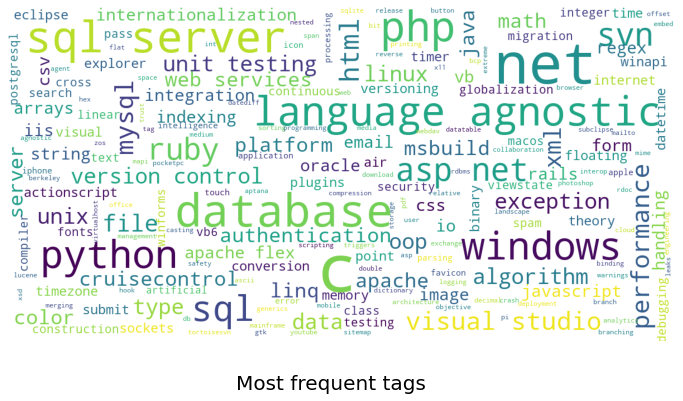

In [12]:
sw_stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=sw_stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

TAGS = "".join([e + ' ' for e in tags.to_list()][0:200])
show_wordcloud(TAGS, "Most frequent tags")

### Recherche du nombre de tags par question

- visiblement personne n'a mis plus de 5 tags, il doit y avoir une limite à ne pas dépenser sur le siteweb
- le nombre médian de tag est  et la moyenne de 2,9 : la plupart des utilisateurs ne mttent que 3 tags, ils ont donc de la place pour en mettre 2 autres

In [13]:
dfT.head()

,Id,Tag
0,4,c#
1,4,decimal
2,4,double
3,4,floating-point
4,4,type-conversion


In [14]:
tag_quest_count=dfT['Id'].value_counts()
tag_quest_count.describe()

count    5411.000000
mean        2.904269
std         1.115378
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Id, dtype: float64

We have total 5411 datapoints.
Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.904269


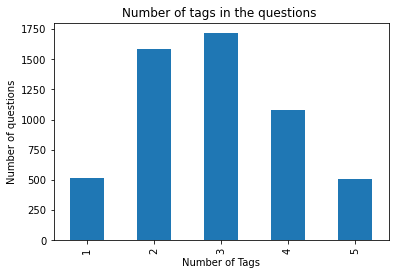

In [15]:
print ('We have total {} datapoints.'.format(len(tag_quest_count)))
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

quest_count = tag_quest_count.value_counts()
quest_count = quest_count.sort_index()
quest_count.plot.bar()

plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

In [16]:
df1 = dfQR.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate', 'Title', 'Body'], inplace=False)
df2 = df1.merge(dfT, on='Id')
df2.head()

#on coupe 4,5 / 11 / 33
df25 = df2[df2['Score']<5]
df50 = df2[(df2['Score']>4) & (df2['Score']<12)]
df75 = df2[(df2['Score']>11) & (df2['Score']<33)]
df100 = df2[df2['Score']>32]
print(df25.shape,df50.shape,df75.shape,df100.shape)

(3476, 3) (3784, 3) (3415, 3) (3989, 3)


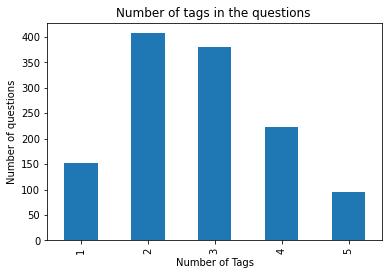

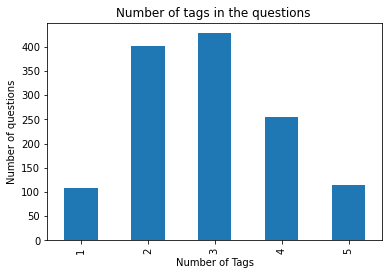

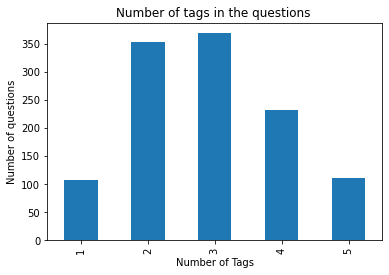

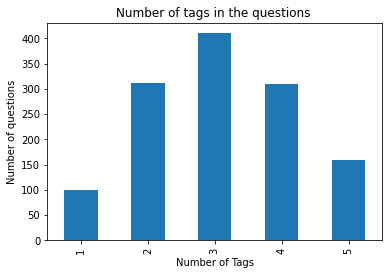

In [17]:
def study_quest(df):
    test = df[['Id']].value_counts()
    quest_count = test.value_counts()
    quest_count = quest_count.sort_index()
    
    plt.figure()
    quest_count.plot.bar()
    plt.title("Number of tags in the questions ")
    plt.xlabel("Number of Tags")
    plt.ylabel("Number of questions")
    plt.show()

for dfxx in [df25, df50, df75, df100]:
    study_quest(dfxx)

visiblement les articles qui ont servis à plus de monde, ont un nombre de tags supérieurs à ceux qui n'en ont qu'un ou deux



# Partie 3 : pré-traitement des questions et des tags

Les données que l'on récupère doivent être nettoyées car elles sont trop compliquées à traiter de façon brut :
il faut retirer le HTML, la ponctuation, retirer les mots non porteur de sens et ne garder que les radicaux des mots restants afin de regrouper "manger" et "mangera"

- retirer toutes les colonnes inutiles à la classification
- faire un unique data frame
- traiter le texte pour le rendre classifiable

In [32]:
# Fonction pour le pré traitement des questions qui seront misent par la suite dans un fichier .py

token=ToktokTokenizer()
lemma=WordNetLemmatizer()
stopwords.words("english")
dfT = pd.read_csv('tags.csv')
dfT.columns = ['Id', 'Tag']
liste = dfT['Tag']
words = liste.values

def retire_html(text): # retire les balises HTML
    soup = BeautifulSoup(text).get_text()
    return soup

def clean_punck(text): # retire la ponctuation et les majuscules
    #punct = list(punctuation)
    # '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    punct = list('!"%&\'()*,./:;<=>?@[\\]^_`{|}~')
    for c in punct:
        text = text.replace(c, "")
    text = text.lower()
    return text

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def retire_punck(text): 
    #print("RETIRE PONCTUATION :")
    #print(text)
    text = text.lower()
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in dfT['Tag'].to_list():
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
    print(filtered_list)   
    return ' '.join(map(str, filtered_list))

def lemitize_words(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def tokenize(text): # passe de text à liste de mots
    token=ToktokTokenizer()
    words = token.tokenize(text)
    return words

def retire_stopwords(text): # retire les mots dénués de sens fondamental EN MINUSCULE
    text = token.tokenize(text)
    filtre = set(stopwords.words("english"))
    filtered = [w for w in text if not w in filtre]
    return ' '.join(map(str, filtered))


def nettoyage_df(df, col):
    df[col] = df[col].apply(retire_html)
    print(df[col][0])
    df[col] = df[col].apply(retire_punck)
    print(df[col][0])
    df[col] = df[col].apply(lemitize_words)
    print(df[col][0])
    df[col] = df[col].apply(retire_stopwords)
    print(df[col][0])
    return df

def nettoyage_text(text):
    text = retire_html(text)
    text = retire_punck(text)
    text = lemitize_words(text)
    text = retire_stopwords(text)
    return text 

# Fonction de traitement de la table TAGS
def most_common_tags(dfT,nbr):
    # recupératoin des 500 tags les plus communs
    dfT.columns = ['Id', 'Tag']
    words = dfT['Tag'].values
    mc = Counter(words).most_common(nbr)
    list_tags = [e[0] for e in mc]
    return list_tags

def nettoyage_tag(dfT, list_tags):
    # suppresion des tags les moins communs
    #dfT['Tag'] = dfT['Tag'].astype(str)
    dfT.columns = ['Id', 'Tag']
    print(dfT.shape)
    new_dfT = dfT[dfT['Tag'].isin(list_tags)]
    print(new_dfT.shape)
    
    #création de la table tags
    tags = new_dfT.groupby(["Id"])['Tag'].apply(lambda new_dfT: ' '.join(new_dfT))
    #tags.columns = ['Id', 'Tag']
    return tags

# Fonction de créatoin de notre data
def create_data(dfT, dfQR, nbr):
    list_tags = most_common_tags(dfT,nbr)
    tags = nettoyage_tag(dfT, list_tags)
    
    dfQR.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
    data = dfQR.merge(tags, on='Id')
    data.drop_duplicates(inplace = True)
    data.drop(columns=['Id', 'Score'], inplace=True)
    
    tags_features = Counter(dfT['Tag'].values).most_common(nbr)
    data = nettoyage_df(data, 'Body')
    data = nettoyage_df(data, 'Title')
    data['question'] = data['Title'] +' '+ data['Title'] +' '+ data['Title'] + ' '+ data['Body']
    data.drop(columns = ['Title','Body'], inplace = True)
    return data

def preprocessing():
    dfQR = pd.read_csv('questions.csv')
    dfT = pd.read_csv('tags.csv')
    data = create_data(dfT, dfQR, 20)
    data.to_csv('data.csv')

In [33]:
preprocessing()

(15715, 2)
(4747, 2)
I want to use a Track-Bar to change a Form's opacity.
This is my code:
decimal trans = trackBar1.Value / 5000;
this.Opacity = trans;

When I build the application, it gives the following error:

Cannot implicitly convert type decimal to double


I have tried using trans and double, but then the Control doesn't work. This code worked fine in a past VB.NET project.

['i', 'want', 'to', 'use', 'a', 'track-bar', 'to', 'change', 'a', 'form', 's', 'opacity', 'this', 'is', 'my', 'code', 'decimal', 'trans', 'trackbar1value', '5000', 'thisopacity', 'trans', 'when', 'i', 'build', 'the', 'application', 'it', 'gives', 'the', 'following', 'error', 'cannot', 'implicitly', 'convert', 'type', 'decimal', 'to', 'double', 'i', 'have', 'tried', 'using', 'trans', 'and', 'double', 'but', 'then', 'the', 'control', 'doesn', 't', 'work', 'this', 'code', 'worked', 'fine', 'in', 'a', 'past', 'vb.net', 'project']
['i', 'have', 'an', 'absolutely', 'positioned', 'div', 'containing', 'several', 

['in', '.net', 'perspective', 'what', 'is', 'a', 'memory', 'leak', 'how', 'can', 'you', 'determine', 'whether', 'your', 'application', 'leaks', 'what', 'are', 'the', 'effects', 'how', 'can', 'you', 'prevent', 'a', 'memory', 'leak', 'if', 'your', 'application', 'has', 'memory', 'leak', 'does', 'it', 'go', 'away', 'when', 'the', 'process', 'exits', 'or', 'is', 'killed', 'or', 'do', 'memory', 'leaks', 'in', 'your', 'application', 'affect', 'other', 'processes', 'on', 'the', 'system', 'even', 'after', 'process', 'completion', 'and', 'what', 'about', 'unmanaged', 'code', 'accessed', 'via', 'com', 'interop', 'andor', 'pinvoke']
['i', 've', 'been', 'using', 'tortoisesvn', 'in', 'a', 'windows', 'environment', 'for', 'quite', 'some', 'time', 'it', 'seems', 'very', 'feature-complete', 'and', 'nicely', 'integrated', 'into', 'the', 'windows', 'shell', 'and', 'more', 'importantly', 'it', 's', 'fairly', 'painless', 'to', 'teach', 'to', 'colleagues', 'with', 'little', 'or', 'no', 'experience', 'with'

['i', 've', 'been', 'banging', 'my', 'head', 'against', 'sql', 'server', '2005', 'trying', 'to', 'get', 'a', 'lot', 'of', 'data', 'out', 'i', 've', 'been', 'given', 'a', 'database', 'with', 'nearly', '300', 'tables', 'in', 'it', 'and', 'i', 'need', 'to', 'turn', 'this', 'into', 'a', 'mysql', 'database', 'my', 'first', 'call', 'was', 'to', 'use', 'bcp', 'but', 'unfortunately', 'it', 'doesn', 't', 'produce', 'valid', 'csv', '-', 'strings', 'aren', 't', 'encapsulated', 'so', 'you', 'can', 't', 'deal', 'with', 'any', 'row', 'that', 'has', 'a', 'string', 'with', 'a', 'comma', 'in', 'it', 'or', 'whatever', 'you', 'use', 'as', 'a', 'delimiter', 'and', 'i', 'would', 'still', 'have', 'to', 'hand', 'write', 'all', 'of', 'the', 'create', 'table', 'statements', 'as', 'obviously', 'csv', 'doesn', 't', 'tell', 'you', 'anything', 'about', 'the', 'data', 'types', 'what', 'would', 'be', 'better', 'is', 'if', 'there', 'was', 'some', 'tool', 'that', 'could', 'connect', 'to', 'both', 'sql', 'server', 'and

['one', 'of', 'the', 'fun', 'parts', 'of', 'multi-cultural', 'programming', 'is', 'number', 'formats', 'americans', 'use', '1000050', 'germans', 'use', '1000050', 'french', 'use', '10', '00050', 'my', 'first', 'approach', 'would', 'be', 'to', 'take', 'the', 'string', 'parse', 'it', 'backwards', 'until', 'i', 'encounter', 'a', 'separator', 'and', 'use', 'this', 'as', 'my', 'decimal', 'separator', 'there', 'is', 'an', 'obvious', 'flaw', 'with', 'that', '10000', 'would', 'be', 'interpreted', 'as', '10', 'another', 'approach', 'if', 'the', 'string', 'contains', '2', 'different', 'non-numeric', 'characters', 'use', 'the', 'last', 'one', 'as', 'the', 'decimal', 'separator', 'and', 'discard', 'the', 'others', 'if', 'i', 'only', 'have', 'one', 'check', 'if', 'it', 'occurs', 'more', 'than', 'once', 'and', 'discards', 'it', 'if', 'it', 'does', 'if', 'it', 'only', 'appears', 'once', 'check', 'if', 'it', 'has', '3', 'digits', 'after', 'it', 'if', 'yes', 'discard', 'it', 'otherwise', 'use', 'it', '

['i', 've', 'been', 'writing', 'a', 'few', 'web', 'services', 'for', 'a', '.net', 'app', 'now', 'i', 'm', 'ready', 'to', 'consume', 'them', 'i', 've', 'seen', 'numerous', 'examples', 'where', 'there', 'is', 'homegrown', 'code', 'for', 'consuming', 'the', 'service', 'as', 'opposed', 'to', 'using', 'the', 'auto', 'generated', 'methods', 'that', 'visual', 'studio', 'creates', 'when', 'adding', 'the', 'web', 'reference', 'is', 'there', 'some', 'advantages', 'to', 'this']
['assume', 'you', 'are', 'doing', 'something', 'like', 'the', 'following', 'liststring', 'myitems', 'new', 'liststring', 'item', '1', 'item', '2', 'item', '3', 'combobox', 'box', 'new', 'combobox', 'boxdatasource', 'myitems', 'combobox', 'box2', 'new', 'combobox', 'box2datasource', 'myitems', 'so', 'now', 'we', 'have', '2', 'combo', 'boxes', 'bound', 'to', 'that', 'array', 'and', 'everything', 'works', 'fine', 'but', 'when', 'you', 'change', 'the', 'value', 'of', 'one', 'combo', 'box', 'it', 'changes', 'both', 'combo', 'bo

['i', 'was', 'and', 'still', 'am', 'looking', 'for', 'an', 'embedded', 'database', 'to', 'be', 'used', 'in', 'a', '.net', 'c#', 'application', 'the', 'caveat', 'the', 'application', 'or', 'at', 'least', 'the', 'database', 'is', 'stored', 'on', 'a', 'network', 'drive', 'but', 'only', 'used', 'by', '1', 'user', 'at', 'a', 'time', 'now', 'my', 'first', 'idea', 'was', 'sql', 'server', 'compact', 'edition', 'that', 'is', 'really', 'nicely', 'integreated', 'but', 'it', 'can', 'not', 'run', 'off', 'a', 'network', 'firebird', 'seems', 'to', 'have', 'the', 'same', 'issue', 'but', 'the', '.net', 'integration', 'seems', 'to', 'be', 'not', 'really', 'first-class', 'and', 'is', 'largely', 'undocumented', 'blackfish', 'sql', 'looks', 'interesting', 'but', 'there', 'is', 'no', 'trial', 'of', 'the', '.net', 'version', 'pricing', 'is', 'also', 'ok', 'any', 'other', 'suggestions', 'of', 'something', 'that', 'works', 'well', 'with', '.net', 'and', 'runs', 'off', 'a', 'network', 'without', 'the', 'need', 

['we', 're', 'upgrading', 'an', 'existing', 'program', 'from', 'win2ksql', 'server', '2k', 'to', 'windows', '2003', 'and', 'sql', 'server', '2005', 'as', 'well', 'as', 'purchasing', 'a', 'new', 'program', 'that', 'also', 'uses', '2k32k5', 'the', 'vendor', 'says', 'that', 'for', 'us', 'to', 'host', 'both', 'databases', 'we', 'need', 'to', 'get', 'the', 'enterprise', 'version', 'because', 'the', 'softwares', 'clients', 'use', 'different', 'collation', 'for', 'the', 'connections', 'and', 'only', 'enterprise', 'supports', 'this', 'i', 'cannot', 'find', 'anything', 'on', 'ms', 's', 'site', 'to', 'support', 'this', 'and', 'honestly', 'don', 't', 'want', 'to', 'pay', 'the', 'extra', 'for', 'enterprise', 'if', 'the', 'standard', 'edition', 'works', 'am', 'i', 'missing', 'some', 'not', 'talked', 'about', 'feature', 'of', 'sql', 'server', 'or', 'is', 'this', 'as', 'i', 'suspect', 'a', 'vendor', 'trying', 'to', 'upsell', 'me']
['what', 's', 'the', 'simplest', 'way', 'to', 'connect', 'and', 'query

['i', 've', 'tried', 'to', 'write', 'a', 'string', 'replace', 'function', 'in', 'c', 'which', 'works', 'on', 'a', 'char', 'which', 'has', 'been', 'allocated', 'using', 'malloc', 'it', 's', 'a', 'little', 'different', 'in', 'that', 'it', 'will', 'find', 'and', 'replace', 'strings', 'rather', 'than', 'characters', 'in', 'the', 'starting', 'string', 'it', 's', 'trivial', 'to', 'do', 'if', 'the', 'search', 'and', 'replace', 'strings', 'are', 'the', 'same', 'length', 'or', 'the', 'replace', 'string', 'is', 'shorter', 'than', 'the', 'search', 'string', 'since', 'i', 'have', 'enough', 'space', 'allocated', 'if', 'i', 'try', 'to', 'use', 'realloc', 'i', 'get', 'an', 'error', 'that', 'tells', 'me', 'i', 'am', 'doing', 'a', 'double', 'free', '-', 'which', 'i', 'don', 't', 'see', 'how', 'i', 'am', 'since', 'i', 'am', 'only', 'using', 'realloc', 'perhaps', 'a', 'little', 'code', 'will', 'help', 'void', 'strrep', 'char', 'input', 'char', 'search', 'char', 'replace', 'int', 'searchlen', 'strlen', 's

['i', 'need', 'to', 'copy', 'hundreds', 'of', 'gigs', 'of', 'random', 'files', 'around', 'on', 'my', 'computer', 'and', 'am', 'pretty', 'leery', 'of', 'using', 'the', 'vanilla', 'file', 'copy', 'built', 'into', 'windows', 'i', 'don', 't', 'want', 'it', 'to', 'hang', 'on', 'a', 'are', 'you', 'sure', 'are', 'you', 'really', 'sure', 'even', 'zip', 'files', 'surely', 'not', 'read-only', 'files', 'too', 'loop', 'as', 'soon', 'as', 'i', 'step', 'away', 'i', 'don', 't', 'want', 'it', 'to', 'work', 'for', 'hours', 'and', 'then', 'stop', 'unexpectedly', 'someone', 'once', 'opened', 'this', 'file', 'and', 'so', 'i', 'won', 't', 'copy', 'it', 'and', 'then', 'cancel', 'the', 'whole', 'copy', 'or', 'just', 'quit', 'with', 'no', 'indication', 'of', 'what', 'was', 'done', 'and', 'what', 'work', 'remains', 'what', 'file', 'management', 'programs', 'do', 'you', 'have', 'experience', 'with', 'which', 'do', 'you', 'recommend', 'this', 'question', 'is', 'related', 'to', 'my', 'other', 'question', 'how', '

['what', 'are', 'the', 'best', 'methods', 'for', 'tracking', 'andor', 'automating', 'db', 'schema', 'changes', 'our', 'team', 'uses', 'subversion', 'for', 'version', 'control', 'and', 'we', 've', 'been', 'able', 'to', 'automate', 'some', 'of', 'our', 'tasks', 'this', 'way', 'pushing', 'builds', 'up', 'to', 'a', 'staging', 'server', 'deploying', 'tested', 'code', 'to', 'a', 'production', 'server', 'but', 'we', 're', 'still', 'doing', 'database', 'updates', 'manually', 'i', 'would', 'like', 'to', 'find', 'or', 'create', 'a', 'solution', 'that', 'allows', 'us', 'to', 'work', 'efficiently', 'across', 'servers', 'with', 'different', 'environments', 'while', 'continuing', 'to', 'use', 'subversion', 'as', 'a', 'backend', 'through', 'which', 'code', 'and', 'db', 'updates', 'are', 'pushed', 'around', 'to', 'various', 'servers', 'many', 'popular', 'software', 'packages', 'include', 'auto-update', 'scripts', 'which', 'detect', 'db', 'version', 'and', 'apply', 'the', 'necessary', 'changes', 'is', 

['ok', 'this', 'is', 'a', 'bit', 'of', 'a', 'vanity', 'app', 'but', 'i', 'had', 'a', 'situation', 'today', 'at', 'work', 'where', 'i', 'was', 'in', 'a', 'training', 'class', 'and', 'the', 'machine', 'was', 'set', 'to', 'lock', 'every', '10', 'minutes', 'well', 'if', 'the', 'trainers', 'got', 'excited', 'about', 'talking', '-', 'as', 'opposed', 'to', 'changing', 'slides', '-', 'the', 'machine', 'would', 'lock', 'up', 'i', 'd', 'like', 'to', 'write', 'a', 'teeny', 'app', 'that', 'has', 'nothing', 'but', 'a', 'taskbar', 'icon', 'that', 'does', 'nothing', 'but', 'move', 'the', 'mouse', 'by', '1', 'pixel', 'every', '4', 'minutes', 'i', 'can', 'do', 'that', 'in', '3', 'ways', 'with', 'delphi', 'my', 'strong', 'language', 'but', 'i', 'm', 'moving', 'to', 'c#', 'for', 'work', 'and', 'i', 'd', 'like', 'to', 'know', 'the', 'path', 'of', 'least', 'resistance', 'there']
['i', 'am', 'currently', 'working', 'on', 'a', 'project', 'and', 'my', 'goal', 'is', 'to', 'locate', 'text', 'in', 'an', 'image',

['when', 'you', 'data', 'bind', 'in', 'c#', 'the', 'thread', 'that', 'changes', 'the', 'data', 'causes', 'the', 'control', 'to', 'change', 'too', 'but', 'if', 'this', 'thread', 'is', 'not', 'the', 'one', 'on', 'which', 'the', 'control', 'was', 'created', 'you', 'll', 'get', 'an', 'illegal', 'cross', 'thread', 'operation', 'exception', 'is', 'there', 'anyway', 'to', 'prevent', 'this']
['i', 'have', 'values', 'stored', 'as', 'strings', 'in', 'a', 'datatable', 'where', 'each', 'value', 'could', 'really', 'represent', 'an', 'int', 'double', 'or', 'string', 'they', 'were', 'all', 'converted', 'to', 'strings', 'during', 'an', 'import', 'process', 'from', 'an', 'external', 'data', 'source', 'i', 'need', 'to', 'test', 'and', 'see', 'what', 'type', 'each', 'value', 'really', 'is', 'what', 'is', 'more', 'efficient', 'for', 'the', 'application', 'or', 'is', 'there', 'no', 'practical', 'difference', 'try', 'to', 'convert', 'to', 'int', 'and', 'then', 'double', 'if', 'conversion', 'works', 'the', '

['i', 'am', 'building', 'a', 'web', 'page', 'to', 'show', 'a', 'customer', 'what', 'software', 'they', 'purchased', 'and', 'to', 'give', 'them', 'a', 'link', 'to', 'download', 'said', 'software', 'unfortunately', 'the', 'data', 'on', 'what', 'was', 'purchased', 'and', 'the', 'download', 'information', 'are', 'in', 'separate', 'databases', 'so', 'i', 'can', 't', 'just', 'take', 'care', 'of', 'it', 'with', 'joins', 'in', 'an', 'sql', 'query', 'the', 'common', 'item', 'is', 'sku', 'i', 'll', 'be', 'pulling', 'a', 'list', 'of', 'skus', 'from', 'the', 'customer', 'purchases', 'database', 'and', 'on', 'the', 'download', 'table', 'is', 'a', 'comma', 'delineated', 'list', 'of', 'skus', 'associated', 'with', 'that', 'download', 'my', 'intention', 'at', 'the', 'moment', 'is', 'to', 'create', 'from', 'this', 'one', 'datatable', 'to', 'populate', 'a', 'gridview', 'any', 'suggestions', 'on', 'how', 'to', 'do', 'this', 'efficiently', 'would', 'be', 'appreciated', 'if', 'it', 'helps', 'i', 'can', 'pr

['when', 'writing', 'a', 't-sql', 'script', 'that', 'i', 'plan', 'on', 're-running', 'often', 'times', 'i', 'use', 'temporary', 'tables', 'to', 'store', 'temporary', 'data', 'since', 'the', 'temp', 'table', 'is', 'created', 'on', 'the', 'fly', 'i', 'd', 'like', 'to', 'be', 'able', 'to', 'drop', 'that', 'table', 'only', 'if', 'it', 'exists', 'before', 'i', 'create', 'it', 'i', 'll', 'post', 'the', 'method', 'that', 'i', 'use', 'but', 'i', 'd', 'like', 'to', 'see', 'if', 'there', 'is', 'a', 'better', 'way']
['i', 'need', 'to', 'implement', 'version', 'control', 'even', 'for', 'just', 'the', 'developing', 'i', 'do', 'at', 'home', 'i', 'have', 'read', 'about', 'how', 'great', 'subversion', 'is', 'for', 'the', 'past', 'couple', 'years', 'and', 'was', 'about', 'to', 'dedicate', 'myself', 'to', 'learning', 'this', 'on', 'the', 'side', 'until', 'i', 'heard', 'about', 'git', 'being', 'the', 'up', 'and', 'coming', 'version', 'control', 'system', 'given', 'the', 'situation', 'should', 'i', 'hold'

['my', 'goal', 'i', 'would', 'like', 'to', 'have', 'a', 'main', 'processing', 'thread', 'non', 'gui', 'and', 'be', 'able', 'to', 'spin', 'off', 'guis', 'in', 'their', 'own', 'background', 'threads', 'as', 'needed', 'and', 'having', 'my', 'main', 'non', 'gui', 'thread', 'keep', 'working', 'put', 'another', 'way', 'i', 'want', 'my', 'main', 'non', 'gui-thread', 'to', 'be', 'the', 'owner', 'of', 'the', 'gui-thread', 'and', 'not', 'vice', 'versa', 'i', 'm', 'not', 'sure', 'this', 'is', 'even', 'possible', 'with', 'windows', 'forms', 'background', 'i', 'have', 'a', 'component', 'based', 'system', 'in', 'which', 'a', 'controller', 'dynamically', 'load', 'assemblies', 'and', 'instantiates', 'and', 'run', 'classes', 'implementing', 'a', 'common', 'icomponent', 'interface', 'with', 'a', 'single', 'method', 'dostuff', 'which', 'components', 'that', 'gets', 'loaded', 'is', 'configured', 'via', 'a', 'xml', 'configuration', 'file', 'and', 'by', 'adding', 'new', 'assemblies', 'containing', 'differen

['for', 'parsing', 'player', 'commands', 'i', 've', 'most', 'often', 'used', 'the', 'split', 'method', 'to', 'split', 'a', 'string', 'by', 'delimiters', 'and', 'then', 'to', 'then', 'just', 'figure', 'out', 'the', 'rest', 'by', 'a', 'series', 'of', 'ifs', 'or', 'switches', 'what', 'are', 'some', 'different', 'ways', 'of', 'parsing', 'strings', 'in', 'java']
['i', 'am', 'writing', 'an', 'application', 'that', 'needs', 'to', 'bring', 'window', 'of', 'an', 'external', 'app', 'to', 'the', 'foreground', 'and', 'not', 'necessarily', 'steal', 'focus', 'there', 'is', 'a', 'setting', 'the', 'user', 'can', 'toggle', 'to', 'stealnot', 'steal', 'focus', 'what', 'is', 'the', 'best', 'way', 'to', 'go', 'about', 'this', 'using', 'the', 'win32', 'api', 'i', 'have', 'tried', 'setforeground', 'but', 'it', 'always', 'steals', 'focus', 'and', 'does', 'not', 'consistenly', 'work', 'what', 'is', 'the', 'best', 'way', 'to', 'go', 'about', 'this', 'any', 'thoughts']
['i', 'am', 'using', 'asp.net', 'dynamic', 

['i', 'm', 'developing', 'some', 'cross', 'platform', 'software', 'targeting', 'mono', 'under', 'visual', 'studio', 'and', 'would', 'like', 'to', 'be', 'able', 'to', 'build', 'the', 'installers', 'for', 'windows', 'and', 'linux', 'ubuntu', 'specifically', 'with', 'a', 'single', 'button', 'click', 'i', 'figure', 'i', 'could', 'do', 'it', 'by', 'calling', 'cygwin', 'from', 'a', 'post-build', 'event', 'but', 'i', 'was', 'hoping', 'for', 'at', 'best', 'a', 'visual', 'studio', 'plugin', 'or', 'at', 'worst', 'a', 'more', 'windows-native', 'way', 'of', 'doing', 'it', 'it', 'seems', 'like', 'the', 'package', 'format', 'is', 'fairly', 'simple', 'and', 'this', 'must', 'be', 'a', 'common', 'need', 'edit', 're-asked', 'question', 'under', 'other', 'account', 'due', 'to', 'duplicate', 'login', 'issue']
['i', 'have', 'seen', 'these', 'being', 'used', 'every', 'which', 'way', 'and', 'have', 'been', 'accused', 'of', 'using', 'them', 'the', 'wrong', 'way', 'though', 'in', 'that', 'case', 'i', 'was', 'u

['i', 'am', 'currently', 'working', 'on', 'a', 'project', 'with', 'specific', 'requirements', 'a', 'brief', 'overview', 'of', 'these', 'are', 'as', 'follows', 'data', 'is', 'retrieved', 'from', 'external', 'webservices', 'data', 'is', 'stored', 'in', 'sql', '2005', 'data', 'is', 'manipulated', 'via', 'a', 'web', 'gui', 'the', 'windows', 'service', 'that', 'communicates', 'with', 'the', 'web', 'services', 'has', 'no', 'coupling', 'with', 'our', 'internal', 'web', 'ui', 'except', 'via', 'the', 'database', 'communication', 'with', 'the', 'web', 'services', 'needs', 'to', 'be', 'both', 'time-based', 'and', 'triggered', 'via', 'user', 'intervention', 'on', 'the', 'web', 'ui', 'the', 'current', 'pre-pre-production', 'model', 'for', 'web', 'service', 'communication', 'triggering', 'is', 'via', 'a', 'database', 'table', 'that', 'stores', 'trigger', 'requests', 'generated', 'from', 'the', 'manual', 'intervention', 'i', 'do', 'not', 'really', 'want', 'to', 'have', 'multiple', 'trigger', 'mechani

['generally', 'when', 'i', 'use', 'clickonce', 'when', 'i', 'build', 'a', 'vb.net', 'program', 'but', 'it', 'has', 'a', 'few', 'downsides', 'i', 've', 'never', 'really', 'used', 'anything', 'else', 'so', 'i', 'm', 'not', 'sure', 'what', 'my', 'options', 'are', 'downsides', 'to', 'clickonce', 'consists', 'of', 'multiple', 'files', '-', 'seems', 'easier', 'to', 'distribute', 'one', 'file', 'than', 'manageing', 'a', 'bunch', 'of', 'file', 'and', 'the', 'downloader', 'to', 'download', 'those', 'files', 'you', 'have', 'to', 'build', 'it', 'again', 'for', 'cd', 'installations', 'for', 'when', 'the', 'end', 'user', 'dosn', 't', 'have', 'internet', 'program', 'does', 'not', 'end', 'up', 'in', 'program', 'files', '-', 'it', 'ends', 'up', 'hidden', 'away', 'in', 'some', 'application', 'catch', 'folder', 'making', 'it', 'much', 'harder', 'to', 'shortcut', 'to', 'pros', 'to', 'clickonce', 'it', 'works', 'magically', 'and', 'it', 's', 'built', 'into', 'visualstudio', '2008', 'express', 'makes', 'it

['i', 'need', 'to', 'detect', 'when', 'a', 'session', 'has', 'expired', 'in', 'my', 'visuial', 'basic', 'web', 'application', 'this', 'is', 'what', 'i', 'm', 'using', 'protected', 'sub', 'pageload', 'byval', 'sender', 'as', 'object', 'byval', 'e', 'as', 'systemeventargs', 'handles', 'meload', 'if', 'currentsessionisnew', 'andalso', 'not', 'pagerequestheaders', 'cookie', 'is', 'nothing', 'andalso', 'pagerequestheaders', 'cookie', 'indexof', 'aspnetsessionid', '0', 'then', 'responseredirect', 'timeoutaspx', 'end', 'if', 'do', 'something', 'end', 'sub', 'note', 'currentsessionisnew', 'returns', 'httpcontextcurrentsessionisnewsession', 'this', 'seems', 'to', 'work', 'well', 'for', 'internet', 'explorer', 'but', 'seems', 'to', 'fail', 'with', 'firefox']
['i', 'm', 'trying', 'out', 'the', 'following', 'query', 'select', 'a', 'b', 'c', 'from', 'table', 'where', 'field', 'like', 'query', 'union', 'select', 'a', 'b', 'c', 'from', 'table', 'where', 'field', 'like', 'query', 'union', 'select', 'a

['i', 've', 'created', 'some', 'mbunit', 'test', 'fixtures', 'that', 'have', 'setup', 'methods', 'marked', 'with', 'the', 'setup', 'attribute', 'these', 'methods', 'run', 'before', 'the', 'tests', 'just', 'fine', 'using', 'the', 'mbunit', 'gui', 'the', 'console', 'runner', 'and', 'the', 'resharper', 'mbunit', 'plugin', 'however', 'when', 'i', 'run', 'the', 'tests', 'with', 'testdriven.net', 'it', 'does', 'not', 'run', 'the', 'setup', 'methods', 'at', 'all', 'does', 'anyone', 'know', 'if', 'this', 'is', 'a', 'bug', 'with', 'testdriven.net', 'or', 'if', 'i', 'have', 'something', 'setup', 'wrong']
['most', 'recent', 'edits', 'in', 'bold', 'i', 'am', 'using', 'the', '.net', 'httplistener', 'class', 'but', 'i', 'won', 't', 'be', 'running', 'this', 'application', 'on', 'iis', 'and', 'am', 'not', 'using', 'aspnet', 'this', 'web', 'site', 'describes', 'what', 'code', 'to', 'actually', 'use', 'to', 'implement', 'ssl', 'with', 'asp.net', 'and', 'this', 'site', 'describes', 'how', 'to', 'set', 'u

['i', 'm', 'using', 'a', 'dictionarystring', 'int', 'where', 'the', 'int', 'is', 'a', 'count', 'of', 'the', 'key', 'now', 'i', 'need', 'to', 'access', 'the', 'last-inserted', 'key', 'inside', 'the', 'dictionary', 'but', 'i', 'do', 'not', 'know', 'the', 'name', 'of', 'it', 'the', 'obvious', 'attempt', 'int', 'lastcount', 'mydict', 'mydictkeys', 'mydictkeyscount', 'does', 'not', 'work', 'because', 'dictionarykeys', 'does', 'not', 'implement', 'a', '-indexer', 'i', 'just', 'wonder', 'if', 'there', 'is', 'any', 'similar', 'class', 'i', 'thought', 'about', 'using', 'a', 'stack', 'but', 'that', 'only', 'stores', 'a', 'string', 'i', 'could', 'now', 'create', 'my', 'own', 'struct', 'and', 'then', 'use', 'a', 'stackmystruct', 'but', 'i', 'wonder', 'if', 'there', 'is', 'another', 'alternative', 'essentially', 'a', 'dictionary', 'that', 'implements', 'an', '-indexer', 'on', 'the', 'keys']
['i', 've', 'been', 'doing', 'asp.net', 'development', 'for', 'a', 'little', 'while', 'now', 'and', 'i', 've'

['typical', 'way', 'of', 'creating', 'a', 'csv', 'string', 'pseudocode', 'create', 'a', 'csv', 'container', 'object', 'like', 'a', 'stringbuilder', 'in', 'c#', 'loop', 'through', 'the', 'strings', 'you', 'want', 'to', 'add', 'appending', 'a', 'comma', 'after', 'each', 'one', 'after', 'the', 'loop', 'remove', 'that', 'last', 'superfluous', 'comma', 'code', 'sample', 'public', 'string', 'returnascsv', 'contactlist', 'contactlist', 'stringbuilder', 'sb', 'new', 'stringbuilder', 'foreach', 'contact', 'c', 'in', 'contactlist', 'sbappend', 'cname', 'sbremove', 'sblength', '-', '1', '1', 'sbreplace', 'sblength', '-', '1', '1', 'return', 'sbtostring', 'i', 'like', 'the', 'idea', 'of', 'adding', 'the', 'comma', 'by', 'checking', 'if', 'the', 'container', 'is', 'empty', 'but', 'doesn', 't', 'that', 'mean', 'more', 'processing', 'as', 'it', 'needs', 'to', 'check', 'the', 'length', 'of', 'the', 'string', 'on', 'each', 'occurrence', 'i', 'feel', 'that', 'there', 'should', 'be', 'an', 'easiercleaner

['we', 've', 'been', 'having', 'some', 'issues', 'with', 'a', 'sharepoint', 'instance', 'in', 'a', 'test', 'environment', 'thankfully', 'this', 'is', 'not', 'production', 'the', 'problems', 'started', 'when', 'the', 'disk', 'with', 'the', 'sql', 'server', 'databases', 'and', 'search', 'index', 'ran', 'out', 'of', 'space', 'following', 'this', 'the', 'search', 'service', 'would', 'not', 'run', 'and', 'search', 'settings', 'in', 'the', 'ssp', 'were', 'not', 'accessible', 'reclaiming', 'the', 'disk', 'space', 'did', 'not', 'resolve', 'the', 'issue', 'so', 'rather', 'than', 'restoring', 'the', 'vm', 'we', 'decided', 'to', 'try', 'to', 'fix', 'the', 'issue', 'we', 'created', 'a', 'new', 'ssp', 'and', 'changed', 'the', 'association', 'of', 'all', 'services', 'to', 'the', 'new', 'ssp', 'the', 'old', 'ssp', 'and', 'it', 's', 'databases', 'were', 'then', 'deleted', 'search', 'results', 'for', 'pdf', 'files', 'are', 'no', 'longer', 'appearing', 'but', 'the', 'search', 'works', 'fine', 'otherwise

['using', 'vs2008', 'c#', '.net', '2', 'and', 'winforms', 'how', 'can', 'i', 'make', 'a', 'regular', 'button', 'look', 'pressed', 'imagine', 'this', 'button', 'is', 'an', 'onoff', 'switch', 'toolstripbutton', 'has', 'the', 'checked', 'property', 'but', 'the', 'regular', 'button', 'does', 'not']
['i', 'saw', 'this', 'in', 'an', 'answer', 'to', 'another', 'question', 'in', 'reference', 'to', 'shortcomings', 'of', 'the', 'java', 'spec', 'there', 'are', 'more', 'shortcomings', 'and', 'this', 'is', 'a', 'subtle', 'topic', 'check', 'this', 'out', 'public', 'class', 'methodoverloading', 'public', 'static', 'void', 'hello', 'integer', 'x', 'systemoutprintln', 'integer', 'public', 'static', 'void', 'hello', 'long', 'x', 'systemoutprintln', 'long', 'public', 'static', 'void', 'main', 'string', 'args', 'int', 'i', '5', 'hello', 'i', 'here', 'long', 'would', 'be', 'printed', 'haven', 't', 'checked', 'it', 'myself', 'because', 'the', 'compiler', 'chooses', 'widening', 'over', 'auto-boxing', 'be', '

['i', 'created', 'a', 'view', 'on', 'a', 'machine', 'using', 'the', 'substring', 'function', 'from', 'firebird', 'and', 'it', 'worked', 'when', 'i', 'copied', 'the', 'database', 'to', 'a', 'different', 'machine', 'the', 'view', 'was', 'broken', 'this', 'is', 'the', 'way', 'i', 'used', 'it', 'select', 'substring', 'field', 'from', '5', 'for', '15', 'from', 'table', 'and', 'this', 'is', 'the', 'output', 'on', 'the', 'machine', 'that', 'does', 'not', 'accept', 'the', 'function', 'token', 'unknown', 'from', 'both', 'computers', 'have', 'this', 'configuration', 'ib', 'expert', 'version', '25042', 'to', 'run', 'the', 'queries', 'and', 'deal', 'with', 'the', 'database', 'firebird', 'version', '15', 'as', 'server', 'to', 'database', 'bde', 'administration', 'version', '501', 'installed', 'with', 'interbase', '40', 'drivers', 'any', 'ideas', 'about', 'why', 'it', 's', 'behaving', 'differently', 'on', 'these', 'machines']
['i', 'was', 'wondering', 'if', 'there', 'are', 'any', 'alternatives', 'to

['i', 'know', 'that', 'just', 'using', 'rand', 'is', 'predictable', 'if', 'you', 'know', 'what', 'you', 're', 'doing', 'and', 'have', 'access', 'to', 'the', 'server', 'i', 'have', 'a', 'project', 'that', 'is', 'highly', 'dependent', 'upon', 'choosing', 'a', 'random', 'number', 'that', 'is', 'as', 'unpredictable', 'as', 'possible', 'so', 'i', 'm', 'looking', 'for', 'suggestions', 'either', 'other', 'built-in', 'functions', 'or', 'user', 'functions', 'that', 'can', 'generate', 'a', 'better', 'random', 'number', 'i', 'used', 'this', 'to', 'do', 'a', 'little', 'test', 'i', '0', 'while', 'i', '10000', 'rand', 'rand', '0', '100', 'if', 'isset', 'array', 'rand', 'array', 'rand', '1', 'else', 'array', 'rand', 'sort', 'array', 'i', 'i', 'found', 'the', 'results', 'to', 'be', 'evenly', 'distributed', 'and', 'there', 'is', 'an', 'odd', 'pattern', 'to', 'the', 'number', 'of', 'times', 'each', 'number', 'is', 'generated']
['it', 'is', 'supposed', 'to', 'be', 'backwards', 'compatible', 'with', 'html

['i', 've', 'opened', 'an', 'old', 'workspace', 'that', 'is', 'a', 'libray', 'and', 'its', 'test', 'harness', 'it', 'used', 'to', 'work', 'fine', 'but', 'now', 'doesn', 't', 'and', 'older', 'versions', 'of', 'the', 'code', 'don', 't', 'work', 'either', 'with', 'the', 'same', 'errors', 'i', 've', 'tried', 'recreating', 'the', 'project', 'and', 'that', 'causes', 'the', 'same', 'errors', 'too', 'nothing', 'seems', 'out', 'of', 'order', 'in', 'project', 'settings', 'and', 'the', 'code', 'generated', 'works', 'in', 'the', 'main', 'app', 'i', 've', 'stripped', 'out', 'most', 'of', 'the', 'files', 'and', 'got', 'it', 'down', 'to', 'the', 'bare', 'minimum', 'to', 'generate', 'the', 'error', 'unfortunately', 'i', 'can', 't', 'post', 'the', 'project', 'as', 'this', 'is', 'used', 'in', 'production', 'code', 'the', 'lnk2001', 'linker', 'error', 'i', 'get', 'usually', 'means', 'i', 've', 'left', 'off', 'a', 'library', 'or', 'forgot', 'to', 'implement', 'a', 'virtual', 'function', 'however', 'this',

['basically', 'i', 've', 'written', 'an', 'api', 'to', 'wwwthetvdbcom', 'in', 'python', 'the', 'current', 'code', 'can', 'be', 'found', 'here', 'it', 'grabs', 'data', 'from', 'the', 'api', 'as', 'requested', 'and', 'has', 'to', 'store', 'the', 'data', 'somehow', 'and', 'make', 'it', 'available', 'by', 'doing', 'print', 'tvdbinstance', '1', '23', 'episodename', 'get', 'the', 'name', 'of', 'episode', '23', 'of', 'season', '1', 'what', 'is', 'the', 'best', 'way', 'to', 'abstract', 'this', 'data', 'within', 'the', 'tvdb', 'class', 'i', 'originally', 'used', 'a', 'extended', 'dict', 'that', 'automatically', 'created', 'sub-dicts', 'so', 'you', 'could', 'do', 'x', '1', '2', '3', '4', 'something', 'without', 'having', 'to', 'do', 'if', 'x', '1', 'haskey', '2', 'x', '1', '2', 'and', 'so', 'on', 'then', 'i', 'just', 'stored', 'the', 'data', 'by', 'doing', 'selfdata', 'showid', 'seasonnumber', 'episodenumber', 'attributename', 'something', 'this', 'worked', 'okay', 'but', 'there', 'was', 'no', '

['it', 's', 'something', 'that', 's', 'bugged', 'me', 'in', 'every', 'language', 'i', 've', 'used', 'i', 'have', 'an', 'if', 'statement', 'but', 'the', 'conditional', 'part', 'has', 'so', 'many', 'checks', 'that', 'i', 'have', 'to', 'split', 'it', 'over', 'multiple', 'lines', 'use', 'a', 'nested', 'if', 'statement', 'or', 'just', 'accept', 'that', 'it', 's', 'ugly', 'and', 'move', 'on', 'with', 'my', 'life', 'are', 'there', 'any', 'other', 'methods', 'that', 'you', 've', 'found', 'that', 'might', 'be', 'of', 'use', 'to', 'me', 'and', 'anybody', 'else', 'that', 's', 'hit', 'the', 'same', 'problem', 'example', 'all', 'on', 'one', 'line', 'if', 'var1', 'true', 'amp', 'var2', 'true', 'amp', 'var2', 'true', 'amp', 'var3', 'true', 'amp', 'var4', 'true', 'amp', 'var5', 'true', 'amp', 'var6', 'true', 'example', 'multi-line', 'if', 'var1', 'true', 'amp', 'var2', 'true', 'amp', 'var2', 'true', 'amp', 'var3', 'true', 'amp', 'var4', 'true', 'amp', 'var5', 'true', 'amp', 'var6', 'true', 'example-ne

['i', 've', 'had', 'a', 'hard', 'time', 'trying', 'to', 'find', 'good', 'examples', 'of', 'how', 'to', 'manage', 'database', 'schemas', 'and', 'data', 'between', 'development', 'test', 'and', 'production', 'servers', 'here', 's', 'our', 'setup', 'each', 'developer', 'has', 'a', 'virtual', 'machine', 'running', 'our', 'app', 'and', 'the', 'mysql', 'database', 'it', 'is', 'their', 'personal', 'sandbox', 'to', 'do', 'whatever', 'they', 'want', 'currently', 'developers', 'will', 'make', 'a', 'change', 'to', 'the', 'sql', 'schema', 'and', 'do', 'a', 'dump', 'of', 'the', 'database', 'to', 'a', 'text', 'file', 'that', 'they', 'commit', 'into', 'svn', 'we', 're', 'wanting', 'to', 'deploy', 'a', 'continuous', 'integration', 'development', 'server', 'that', 'will', 'always', 'be', 'running', 'the', 'latest', 'committed', 'code', 'if', 'we', 'do', 'that', 'now', 'it', 'will', 'reload', 'the', 'database', 'from', 'svn', 'for', 'each', 'build', 'we', 'have', 'a', 'test', 'virtual', 'server', 'that'

['mocking', 'sealed', 'classes', 'can', 'be', 'quite', 'a', 'pain', 'i', 'currently', 'favor', 'an', 'adapter', 'pattern', 'to', 'handle', 'this', 'but', 'something', 'about', 'just', 'keeps', 'feels', 'weird', 'so', 'what', 'is', 'the', 'best', 'way', 'you', 'mock', 'sealed', 'classes', 'java', 'answers', 'are', 'more', 'than', 'welcome', 'in', 'fact', 'i', 'would', 'anticipate', 'that', 'the', 'java', 'community', 'has', 'been', 'dealing', 'with', 'this', 'longer', 'and', 'has', 'a', 'great', 'deal', 'to', 'offer', 'but', 'here', 'are', 'some', 'of', 'the', '.net', 'opinions', 'why', 'duck', 'typing', 'matters', 'for', 'c#', 'develoepers', 'creating', 'wrappers', 'for', 'sealed', 'and', 'other', 'types', 'for', 'mocking', 'unit', 'tests', 'for', 'wcf', 'and', 'moq']
['there', 'are', 'a', 'few', 'ways', 'to', 'get', 'class-like', 'behavior', 'in', 'javascript', 'the', 'most', 'common', 'seem', 'to', 'be', 'prototype', 'based', 'like', 'this', 'function', 'vector', 'x', 'y', 'x', 'this

['i', 'was', 'hoping', 'someone', 'could', 'help', 'me', 'out', 'with', 'a', 'problem', 'i', 'm', 'having', 'using', 'the', 'java', 'search', 'function', 'in', 'eclipse', 'on', 'a', 'particular', 'project', 'when', 'using', 'the', 'java', 'search', 'on', 'one', 'particular', 'project', 'i', 'get', 'an', 'error', 'message', 'saying', 'class', 'file', 'name', 'must', 'end', 'with', 'class', 'see', 'stack', 'trace', 'below', 'this', 'does', 'not', 'seem', 'to', 'be', 'happening', 'on', 'all', 'projects', 'just', 'one', 'particular', 'one', 'so', 'perhaps', 'there', 's', 'something', 'i', 'should', 'try', 'to', 'get', 'rebuilt', 'i', 'have', 'already', 'tried', 'project', '-', 'clean', 'and', 'closing', 'eclipse', 'deleting', 'all', 'the', 'built', 'class', 'files', 'and', 'restarting', 'eclipse', 'to', 'no', 'avail', 'the', 'only', 'reference', 'i', 've', 'been', 'able', 'to', 'find', 'on', 'google', 'for', 'the', 'problem', 'is', 'at', 'httpwwwcrazysquirrelcomcomputingjavaeclipseerror-du

['is', 'there', 'a', 'way', 'to', 'implement', 'a', 'singleton', 'object', 'in', 'c++', 'that', 'is', 'lazily', 'constructed', 'in', 'a', 'thread', 'safe', 'manner', 'two', 'threads', 'might', 'simultaneously', 'be', 'the', 'first', 'user', 'of', 'the', 'singleton', '-', 'it', 'should', 'still', 'only', 'be', 'constructed', 'once', 'doesn', 't', 'rely', 'on', 'static', 'variables', 'being', 'constructed', 'beforehand', 'so', 'the', 'singleton', 'object', 'is', 'itself', 'safe', 'to', 'use', 'during', 'the', 'construction', 'of', 'static', 'variables', 'i', 'don', 't', 'know', 'my', 'c++', 'well', 'enough', 'but', 'is', 'it', 'the', 'case', 'that', 'integral', 'and', 'constant', 'static', 'variables', 'are', 'initialized', 'before', 'any', 'code', 'is', 'executed', 'ie', 'even', 'before', 'static', 'constructors', 'are', 'executed', '-', 'their', 'values', 'may', 'already', 'be', 'initialized', 'in', 'the', 'program', 'image', 'if', 'so', '-', 'perhaps', 'this', 'can', 'be', 'exploited'

['i', 've', 'worked', 'on', 'a', 'number', 'of', 'different', 'embedded', 'systems', 'they', 'have', 'all', 'used', 'typedefs', 'or', 'defines', 'for', 'types', 'such', 'as', 'uint32', 'this', 'is', 'a', 'good', 'technique', 'as', 'it', 'drives', 'home', 'the', 'size', 'of', 'the', 'type', 'to', 'the', 'programmer', 'and', 'makes', 'you', 'more', 'conscious', 'of', 'chances', 'for', 'overflow', 'etc', 'but', 'on', 'some', 'systems', 'you', 'know', 'that', 'the', 'compiler', 'and', 'processor', 'won', 't', 'change', 'for', 'the', 'life', 'of', 'the', 'project', 'so', 'what', 'should', 'influence', 'your', 'decision', 'to', 'create', 'and', 'enforce', 'project-specific', 'types', 'edit', 'i', 'think', 'i', 'managed', 'to', 'lose', 'the', 'gist', 'of', 'my', 'question', 'and', 'maybe', 'it', 's', 'really', 'two', 'with', 'embedded', 'programming', 'you', 'may', 'need', 'types', 'of', 'specific', 'size', 'for', 'interfaces', 'and', 'also', 'to', 'cope', 'with', 'restricted', 'resources', '

['i', 'haven', 't', 'seen', 'any', 'questions', 'relating', 'to', 'gnu', 'autoconfautomake', 'builds', 'but', 'i', 'm', 'hoping', 'at', 'least', 'some', 'of', 'you', 'out', 'there', 'are', 'familiar', 'with', 'it', 'here', 'goes', 'i', 'have', 'a', 'project', 'i', 'll', 'call', 'it', 'myproject', 'that', 'includes', 'another', 'project', 'vendor', 'the', 'vendor', 'project', 'is', 'a', 'standalone', 'project', 'maintained', 'by', 'someone', 'else', 'including', 'a', 'project', 'like', 'this', 'is', 'fairly', 'straightforward', 'but', 'in', 'this', 'case', 'there', 'is', 'a', 'tiny', 'snag', 'each', 'project', 'generates', 'its', 'own', 'configh', 'file', 'each', 'of', 'which', 'defines', 'standard', 'macros', 'such', 'as', 'package', 'version', 'etc', 'this', 'means', 'that', 'during', 'the', 'build', 'when', 'vendor', 'is', 'being', 'built', 'i', 'get', 'lots', 'of', 'errors', 'like', 'this', 'warning', 'version', 'redefined', 'warning', 'this', 'is', 'the', 'location', 'of', 'the', '

['so', 'i', 'need', 'some', 'help', 'i', 'am', 'working', 'on', 'a', 'project', 'in', 'c', 'however', 'i', 'think', 'i', 'have', 'somehow', 'managed', 'to', 'corrupt', 'my', 'heap', 'this', 'is', 'based', 'on', 'the', 'fact', 'that', 'i', 'added', 'an', 'std', 'string', 'to', 'a', 'class', 'and', 'assigning', 'it', 'a', 'value', 'from', 'another', 'std', 'string', 'std', 'string', 'hello', 'hello', 'worldn', 'examplestring', 'hello', 'worldn', 'would', 'work', 'fine', 'examplestring', 'hello', 'crashes', 'on', 'my', 'system', 'with', 'a', 'stack', 'dump', 'so', 'basically', 'i', 'need', 'to', 'stop', 'and', 'go', 'through', 'all', 'my', 'code', 'and', 'memory', 'management', 'stuff', 'and', 'find', 'out', 'where', 'i', 've', 'screwed', 'up', 'the', 'codebase', 'is', 'still', 'small', 'about', '1000', 'lines', 'so', 'this', 'is', 'easily', 'do-able', 'still', 'i', 'm', 'over', 'my', 'head', 'with', 'this', 'kind', 'of', 'stuff', 'so', 'i', 'thought', 'i', 'd', 'throw', 'it', 'out', 'the

['i', 'have', 'a', 'project', 'that', 'i', 'm', 'currently', 'working', 'on', 'but', 'it', 'currently', 'only', 'supports', 'the', '.net', 'framework', '20', 'i', 'love', 'linq', 'but', 'because', 'of', 'the', 'framework', 'version', 'i', 'can', 't', 'use', 'it', 'what', 'i', 'want', 'isn', 't', 'so', 'much', 'the', 'orm', 'side', 'of', 'things', 'but', 'the', 'queryability', 'is', 'that', 'even', 'a', 'word', 'of', 'linq', 'so', 'far', 'the', 'closest', 'is', 'llblgen', 'but', 'if', 'there', 'was', 'something', 'even', 'lighter', 'weight', 'that', 'could', 'just', 'do', 'the', 'querying', 'for', 'me', 'that', 'would', 'be', 'even', 'better', 'i', 've', 'also', 'looked', 'at', 'nhibernate', 'which', 'looks', 'like', 'it', 'could', 'go', 'close', 'to', 'doing', 'what', 'i', 'want', 'but', 'it', 'has', 'a', 'pretty', 'steep', 'learning', 'curve', 'and', 'the', 'mapping', 'files', 'don', 't', 'get', 'me', 'overly', 'excited', 'if', 'anyone', 'is', 'aware', 'of', 'something', 'that', 'will

['i', 'am', 'writing', 'an', 'application', 'in', 'java', 'for', 'the', 'desktop', 'using', 'the', 'eclipse', 'swt', 'library', 'for', 'gui', 'rendering', 'i', 'think', 'swt', 'helps', 'java', 'get', 'over', 'the', 'biggest', 'hurdle', 'for', 'acceptance', 'on', 'the', 'desktop', 'namely', 'providing', 'a', 'java', 'application', 'with', 'a', 'consistent', 'responsive', 'interface', 'that', 'looks', 'like', 'that', 'belonging', 'to', 'any', 'other', 'app', 'on', 'your', 'desktop', 'however', 'i', 'feel', 'that', 'packaging', 'an', 'application', 'is', 'still', 'an', 'issue', 'os', 'x', 'natively', 'provides', 'an', 'easy', 'mechanism', 'for', 'wrapping', 'java', 'apps', 'in', 'native', 'application', 'bundles', 'but', 'producing', 'an', 'app', 'for', 'windowslinux', 'that', 'doesn', 't', 'require', 'the', 'user', 'to', 'run', 'an', 'ugly', 'batch', 'file', 'or', 'click', 'on', 'a', 'jar', 'is', 'still', 'a', 'hassle', 'possibly', 'that', 's', 'not', 'such', 'an', 'issue', 'on', 'linux'

['when', 'restoring', 'a', 'sql', 'server', 'database', 'i', 'notice', 'that', 'there', 'are', '3', 'different', 'recovery', 'states', 'to', 'choose', 'from', 'restore', 'with', 'recovery', 'restore', 'with', 'no', 'recovery', 'restore', 'with', 'standby', 'i', 've', 'always', 'left', 'it', 'at', 'it', 's', 'default', 'value', 'but', 'what', 'do', 'they', 'all', 'mean', 'preferably', 'in', 'layman', 's', 'terms']
['i', 'm', 'working', 'on', 'bringing', 'some', 'old', 'code', 'from', '1998', 'up', 'to', 'the', '21st', 'century', 'one', 'of', 'the', 'first', 'steps', 'in', 'the', 'process', 'is', 'converting', 'the', 'printf', 'statements', 'to', 'qstring', 'variables', 'no', 'matter', 'how', 'many', 'times', 'i', 'look', 'back', 'at', 'printf', 'though', 'i', 'always', 'end', 'up', 'forgetting', 'one', 'thing', 'or', 'the', 'other', 'so', 'for', 'fun', 'let', 's', 'decode', 'it', 'together', 'for', 'ole', 'times', 'sake', 'and', 'in', 'the', 'process', 'create', 'the', 'first', 'little'

['is', 'it', 'necessary', 'or', 'advantageous', 'to', 'write', 'custom', 'connection', 'pooling', 'code', 'when', 'developing', 'applications', 'in', '.net', 'with', 'an', 'sql', 'server', 'database', 'i', 'know', 'that', 'ado.net', 'gives', 'you', 'the', 'option', 'to', 'enabledisable', 'connection', 'pooling', '--', 'does', 'that', 'mean', 'that', 'it', 's', 'built', 'into', 'the', 'framework', 'and', 'i', 'don', 't', 'need', 'to', 'worry', 'about', 'it', 'why', 'do', 'people', 'talk', 'about', 'writing', 'their', 'own', 'connection', 'pooling', 'software', 'and', 'how', 'is', 'this', 'different', 'than', 'what', 's', 'built', 'into', 'ado.net']
['how', 'can', 'i', 'figure', 'out', 'the', 'size', 'of', 'a', 'file', 'in', 'bytes', 'include', 'stdioh', 'unsigned', 'int', 'fsize', 'char', 'file', 'what', 'goes', 'here']
['i', 'm', 'using', 'visual', 'c++', '2003', 'to', 'debug', 'a', 'program', 'remotely', 'via', 'tcpip', 'i', 'had', 'set', 'the', 'win32', 'exception', 'c00000005', 'acc

['i', 'want', 'to', 'create', 'an', 'allocator', 'which', 'provides', 'memory', 'with', 'the', 'following', 'attributes', 'cannot', 'be', 'paged', 'to', 'disk', 'is', 'incredibly', 'hard', 'to', 'access', 'through', 'an', 'attached', 'debugger', 'the', 'idea', 'is', 'that', 'this', 'will', 'contain', 'sensitive', 'information', 'like', 'licence', 'information', 'which', 'should', 'be', 'inaccessible', 'to', 'the', 'user', 'i', 'have', 'done', 'the', 'usual', 'research', 'online', 'and', 'asked', 'a', 'few', 'other', 'people', 'about', 'this', 'but', 'i', 'cannot', 'find', 'a', 'good', 'place', 'start', 'on', 'this', 'problem', 'updates', 'josh', 'mentions', 'using', 'virtualalloc', 'to', 'set', 'protection', 'on', 'the', 'memory', 'space', 'i', 'have', 'created', 'a', 'custom', 'allocator', 'shown', 'below', 'i', 'have', 'found', 'the', 'using', 'the', 'virtuallock', 'function', 'it', 'limits', 'the', 'amount', 'of', 'memory', 'i', 'can', 'allocate', 'this', 'seems', 'to', 'be', 'by', 

['i', 'm', 'looking', 'for', 'a', 'c#', 'snippet', 'which', 'i', 'can', 'insert', 'in', 'a', 'windows', 'service', 'the', 'code', 'must', 'empty', 'the', 'recycle', 'bin', 'for', 'all', 'users', 'on', 'the', 'computer', 'i', 'have', 'previously', 'tried', 'using', 'shemptyrecyclebin', 'ref', 'httpwwwcodeprojectcomkbcsemptyrecyclebinaspx', 'however', 'the', 'code', 'doesn', 't', 'work', 'when', 'ran', 'from', 'a', 'windows', 'service', 'as', 'the', 'service', 'is', 'running', 'with', 'local', 'system', 'privileges']
['i', 'am', 'trying', 'to', 'load', 'linq', 'on', 'my', '.net', '35', 'enabled', 'web', 'server', 'by', 'adding', 'the', 'following', 'to', 'my', 'aspx', 'page', 'import', 'namespace', 'systemquery', 'however', 'this', 'fails', 'and', 'tells', 'me', 'it', 'cannot', 'find', 'the', 'namespace', 'the', 'type', 'or', 'namespace', 'name', 'query', 'does', 'not', 'exist', 'in', 'the', 'namespace', 'system', 'i', 'have', 'also', 'tried', 'with', 'no', 'luck', 'systemdatalinq', 'sys

['so', 'i', 've', 'been', 'poking', 'around', 'with', 'c#', 'a', 'bit', 'lately', 'and', 'all', 'the', 'generic', 'collections', 'have', 'me', 'a', 'little', 'confused', 'say', 'i', 'wanted', 'to', 'represent', 'a', 'data', 'structure', 'where', 'the', 'head', 'of', 'a', 'tree', 'was', 'a', 'key', 'value', 'pair', 'and', 'then', 'there', 'is', 'one', 'optional', 'list', 'of', 'key', 'value', 'pairs', 'below', 'that', 'but', 'no', 'more', 'levels', 'than', 'these', 'would', 'this', 'be', 'suitable', 'public', 'class', 'tokentree', 'public', 'tokentree', 'i', 'must', 'admit', 'to', 'not', 'fully', 'understanding', 'this', 'i', 'got', 'it', 'from', 'msdn', 'as', 'far', 'as', 'i', 'can', 'tell', 'idictionary', 'is', 'an', 'interface', 'and', 'dictionary', 'is', 'the', 'default', 'implementation', 'of', 'that', 'interface', 'right', 'subpairs', 'new', 'dictionarystring', 'string', 'public', 'string', 'key', 'public', 'string', 'value', 'public', 'idictionarystring', 'string', 'subpairs', 'i

['this', 'came', 'to', 'my', 'mind', 'after', 'i', 'learned', 'the', 'following', 'from', 'this', 'question', 'where', 't', 'struct', 'we', 'c#', 'developers', 'all', 'know', 'the', 'basics', 'of', 'c', 'i', 'mean', 'declarations', 'conditionals', 'loops', 'operators', 'etc', 'some', 'of', 'us', 'even', 'mastered', 'the', 'stuff', 'like', 'generics', 'anonymous', 'types', 'lambdas', 'linq', 'but', 'what', 'are', 'the', 'most', 'hidden', 'features', 'or', 'tricks', 'of', 'c#', 'that', 'even', 'c#', 'fans', 'addicts', 'experts', 'barely', 'know', 'here', 'are', 'the', 'revealed', 'features', 'so', 'far', 'keywords', 'yield', 'by', 'michael', 'stum', 'var', 'by', 'michael', 'stum', 'using', 'statement', 'by', 'kokos', 'readonly', 'by', 'kokos', 'as', 'by', 'mike', 'stone', 'as', 'is', 'by', 'ed', 'swangren', 'as', 'is', 'improved', 'by', 'rocketpants', 'default', 'by', 'deathofrats', 'global', 'by', 'pzycoman', 'using', 'blocks', 'by', 'alexcuse', 'volatile', 'by', 'jakub', 'šturc', 'exte

['i', 'writing', 'a', 'report', 'in', 'visual', 'studio', 'that', 'takes', 'a', 'user', 'input', 'parameter', 'and', 'runs', 'against', 'an', 'odbc', 'datasource', 'i', 'would', 'like', 'to', 'write', 'the', 'query', 'manually', 'and', 'have', 'reporting', 'services', 'replace', 'part', 'of', 'the', 'where', 'clause', 'with', 'the', 'parameter', 'value', 'before', 'sending', 'it', 'to', 'the', 'database', 'what', 'seems', 'to', 'be', 'happening', 'is', 'that', 'the', 'parmname', 'i', 'am', 'assuming', 'will', 'be', 'replaced', 'is', 'actually', 'being', 'sent', 'as', 'part', 'of', 'the', 'sql', 'statement', 'am', 'i', 'missing', 'a', 'configuration', 'setting', 'somewhere', 'or', 'is', 'this', 'simply', 'not', 'possible', 'i', 'am', 'not', 'using', 'the', 'filter', 'option', 'in', 'the', 'tool', 'because', 'this', 'appears', 'to', 'bring', 'back', 'the', 'full', 'dataset', 'from', 'the', 'database', 'and', 'do', 'the', 'filtering', 'on', 'the', 'sql', 'server']
['i', 'would', 'like', '

['simple', 'asp.net', 'application', 'i', 'have', 'two', 'drop-down', 'controls', 'on', 'the', 'first-drop', 'down', 'i', 'have', 'a', 'javascript', 'onchange', 'event', 'the', 'javascript', 'enables', 'the', 'second', 'drop-down', 'and', 'removes', 'a', 'value', 'from', 'it', 'the', 'value', 'selected', 'in', 'the', 'first', 'drop-down', 'if', 'they', 'click', 'the', 'blank', 'first', 'value', 'of', 'the', 'drop-down', 'then', 'the', 'second', 'drop-down', 'will', 'be', 'disabled', 'and', 'the', 'options', 'reset', 'i', 'also', 'have', 'code', 'in', 'the', 'onprerender', 'method', 'that', 'will', 'enable', 'or', 'disable', 'the', 'second', 'drop-down', 'based', 'on', 'the', 'value', 'of', 'the', 'first', 'drop-down', 'this', 'is', 'so', 'that', 'the', 'value', 'of', 'the', 'first', 'drop-down', 'can', 'be', 'selected', 'in', 'code', 'loading', 'user', 'settings', 'my', 'problem', 'is', 'the', 'user', 'selects', 'something', 'in', 'the', 'first', 'drop-down', 'the', 'second', 'drop-dow

['this', 'should', 'be', 'fine', 'seeing', 'as', 'the', 'clr', 'hasn', 't', 'actually', 'changed', 'the', 'boxes', 'running', 'the', 'c#', '20', 'code', 'have', 'had', '.net', '35', 'rolled', 'out', 'the', 'background', 'is', 'that', 'we', 'have', 'a', 'windows', 'service', '.net', '20', 'exe', 'built', 'with', 'vs2005', 'deployed', 'to', '150', 'servers', 'that', 'dynamically', 'loads', 'assemblies', 'almost', 'like', 'plug-ins', 'to', 'complete', 'various', 'work', 'items', 'asked', 'of', 'it', 'whenever', 'we', 'roll', 'out', 'a', 'new', 'version', 'of', 'the', 'bus', 'logic', 'we', 'just', 'drop', 'the', 'assemblies', 'on', 'an', 'ftp', 'server', 'and', 'the', 'windows', 'service', 'knows', 'how', 'to', 'check', 'for', 'grab', 'and', 'store', 'the', 'latest', 'versions', 'new', 'assemblies', 'are', 'now', 'built', 'using', 'vs2008', 'and', 'targetting', '.net', '20', 'we', 'know', 'that', 'works', 'ok', 'however', 'we', 'd', 'like', 'to', 'start', 'taking', 'advantage', 'of', 'c#',

['as', 'part', 'of', 'our', 'current', 'database', 'work', 'we', 'are', 'looking', 'at', 'a', 'dealing', 'with', 'the', 'process', 'of', 'updating', 'databases', 'a', 'point', 'which', 'has', 'been', 'brought', 'up', 'recurrently', 'is', 'that', 'of', 'dealing', 'with', 'system', 'vs', 'user', 'values', 'in', 'our', 'project', 'user', 'and', 'system', 'vals', 'are', 'stored', 'together', 'for', 'example', 'we', 'have', 'a', 'list', 'of', 'templates', '1', 'system', 'template', '2', 'system', 'template', '3', 'system', 'template', 'these', 'are', 'mapped', 'in', 'the', 'app', 'to', 'an', 'enum', '1', '2', '3', 'then', 'a', 'user', 'comes', 'in', 'and', 'adds', '4', 'user', 'template', 'and', '5', 'user', 'template', 'then', 'we', 'issue', 'an', 'upgrade', 'and', 'insert', 'as', 'part', 'of', 'our', 'upgrade', 'scripts', 'new', 'id', '6', 'new', 'system', 'template', 'then', 'we', 'find', 'a', 'bug', 'in', 'the', 'new', 'system', 'template', 'and', 'need', 'to', 'update', 'it', 'the', 'p

['i', 'm', 'working', 'on', 'an', 'app', 'that', 'grabs', 'and', 'installs', 'a', 'bunch', 'of', 'updates', 'off', 'an', 'an', 'external', 'server', 'and', 'need', 'some', 'help', 'with', 'threading', 'the', 'user', 'follows', 'this', 'process', 'clicks', 'button', 'method', 'checks', 'for', 'updates', 'count', 'is', 'returned', 'if', 'greater', 'than', '0', 'then', 'ask', 'the', 'user', 'if', 'they', 'want', 'to', 'install', 'using', 'messageboxshow', 'if', 'yes', 'it', 'runs', 'through', 'a', 'loop', 'and', 'call', 'begininvoke', 'on', 'the', 'run', 'method', 'of', 'each', 'update', 'to', 'run', 'it', 'in', 'the', 'background', 'my', 'update', 'class', 'has', 'some', 'events', 'that', 'are', 'used', 'to', 'update', 'a', 'progress', 'bar', 'etc', 'the', 'progress', 'bar', 'updates', 'are', 'fine', 'but', 'the', 'messagebox', 'is', 'not', 'fully', 'cleared', 'from', 'the', 'screen', 'because', 'the', 'update', 'loop', 'starts', 'right', 'after', 'the', 'user', 'clicks', 'yes', 'see', '

['i', 'have', 'an', 'absolutely', 'positioned', 'div', 'that', 'i', 'want', 'to', 'show', 'when', 'the', 'user', 'clicks', 'a', 'link', 'the', 'onclick', 'of', 'the', 'link', 'calls', 'a', 'js', 'function', 'that', 'sets', 'the', 'display', 'of', 'the', 'div', 'to', 'block', 'also', 'tried', 'inline', 'table-cell', 'inline-table', 'etc', 'this', 'works', 'great', 'in', 'ie7', 'not', 'at', 'all', 'in', 'every', 'other', 'browser', 'i', 've', 'tried', 'ff2', 'ff3', 'opera', '95', 'safari', 'i', 've', 'tried', 'adding', 'alerts', 'before', 'and', 'after', 'the', 'call', 'and', 'they', 'show', 'that', 'the', 'display', 'has', 'changed', 'from', 'none', 'to', 'block', 'but', 'the', 'div', 'does', 'not', 'display', 'i', 'can', 'get', 'the', 'div', 'to', 'display', 'in', 'ff3', 'if', 'i', 'change', 'the', 'display', 'value', 'using', 'firebug', 's', 'html', 'inspector', 'but', 'not', 'by', 'running', 'javascript', 'through', 'firebug', 's', 'console', '-', 'so', 'i', 'know', 'it', 's', 'not',

['i', 'am', 'having', 'a', 'strange', 'db2', 'issue', 'when', 'i', 'run', 'dbunit', 'tests', 'my', 'dbunit', 'tests', 'are', 'highly', 'customized', 'but', 'i', 'don', 't', 'think', 'it', 'is', 'the', 'issue', 'when', 'i', 'run', 'the', 'tests', 'i', 'get', 'a', 'failure', 'sqlcode', '-1084', 'sqlstate', '57019', 'which', 'translates', 'to', 'sql1084c', 'shared', 'memory', 'segments', 'cannot', 'be', 'allocated', 'it', 'sounds', 'like', 'a', 'weird', 'memory', 'issue', 'though', 'here', 's', 'the', 'big', 'strange', 'thing', 'if', 'i', 'ssh', 'to', 'the', 'test', 'database', 'server', 'then', 'go', 'in', 'to', 'db2', 'and', 'do', 'connect', 'to', 'mydb', 'the', 'tests', 'start', 'succeeding', 'this', 'seems', 'to', 'have', 'no', 'relation', 'to', 'the', 'supposed', 'memory', 'error', 'that', 'is', 'being', 'reported', 'i', 'have', '2', 'tests', 'and', 'the', 'first', 'one', 'actually', 'succeeds', 'the', 'second', 'one', 'is', 'the', 'one', 'that', 'fails', 'however', 'it', 'fails', 'i

['i', 've', 'been', 'trying', 'to', 'understand', 'how', 'to', 'read', 'the', 'memory', 'of', 'other', 'processes', 'on', 'mac', 'os', 'x', 'but', 'i', 'm', 'not', 'having', 'much', 'luck', 'i', 've', 'seen', 'many', 'examples', 'online', 'using', 'ptrace', 'with', 'peekdata', 'and', 'such', 'however', 'it', 'doesn', 't', 'have', 'that', 'option', 'on', 'bsd', 'man', 'ptrace', 'int', 'pid', 'fork', 'if', 'pid', '0', 'mess', 'around', 'with', 'child-process', 's', 'memory', 'how', 'is', 'it', 'possible', 'to', 'read', 'from', 'and', 'write', 'to', 'the', 'memory', 'of', 'another', 'process', 'on', 'mac', 'os', 'x']
['we', 'have', 'a', 'remoting', 'singleton', 'server', 'running', 'in', 'a', 'separate', 'windows', 'service', 'let', 's', 'call', 'her', 'remotingservice', 'the', 'clients', 'of', 'the', 'remotingservice', 'are', 'asp.net', 'instances', 'many', 'many', 'currently', 'the', 'clients', 'remoting', 'call', 'remotingservice', 'and', 'blocks', 'while', 'the', 'remotingservice', 'c

['i', 'm', 'trying', 'to', 'perform', 'a', 'linq', 'query', 'on', 'a', 'datatable', 'object', 'and', 'bizarrely', 'i', 'am', 'finding', 'that', 'performing', 'such', 'queries', 'on', 'datatables', 'is', 'not', 'straightforward', 'for', 'example', 'var', 'results', 'from', 'myrow', 'in', 'mydatatable', 'where', 'resultsfield', 'rowno', '1', 'select', 'results', 'this', 'is', 'not', 'allowed', 'how', 'do', 'i', 'get', 'something', 'like', 'this', 'working', 'i', 'm', 'amazed', 'that', 'linq', 'queries', 'are', 'not', 'allowed', 'on', 'datatables']
['i', 'am', 'in', 'the', 'middle', 'of', 'a', 'discussion', 'with', 'a', 'colleague', 'about', 'the', 'best', 'way', 'to', 'implement', 'the', 'data', 'layer', 'in', 'a', 'new', 'application', 'one', 'viewpoint', 'is', 'that', 'the', 'data', 'layer', 'should', 'be', 'aware', 'of', 'business', 'objects', 'our', 'own', 'classes', 'that', 'represent', 'an', 'entity', 'and', 'be', 'able', 'to', 'work', 'with', 'that', 'object', 'natively', 'the', '

['we', 'have', 'an', 'svn', 'repository', 'running', 'on', 'a', 'windows', 'server', 'and', 'i', 'want', 'to', 'link', 'internal', 'documentation', 'feature', 'changes', 'bugs', 'and', 'so', 'on', 'to', 'code', 'changes', 'we', 've', 'found', 'websvn', 'to', 'be', 'amazingly', 'slow', '-', 'the', 'repository', 'is', 'too', 'large', 'for', 'it', 'i', 'think', 'the', 'team', 'using', 'it', 'is', 'primarily', 'coding', 'in', 'c#', 'and', 'while', 'some', 'have', 'experience', 'with', 'other', 'languages', 'i', 'd', 'really', 'like', 'a', 'tool', 'anyone', 'on', 'the', 'team', 'can', 'maintain', 'most', 'of', 'the', 'tools', 'i', 've', 'seen', 'are', 'based', 'on', 'php', 'java', 'python', 'etc', 'all', 'languages', 'the', 'team', 'could', 'learn', 'but', 'i', 'd', 'rather', 'something', 'that', 'uses', 'the', 'skills', 'we', 'already', 'have', 'can', 'you', 'recommend', 'a', 'good', 'web-based', 'repository', 'browser', 'for', 'svn', 'ideally', 'one', 'that', 'uses', 'asp.net', 'sql', 'se

['this', 'is', 'a', 'difficult', 'and', 'open-ended', 'question', 'i', 'know', 'but', 'i', 'thought', 'i', 'd', 'throw', 'it', 'to', 'the', 'floor', 'and', 'see', 'if', 'anyone', 'had', 'any', 'interesting', 'suggestions', 'i', 'have', 'developed', 'a', 'code-generator', 'that', 'takes', 'our', 'python', 'interface', 'to', 'our', 'c++', 'code', 'generated', 'via', 'swig', 'and', 'generates', 'code', 'needed', 'to', 'expose', 'this', 'as', 'webservices', 'when', 'i', 'developed', 'this', 'code', 'i', 'did', 'it', 'using', 'tdd', 'but', 'i', 've', 'found', 'my', 'tests', 'to', 'be', 'brittle', 'as', 'hell', 'because', 'each', 'test', 'essentially', 'wanted', 'to', 'verify', 'that', 'for', 'a', 'given', 'bit', 'of', 'input', 'code', 'which', 'happens', 'to', 'be', 'a', 'c++', 'header', 'i', 'd', 'get', 'a', 'given', 'bit', 'of', 'outputted', 'code', 'i', 'wrote', 'a', 'small', 'engine', 'that', 'reads', 'test', 'definitions', 'from', 'xml', 'input', 'files', 'and', 'generates', 'test', 'c

['imagine', 'you', 'want', 'to', 'animate', 'some', 'object', 'on', 'a', 'winform', 'you', 'setup', 'a', 'timer', 'to', 'update', 'the', 'state', 'or', 'model', 'and', 'override', 'the', 'paint', 'event', 'of', 'the', 'form', 'but', 'from', 'there', 'what', 's', 'the', 'best', 'way', 'to', 'continually', 'repaint', 'the', 'form', 'for', 'the', 'animation', 'invalidate', 'the', 'form', 'as', 'soon', 'as', 'you', 'are', 'done', 'drawing', 'setup', 'a', 'second', 'timer', 'and', 'invalidate', 'the', 'form', 'on', 'a', 'regular', 'interval', 'perhaps', 'there', 'is', 'a', 'common', 'pattern', 'for', 'this', 'thing', 'are', 'there', 'any', 'useful', '.net', 'classes', 'to', 'help', 'out', 'each', 'time', 'i', 'need', 'to', 'do', 'this', 'i', 'discover', 'a', 'new', 'method', 'with', 'a', 'new', 'drawback', 'what', 'are', 'the', 'experiences', 'and', 'recommendations', 'from', 'the', 'so', 'community']
['let', 's', 'say', 'i', 'm', 'creating', 'a', 'chess', 'program', 'i', 'have', 'a', 'func

['i', 'have', 'an', 'ajaxnet', 'enabled', 'asp.net', '20', 'web', 'site', 'hosting', 'for', 'both', 'the', 'site', 'and', 'the', 'database', 'are', 'out', 'of', 'my', 'control', 'as', 'is', 'the', 'database', 's', 'schema', 'in', 'testing', 'on', 'hardware', 'i', 'do', 'control', 'the', 'site', 'performs', 'well', 'however', 'on', 'the', 'client', 's', 'hardware', 'there', 'are', 'noticeable', 'delays', 'when', 'reloading', 'or', 'changing', 'pages', 'what', 'i', 'would', 'like', 'to', 'do', 'is', 'make', 'my', 'application', 'as', 'compact', 'and', 'speedy', 'as', 'possible', 'when', 'i', 'deliver', 'it', 'one', 'idea', 'is', 'to', 'set', 'expiration', 'dates', 'for', 'all', 'of', 'the', 'site', 's', 'static', 'resources', 'so', 'they', 'aren', 't', 'recalled', 'on', 'page', 'loads', 'by', 'resources', 'i', 'mean', 'images', 'linked', 'style', 'sheets', 'and', 'javascript', 'source', 'files', 'is', 'there', 'an', 'easy', 'way', 'to', 'do', 'this', 'what', 'other', 'ways', 'are', 'ther

['i', 'needed', 'some', 'simple', 'string', 'encryption', 'so', 'i', 'wrote', 'the', 'following', 'code', 'with', 'a', 'great', 'deal', 'of', 'inspiration', 'from', 'here', 'create', 'and', 'initialize', 'a', 'crypto', 'algorithm', 'private', 'static', 'symmetricalgorithm', 'getalgorithm', 'string', 'password', 'symmetricalgorithm', 'algorithm', 'rijndaelcreate', 'rfc2898derivebytes', 'rdb', 'new', 'rfc2898derivebytes', 'password', 'new', 'byte', '0x530x6f0x640x690x750x6d0x20', 'salty', 'goodness', '0x430x680x6c0x6f0x720x690x640x65', 'algorithmpadding', 'paddingmodeiso10126', 'algorithmkey', 'rdbgetbytes', '32', 'algorithmiv', 'rdbgetbytes', '16', 'return', 'algorithm', 'encryptstring', 'provides', 'simple', 'encryption', 'of', 'a', 'string', 'with', 'a', 'given', 'password', 'public', 'static', 'string', 'encryptstring', 'string', 'cleartext', 'string', 'password', 'symmetricalgorithm', 'algorithm', 'getalgorithm', 'password', 'byte', 'clearbytes', 'systemtextencodingunicodegetbytes',

['in', 'a', 'project', 'our', 'team', 'is', 'using', 'object', 'lists', 'to', 'perform', 'mass', 'operations', 'on', 'sets', 'of', 'data', 'that', 'should', 'all', 'be', 'processed', 'in', 'a', 'similar', 'way', 'in', 'particular', 'different', 'objects', 'would', 'ideally', 'act', 'the', 'same', 'which', 'would', 'be', 'very', 'easily', 'achieved', 'with', 'polymorphism', 'the', 'problem', 'i', 'have', 'with', 'it', 'is', 'that', 'inheritance', 'implies', 'the', 'is', 'a', 'relationship', 'rather', 'than', 'the', 'has', 'a', 'relationship', 'for', 'example', 'several', 'objects', 'have', 'a', 'damage', 'counter', 'but', 'to', 'make', 'this', 'easy', 'to', 'use', 'in', 'an', 'object', 'list', 'polymorphism', 'could', 'be', 'used', '-', 'except', 'that', 'would', 'imply', 'an', 'is', 'a', 'relationship', 'which', 'wouldn', 't', 'be', 'true', 'a', 'person', 'is', 'not', 'a', 'damage', 'counter', 'the', 'only', 'solution', 'i', 'can', 'think', 'of', 'is', 'to', 'have', 'a', 'member', 'of'

['i', 'm', 'sure', 'many', 'readers', 'on', 'so', 'have', 'used', 'lutz', 'roeder', 's', '.net', 'reflector', 'to', 'decompile', 'their', '.net', 'code', 'i', 'was', 'amazed', 'just', 'how', 'accurately', 'our', 'source', 'code', 'could', 'be', 'recontructed', 'from', 'our', 'compiled', 'assemblies', 'i', 'd', 'be', 'interested', 'in', 'hearing', 'how', 'many', 'of', 'you', 'use', 'obfuscation', 'and', 'for', 'what', 'sort', 'of', 'products', 'i', 'm', 'sure', 'that', 'this', 'is', 'a', 'much', 'more', 'important', 'issue', 'for', 'say', 'a', '.net', 'application', 'that', 'you', 'offer', 'for', 'download', 'over', 'the', 'internet', 'as', 'opposed', 'to', 'something', 'that', 'is', 'built', 'bespoke', 'for', 'a', 'particular', 'client']
['i', 'wonder', 'if', 'anyone', 'uses', 'commercialfree', 'java', 'obfuscators', 'on', 'his', 'own', 'commercial', 'product', 'i', 'know', 'only', 'about', 'one', 'project', 'that', 'actually', 'had', 'an', 'obfuscating', 'step', 'in', 'the', 'ant', 'b

['a', 'database', 'application', 'that', 'i', 'm', 'currently', 'working', 'on', 'stores', 'all', 'sorts', 'of', 'settings', 'in', 'the', 'database', 'most', 'of', 'those', 'settings', 'are', 'there', 'to', 'customize', 'certain', 'business', 'rules', 'but', 'there', 's', 'also', 'some', 'other', 'stuff', 'in', 'there', 'the', 'app', 'contains', 'objects', 'that', 'specifically', 'do', 'a', 'certain', 'task', 'eg', 'a', 'certain', 'complicated', 'calculation', 'those', 'non-ui', 'objects', 'are', 'unit-tested', 'but', 'also', 'need', 'access', 'to', 'lots', 'of', 'those', 'global', 'settings', 'the', 'way', 'we', 've', 'implemented', 'this', 'right', 'now', 'is', 'by', 'giving', 'the', 'objects', 'properties', 'that', 'are', 'filled', 'by', 'the', 'application', 'controller', 'at', 'runtime', 'when', 'testing', 'we', 'create', 'the', 'objects', 'in', 'the', 'test', 'and', 'fill', 'in', 'values', 'for', 'testing', 'not', 'from', 'the', 'database', 'this', 'works', 'better', 'in', 'any',

['i', 'm', 'looking', 'to', 'the', 'equivalent', 'of', 'windows', 'wfopen', 'under', 'mac', 'os', 'x', 'any', 'idea', 'i', 'need', 'this', 'in', 'order', 'to', 'port', 'a', 'windows', 'library', 'that', 'uses', 'wchar', 'for', 'its', 'file', 'interface', 'as', 'this', 'is', 'intended', 'to', 'be', 'a', 'cross-platform', 'library', 'i', 'am', 'unable', 'to', 'rely', 'on', 'how', 'the', 'client', 'application', 'will', 'get', 'the', 'file', 'path', 'and', 'give', 'it', 'to', 'the', 'library']
['i', 'm', 'running', 'php', '523', 'on', 'windows', '2000', 'server', 'with', 'iis', '5', 'i', 'm', 'trying', 'to', 'get', 'curl', 'working', 'so', 'in', 'my', 'phpini', 'file', 'i', 'have', 'this', 'line', 'extensiondir', 'f', 'phpext', 'and', 'later', 'i', 'have', 'extensionphpcurldll', 'the', 'file', 'f', 'phpextphpcurldll', 'exists', 'but', 'when', 'i', 'try', 'to', 'run', 'any', 'php', 'script', 'i', 'get', 'this', 'in', 'the', 'error', 'log', 'php', 'warning', 'php', 'startup', 'unable', 'to'

['what', 'can', 'i', 'do', 'to', 'increase', 'the', 'performancespeed', 'of', 'my', 'php', 'scripts', 'without', 'installing', 'software', 'on', 'my', 'servers']
['when', 'i', 'process', 'a', 'cube', 'in', 'visual', 'studio', '2005', 'i', 'get', 'following', 'message', 'process', 'succeeded', 'trace', 'information', 'is', 'still', 'being', 'transferred', 'if', 'you', 'do', 'not', 'want', 'to', 'wait', 'for', 'all', 'of', 'the', 'information', 'to', 'arrive', 'press', 'stop', 'and', 'no', 'trace', 'info', 'is', 'displayed', 'cube', 'is', 'processed', 'ok', 'by', 'it', 'is', 'a', 'little', 'bit', 'annoying', 'any', 'ideas', 'i', 'access', 'cubes', 'via', 'web', 'server']
['is', 'there', 'a', 'way', 'when', 'i', 'parse', 'an', 'xml', 'document', 'using', 'lxml', 'to', 'validate', 'that', 'document', 'against', 'its', 'dtd', 'using', 'an', 'external', 'catalog', 'file', 'i', 'need', 'to', 'be', 'able', 'to', 'work', 'the', 'fixed', 'attributes', 'defined', 'in', 'a', 'document', '’', 's', 

['in', 'a', 'project', 'that', 'i', 'm', 'about', 'to', 'wrap', 'up', 'i', 've', 'written', 'and', 'implemented', 'an', 'object-relational', 'mapping', 'solution', 'for', 'php', 'before', 'the', 'doubters', 'and', 'dreamers', 'cry', 'out', 'how', 'on', 'earth', 'relax', '--', 'i', 'haven', 't', 'found', 'a', 'way', 'to', 'make', 'late', 'static', 'binding', 'work', '--', 'i', 'm', 'just', 'working', 'around', 'it', 'in', 'the', 'best', 'way', 'that', 'i', 'possibly', 'can', 'anyway', 'i', 'm', 'not', 'currently', 'using', 'prepared', 'statements', 'for', 'querying', 'because', 'i', 'couldn', 't', 'come', 'up', 'with', 'a', 'way', 'to', 'pass', 'a', 'variable', 'number', 'of', 'arguments', 'to', 'the', 'bindparams', 'or', 'bindresult', 'methods', 'why', 'do', 'i', 'need', 'to', 'support', 'a', 'variable', 'number', 'of', 'arguments', 'you', 'ask', 'because', 'the', 'superclass', 'of', 'my', 'models', 'think', 'of', 'my', 'solution', 'as', 'a', 'hacked-up', 'php', 'activerecord', 'wannab

['i', 'm', 'trying', 'to', 'use', 'jquery', 'to', 'format', 'code', 'blocks', 'specifically', 'to', 'add', 'a', 'pre', 'tag', 'inside', 'the', 'code', 'tag', 'document', 'ready', 'function', 'code', 'wrapinner', 'prepre', 'firefox', 'applies', 'the', 'formatting', 'correctly', 'but', 'ie', 'puts', 'the', 'entire', 'code', 'block', 'on', 'one', 'line', 'if', 'i', 'add', 'an', 'alert', 'alert', 'code', 'html', 'i', 'see', 'that', 'ie', 'has', 'inserted', 'some', 'additional', 'text', 'into', 'the', 'pre', 'tag', 'pre', 'jquery1218834632572', 'null', 'if', 'i', 'reload', 'the', 'page', 'the', 'number', 'following', 'jquery', 'changes', 'if', 'i', 'use', 'wrap', 'instead', 'of', 'wrapinner', 'to', 'wrap', 'the', 'pre', 'outside', 'the', 'code', 'tag', 'both', 'ie', 'and', 'firefox', 'handle', 'it', 'correctly', 'but', 'shouldn', 't', 'pre', 'work', 'inside', 'code', 'as', 'well', 'i', 'd', 'prefer', 'to', 'use', 'wrapinner', 'because', 'i', 'can', 'then', 'add', 'a', 'css', 'class', 'to', 

['i', 'need', 'to', 'know', 'how', 'much', 'space', 'occupies', 'all', 'the', 'databases', 'inside', 'an', 'sql', 'server', '2000', 'i', 'did', 'some', 'research', 'but', 'could', 'not', 'found', 'any', 'script', 'to', 'help', 'me', 'out']
['i', 'am', 'calling', 'a', 'vendor', 's', 'java', 'api', 'and', 'on', 'some', 'servers', 'it', 'appears', 'that', 'the', 'jvm', 'goes', 'into', 'a', 'low', 'priority', 'polling', 'loop', 'after', 'logging', 'into', 'the', 'api', 'cpu', 'at', '100', 'usage', 'the', 'same', 'app', 'on', 'other', 'servers', 'does', 'not', 'exhibit', 'this', 'behavior', 'this', 'happens', 'on', 'websphere', 'and', 'tomcat', 'the', 'environment', 'is', 'tricky', 'to', 'set', 'up', 'so', 'it', 'is', 'difficult', 'to', 'try', 'to', 'do', 'something', 'like', 'profiling', 'within', 'eclipse', 'is', 'there', 'a', 'way', 'to', 'profile', 'or', 'some', 'other', 'method', 'of', 'inspecting', 'an', 'existing', 'java', 'app', 'running', 'in', 'tomcat', 'to', 'find', 'out', 'what'

['real', 'strange', 'i', 'cannot', 'find', 'a', 'tool', 'that', 'enables', 'one', 'to', 'display', 'a', 'svn', 'repository', 'in', 'graphical', 'form', 'i', 'would', 'like', 'the', 'ability', 'to', 'see', 'changes', 'in', 'revision', 'time', 'branch', 'time', 'graphs', 'does', 'anyone', 'know', 'of', 'one', 'ideally', 'it', 'would', 'be', 'platform', 'neutral', 'or', 'even', 'better', 'web', 'based', 'solutions', 'offered', 'so', 'far', 'in', 'brief', 'svn-graph', 'fisheye', 'you', 'want', 'how', 'much', '£']
['what', 's', 'the', 'difference', 'between', 'struct', 'and', 'class', 'in', '.net']
['i', 'm', 'looking', 'for', 'a', 'clear', 'concise', 'and', 'accurate', 'answer', 'ideally', 'as', 'the', 'actual', 'answer', 'although', 'links', 'to', 'good', 'explanations', 'welcome']
['i', 'm', 'looking', 'for', 'a', 'clear', 'concise', 'and', 'accurate', 'answer', 'ideally', 'as', 'the', 'actual', 'answer', 'although', 'links', 'to', 'good', 'explanations', 'welcome', 'this', 'also', 'appl

['i', 'would', 'like', 'to', 'sort', 'an', 'array', 'in', 'ascending', 'order', 'using', 'cc', 'the', 'outcome', 'is', 'an', 'array', 'containing', 'element', 'indexes', 'each', 'index', 'is', 'corespondent', 'to', 'the', 'element', 'location', 'in', 'the', 'sorted', 'array', 'example', 'input', '1', '3', '4', '9', '6', 'output', '1', '2', '3', '5', '4', 'edit', 'i', 'am', 'using', 'shell', 'sort', 'procedure', 'the', 'duplicate', 'value', 'indexes', 'are', 'arbitrarily', 'chosen', 'based', 'on', 'which', 'duplicate', 'values', 'are', 'first', 'in', 'the', 'original', 'array', 'update', 'despite', 'my', 'best', 'efforts', 'i', 'haven', 't', 'been', 'able', 'to', 'implement', 'a', 'sorting', 'algorithm', 'for', 'an', 'array', 'of', 'pointers', 'the', 'current', 'example', 'won', 't', 'compile', 'could', 'someone', 'please', 'tell', 'me', 'what', 's', 'wrong', 'i', 'd', 'very', 'much', 'appreciate', 'some', 'help', 'void', 'sortarray', 'int', 'parray', 'int', 'arraylength', 'int', 'i', '

['in', 'our', 'place', 'we', 're', 'split', 'between', 'using', 'mysqli', 'and', 'pdo', 'for', 'stuff', 'like', 'prepared', 'statements', 'and', 'transaction', 'support', 'some', 'projects', 'use', 'one', 'some', 'the', 'other', 'there', 'is', 'little', 'realistic', 'likelihood', 'of', 'us', 'ever', 'moving', 'to', 'another', 'rdbms', 'i', 'prefer', 'pdo', 'for', 'the', 'single', 'reason', 'that', 'it', 'allows', 'named', 'parameters', 'for', 'prepared', 'statements', 'and', 'as', 'far', 'as', 'i', 'am', 'aware', 'mysqli', 'does', 'not', 'are', 'there', 'any', 'other', 'pros', 'and', 'cons', 'to', 'choosing', 'one', 'over', 'the', 'other', 'as', 'a', 'standard', 'as', 'we', 'consolidate', 'our', 'projects', 'to', 'use', 'just', 'one', 'approach']
['the', 'need', 'arose', 'in', 'our', 'product', 'to', 'determine', 'how', 'long', 'the', 'current', 'user', 'has', 'been', 'logged', 'on', 'to', 'windows', 'specifically', 'vista', 'it', 'seems', 'there', 'is', 'no', 'straight', 'forward', 'a

['i', 'd', 'like', 'to', 'have', 'a', 'python', 'program', 'alert', 'me', 'when', 'it', 'has', 'completed', 'its', 'task', 'by', 'making', 'a', 'beep', 'noise', 'currently', 'i', 'use', 'import', 'os', 'and', 'then', 'use', 'a', 'command', 'line', 'speech', 'program', 'to', 'say', 'process', 'complete', 'i', 'much', 'rather', 'it', 'be', 'a', 'simple', 'bell', 'i', 'know', 'that', 'there', 's', 'a', 'function', 'that', 'can', 'be', 'used', 'in', 'cocoa', 'apps', 'nsbeep', 'but', 'i', 'don', 't', 'think', 'that', 'has', 'much', 'anything', 'to', 'do', 'with', 'this', 'i', 've', 'also', 'tried', 'print', 'a', 'but', 'that', 'didn', 't', 'work', 'i', 'm', 'using', 'a', 'mac', 'if', 'you', 'couldn', 't', 'tell', 'by', 'my', 'cocoa', 'comment', 'so', 'that', 'may', 'help']
['i', 'want', 'to', 'parse', 'a', 'config', 'file', 'sorta', 'thing', 'like', 'so', 'key', 'value', 'subkey', 'subvalue', 'now', 'i', 'started', 'with', 'a', 'streamreader', 'converting', 'lines', 'into', 'character', 'ar

['i', 'd', 'like', 'to', 'provide', 'some', 'way', 'of', 'creating', 'dynamically', 'loadable', 'plugins', 'in', 'my', 'software', 'typical', 'way', 'to', 'do', 'this', 'is', 'using', 'the', 'loadlibrary', 'winapi', 'function', 'to', 'load', 'a', 'dll', 'and', 'calling', 'getprocaddress', 'to', 'get', 'an', 'pointer', 'to', 'a', 'function', 'inside', 'that', 'dll', 'my', 'question', 'is', 'how', 'do', 'i', 'dynamically', 'load', 'a', 'plugin', 'in', 'cnet', 'application']
['i', 'have', 'over', 'a', 'million', 'text', 'files', 'compressed', 'into', '40', 'zip', 'files', 'i', 'also', 'have', 'a', 'list', 'of', 'about', '500', 'model', 'names', 'of', 'phones', 'i', 'want', 'to', 'find', 'out', 'the', 'number', 'of', 'times', 'a', 'particular', 'model', 'was', 'mentioned', 'in', 'the', 'text', 'files', 'is', 'there', 'any', 'python', 'module', 'which', 'can', 'do', 'a', 'regex', 'match', 'on', 'the', 'files', 'without', 'unzipping', 'it', 'is', 'there', 'a', 'simple', 'way', 'to', 'solve',

['what', 'i', 'mean', 'by', 'autolinking', 'is', 'the', 'process', 'by', 'which', 'wiki', 'links', 'inlined', 'in', 'page', 'content', 'are', 'generated', 'into', 'either', 'a', 'hyperlink', 'to', 'the', 'page', 'if', 'it', 'does', 'exist', 'or', 'a', 'create', 'link', 'if', 'the', 'page', 'doesn', 't', 'exist', 'with', 'the', 'parser', 'i', 'am', 'using', 'this', 'is', 'a', 'two', 'step', 'process', '-', 'first', 'the', 'page', 'content', 'is', 'parsed', 'and', 'all', 'of', 'the', 'links', 'to', 'wiki', 'pages', 'from', 'the', 'source', 'markup', 'are', 'extracted', 'then', 'i', 'feed', 'an', 'array', 'of', 'the', 'existing', 'pages', 'back', 'to', 'the', 'parser', 'before', 'the', 'final', 'html', 'markup', 'is', 'generated', 'what', 'is', 'the', 'best', 'way', 'to', 'handle', 'this', 'process', 'it', 'seems', 'as', 'if', 'i', 'need', 'to', 'keep', 'a', 'cached', 'list', 'of', 'every', 'single', 'page', 'on', 'the', 'site', 'rather', 'than', 'having', 'to', 'extract', 'the', 'index',

['i', 'have', 'been', 'a', 'vb.net', 'developer', 'for', 'a', 'few', 'years', 'now', 'but', 'i', 'am', 'currently', 'applying', 'to', 'a', 'few', 'companies', 'that', 'use', 'c', 'i', 'have', 'even', 'been', 'told', 'that', 'at', 'least', 'one', 'of', 'the', 'companies', 'doesn', 't', 'want', 'vb.net', 'developers', 'i', 'have', 'been', 'looking', 'online', 'trying', 'to', 'find', 'real', 'differences', 'between', 'the', 'two', 'and', 'have', 'asked', 'on', 'crackoverflow', 'the', 'only', 'major', 'differences', 'are', 'a', 'few', 'syntax', 'difference', 'which', 'are', 'trivial', 'to', 'me', 'because', 'i', 'am', 'also', 'a', 'java', 'developer', 'what', 'would', 'be', 'a', 'good', 'response', 'to', 'an', 'interviewer', 'when', 'they', 'tell', 'me', 'they', 'are', 'looking', 'for', 'a', 'c#', 'developer', '-', 'or', 'similar', 'questions']
['we', 'have', 'a', 'website', 'that', 'uses', 'include', 'file', 'command', 'to', 'roll', 'info', 'into', 'some', 'web', 'pages', 'the', 'authors'

['say', 'you', 'have', 'a', 'shipment', 'it', 'needs', 'to', 'go', 'from', 'point', 'a', 'to', 'point', 'b', 'point', 'b', 'to', 'point', 'c', 'and', 'finally', 'point', 'c', 'to', 'point', 'd', 'you', 'need', 'it', 'to', 'get', 'there', 'in', 'five', 'days', 'for', 'the', 'least', 'amount', 'of', 'money', 'possible', 'there', 'are', 'three', 'possible', 'shippers', 'for', 'each', 'leg', 'each', 'with', 'their', 'own', 'different', 'time', 'and', 'cost', 'for', 'each', 'leg', 'array', 'leg0', 'array', 'ups', 'array', 'days', '1', 'cost', '5000', 'fedex', 'array', 'days', '2', 'cost', '3000', 'conway', 'array', 'days', '5', 'cost', '1000', 'leg1', 'array', 'ups', 'array', 'days', '1', 'cost', '3000', 'fedex', 'array', 'days', '2', 'cost', '3000', 'conway', 'array', 'days', '3', 'cost', '1000', 'leg2', 'array', 'ups', 'array', 'days', '1', 'cost', '4000', 'fedex', 'array', 'days', '1', 'cost', '3000', 'conway', 'array', 'days', '2', 'cost', '5000', 'how', 'would', 'you', 'go', 'about', '

['i', 'm', 'working', 'on', 'a', 'winform', '.net', 'application', 'with', 'the', 'basic', 'ui', 'that', 'includes', 'toolbar', 'buttons', 'menu', 'items', 'and', 'keystrokes', 'that', 'all', 'initiate', 'the', 'same', 'underlying', 'code', 'right', 'now', 'the', 'event', 'handlers', 'for', 'each', 'of', 'these', 'call', 'a', 'common', 'method', 'to', 'perform', 'the', 'function', 'from', 'what', 'i', 've', 'read', 'this', 'type', 'of', 'action', 'could', 'be', 'handled', 'by', 'the', 'command', 'design', 'pattern', 'with', 'the', 'additional', 'benefit', 'of', 'automatically', 'enablingdisabling', 'or', 'checkingunchecking', 'the', 'ui', 'elements', 'i', 've', 'been', 'searching', 'the', 'net', 'for', 'a', 'good', 'example', 'project', 'but', 'really', 'haven', 't', 'found', 'one', 'does', 'anyone', 'have', 'a', 'good', 'example', 'that', 'can', 'be', 'shared']
['what', 'are', 'some', 'macros', 'that', 'you', 'have', 'found', 'useful', 'in', 'visual', 'studio', 'for', 'code', 'manipul

['is', 'it', 'possible', 'to', 'actually', 'make', 'use', 'of', 'placement', 'new', 'in', 'portable', 'code', 'when', 'using', 'it', 'for', 'arrays', 'it', 'appears', 'that', 'the', 'pointer', 'you', 'get', 'back', 'from', 'new', 'is', 'not', 'always', 'the', 'same', 'as', 'the', 'address', 'you', 'pass', 'in', '534', 'note', '12', 'in', 'the', 'standard', 'seems', 'to', 'confirm', 'that', 'this', 'is', 'correct', 'but', 'i', 'don', 't', 'see', 'how', 'you', 'can', 'allocate', 'a', 'buffer', 'for', 'the', 'array', 'to', 'go', 'in', 'if', 'this', 'is', 'the', 'case', 'the', 'following', 'example', 'shows', 'the', 'problem', 'compiled', 'with', 'visual', 'studio', 'this', 'example', 'results', 'in', 'memory', 'corruption', 'include', 'new', 'include', 'stdioh', 'class', 'a', 'public', 'a', 'data', '0', 'virtual', 'a', 'int', 'data', 'int', 'main', 'const', 'int', 'numelements20', 'char', 'pbuffer', 'new', 'char', 'numelementssizeof', 'a', 'a', 'pa', 'new', 'pbuffer', 'a', 'numelements', 

['here', 'is', 'the', 'scenario', 'i', 'have', 'a', 'table', 'with', 'a', 'margin-bottom', 'of', '19px', 'below', 'that', 'i', 'have', 'a', 'form', 'that', 'contains', 'some', 'fieldsets', 'one', 'of', 'them', 'is', 'floated', 'right', 'the', 'problem', 'is', 'that', 'the', 'margin-bottom', 'is', 'not', 'getting', 'the', 'full', '19px', 'in', 'ie7', 'i', 've', 'gone', 'through', 'all', 'of', 'the', 'ie7', 'cssmarginfloat', 'bugs', 'that', 'i', 'can', 'think', 'of', 'and', 'have', 'tried', 'remedies', 'but', 'have', 'been', 'unsuccessful', 'i', 'have', 'been', 'googling', 'for', 'a', 'while', 'now', 'and', 'cannot', 'find', 'anything', 'that', 'is', 'helping', 'out', 'here', 'is', 'what', 'i', 'have', 'tried', 'wrapping', 'the', 'form', 'or', 'fieldset', 'in', 'an', 'unstyled', 'div', 'no', 'apparent', 'change', 'nixing', 'the', 'margin-bottom', 'on', 'the', 'table', 'and', 'instead', 'wrapping', 'that', 'with', 'a', 'div', 'and', 'giving', 'it', 'a', 'padding-bottom', 'of', '19px', 'no

['when', 'using', 'subversion', 'svn', 'for', 'source', 'control', 'with', 'multiple', 'projects', 'i', 've', 'noticed', 'that', 'the', 'revision', 'number', 'increases', 'across', 'all', 'of', 'my', 'projects', 'directories', 'to', 'illustrate', 'my', 'svn', 'layout', 'using', 'fictitious', 'project', 'names', 'ninjaprogbranches', 'tags', 'trunk', 'stealthappbranches', 'tags', 'trunk', 'snailappbranches', 'tags', 'trunk', 'when', 'i', 'perform', 'a', 'commit', 'to', 'the', 'trunk', 'of', 'the', 'ninja', 'program', 'let', 's', 'say', 'i', 'get', 'that', 'it', 'has', 'been', 'updated', 'to', 'revision', '7', 'the', 'next', 'day', 'let', 's', 'say', 'that', 'i', 'make', 'a', 'small', 'change', 'to', 'the', 'stealth', 'application', 'and', 'it', 'comes', 'back', 'as', 'revision', '8', 'the', 'question', 'is', 'this', 'is', 'it', 'common', 'accepted', 'practice', 'to', 'when', 'maintaining', 'multiple', 'projects', 'with', 'one', 'subversion', 'server', 'to', 'have', 'unrelated', 'projects

['i', 'run', 'an', 'asp.net', 'website', 'solution', 'with', 'a', 'few', 'other', 'projects', 'in', 'it', 'i', 've', 'known', 'that', 'msbuild', 'projects', 'are', 'capable', 'of', 'this', 'but', 'is', 'it', 'the', 'best', 'way', 'are', 'they', 'easy', 'to', 'create', 'is', 'nant', 'cruisecontrol.net', 'or', 'any', 'other', 'solution', 'better', 'when', 'i', 'build', 'the', 'site', 'using', 'web', 'deployment', 'projects', 'can', 'i', 'automate', 'part', 'of', 'the', 'build', 'so', 'that', 'it', 'does', 'not', 'copy', 'certain', 'folders', 'from', 'the', 'project', 'into', 'the', 'release', 'folder', 'for', 'instance', 'i', 'have', 'folders', 'with', 'local', 'search', 'indexes', 'images', 'and', 'other', 'content', 'part', 'of', 'the', 'folder', 'but', 'i', 'never', 'need', 'or', 'upload', 'those', 'when', 'deploying', 'the', 'project', 'i', 'm', 'also', 'looking', 'toward', 'this', 'type', 'of', 'solution', 'to', 'automatically', 'increment', 'build', 'and', 'version', 'numbers']
['i

['we', 'need', 'to', 'replace', 'the', 'menu', 'system', 'in', 'our', 'main', 'asp.net', 'application', 'so', 'naturally', 'we', 're', 'looking', 'at', 'the', 'asp.net', 'sitemapprovider', 'and', 'menu', 'controls', 'however', 'we', 'also', 'need', 'enough', 'security', 'to', 'prevent', 'users', 'from', 'directly', 'entering', 'urls', 'that', 'they', 'shouldn', 't', 'have', 'access', 'to', 'we', 'can', 'do', 'this', 'by', 'putting', 'location', 'entries', 'in', 'webconfig', 'and', 'securing', 'them', 'individually', 'but', 'that', 's', 'going', 'to', 'be', 'a', 'pita', 'to', 'manage', 'across', 'multiple', 'web', 'servers', 'is', 'there', 'a', 'provider', 'that', 'can', 'be', 'used', 'to', 'well', 'provide', 'the', 'equivalent', 'of', 'the', 'location', 'entries', 'i', 'haven', 't', 'been', 'able', 'to', 'find', 'one', 'and', 'it', 's', 'slightly', 'frustrating', 'given', 'the', 'existence', 'of', 'the', 'configurationlocation', 'class', 'alternatively', 'is', 'there', 'a', 'configurat

['i', 'need', 'to', 'programatically', 'determine', 'whether', '.net', '35', 'is', 'installed', 'i', 'thought', 'it', 'would', 'be', 'easy', 'responsewrite', 'environmentversiontostring', 'which', 'returns', '20507271434', 'so', 'no', 'such', 'luck', 'in', 'my', 'research', 'i', 'have', 'that', 'there', 'are', 'some', 'rather', 'obscure', 'registry', 'keys', 'i', 'can', 'look', 'at', 'but', 'i', 'm', 'not', 'sure', 'if', 'that', 'is', 'the', 'route', 'to', 'go', 'does', 'anyone', 'have', 'any', 'suggestions']
['i', 'm', 'looking', 'to', 'create', 'a', 'dashboard', 'type', 'gui', 'for', 'a', 'web', 'application', 'i', 'm', 'looking', 'for', 'the', 'user', 'to', 'be', 'able', 'to', 'drag', 'and', 'drop', 'different', 'elements', 'probably', 'either', 'image', 'buttons', 'anchor', 'tags', 'or', 'maybe', 'just', 'divs', 'to', 'different', 'defined', 'places', 'and', 'be', 'able', 'to', 'save', 'their', 'setup', 'in', 'a', 'cookie', 'or', 'on', 'the', 'server', 'i', 'm', 'working', 'with', 

['how', 'do', 'you', 'restore', 'a', 'database', 'backup', 'using', 'sql', 'server', '2005', 'over', 'the', 'network', 'i', 'recall', 'doing', 'this', 'before', 'but', 'there', 'was', 'something', 'odd', 'about', 'the', 'way', 'you', 'had', 'to', 'do', 'it']
['for', 'a', 'person', 'without', 'a', 'comp-sci', 'background', 'what', 'is', 'a', 'lambda', 'in', 'the', 'world', 'of', 'computer', 'science']
['i', 've', 'been', 'developing', 'a', 'form', 'builder', 'in', 'javascript', 'and', 'coming', 'up', 'to', 'the', 'part', 'where', 'i', 'll', 'be', 'sending', 'the', 'spec', 'for', 'the', 'form', 'back', 'to', 'the', 'server', 'to', 'be', 'stored', 'the', 'builder', 'maintains', 'an', 'internal', 'data', 'structure', 'that', 'represents', 'the', 'fields', 'label', 'options', 'for', 'selectcheckboxradio', 'mandatory', 'status', 'and', 'the', 'general', 'sorting', 'order', 'of', 'the', 'fields', 'when', 'i', 'want', 'to', 'send', 'this', 'structure', 'back', 'to', 'the', 'server', 'which', '

['i', 'know', 'there', 'are', 'at', 'least', '10', 'different', 'ways', 'to', 'structure', 'project', 'in', 'version', 'control', 'i', 'm', 'curious', 'what', 'some', 'methods', 'being', 'used', 'are', 'and', 'which', 'ones', 'work', 'for', 'you', 'i', 've', 'worked', 'with', 'svn', 'tfs', 'and', 'currentlyunfortunately', 'vss', 'i', 've', 'seen', 'version', 'control', 'implemented', 'very', 'poorly', 'and', 'just', 'ok', 'but', 'never', 'great', 'just', 'to', 'get', 'the', 'ball', 'rolling', 'here', 'is', 'a', 'review', 'of', 'things', 'i', 've', 'seen', 'this', 'example', 'is', 'svn-based', 'but', 'applies', 'to', 'most', 'vcs', 's', 'not', 'so', 'much', 'to', 'distributed', 'version', 'control', 'branch', 'the', 'individual', 'projects', 'that', 'are', 'part', 'of', 'site', 'divisionwebprojectnamevbsrc', 'trunk', '124', 'branches', '124', 'tags', 'branch', 'the', 'whole', 'site', 'in', 'the', 'case', 'i', 've', 'seen', 'the', 'whole', 'site', 'except', 'for', 'core', 'components', '

['i', 'm', 'currently', 'working', 'on', 'an', 'application', 'where', 'we', 'have', 'a', 'sql-server', 'database', 'and', 'i', 'need', 'to', 'get', 'a', 'full', 'text', 'search', 'working', 'that', 'allows', 'us', 'to', 'search', 'people', 's', 'names', 'currently', 'the', 'user', 'can', 'enter', 'a', 'into', 'a', 'name', 'field', 'that', 'searches', '3', 'different', 'varchar', 'cols', 'first', 'last', 'middle', 'names', 'so', 'say', 'i', 'have', '3', 'rows', 'with', 'the', 'following', 'info', '1', '-', 'phillip', '-', 'j', '-', 'fry', '2', '-', 'amy', '-', 'null', '-', 'wong', '3', '-', 'leo', '-', 'null', '-', 'wong', 'if', 'the', 'user', 'enters', 'a', 'name', 'such', 'as', 'fry', 'it', 'will', 'return', 'row', '1', 'however', 'if', 'they', 'enter', 'phillip', 'fry', 'or', 'fr', 'or', 'phil', 'they', 'get', 'nothing', 'and', 'i', 'don', 't', 'understand', 'why', 'its', 'doing', 'this', 'if', 'they', 'search', 'for', 'wong', 'they', 'get', 'rows', '2', 'and', '3', 'if', 'they', 's

['although', 'i', 've', 'done', 'programming', 'i', 'm', 'not', 'a', 'programmer', 'i', 've', 'recently', 'agreed', 'to', 'coordinate', 'getting', 'a', 'website', 'up', 'for', 'a', 'club', 'the', 'resources', 'are', '--', 'me', 'who', 'has', 'done', 'web', 'content', 'maintenance', 'putting', 'content', 'into', 'html', 'and', 'coldfusion', 'templates', 'via', 'a', 'gatekeeper', 'to', 'the', 'site', 'itself', 'doing', 'simple', 'html', 'and', 'xml', 'coding', 'a', 'serious', 'web', 'developer', 'who', 'does', 'database', 'programming', 'coldfusion', 'etc', 'and', 'talks', 'way', 'over', 'the', 'heads', 'of', 'the', 'rest', 'of', 'us', 'two', 'designers', 'who', 'use', 'dreamweaver', 'the', 'guy', 'who', 'created', 'the', 'original', 'and', 'now', 'badly', 'broken', 'site', 'in', 'front', 'page', 'and', 'wants', 'to', 'use', 'expression', 'web', 'and', 'assorted', 'other', 'club', 'members', 'who', 'are', 'even', 'less', 'technically', 'inclined', 'what', 'we', 'need', 'up', 'first', 'is

['for', 'my', 'c#', 'app', 'i', 'don', 't', 'want', 'to', 'always', 'prompt', 'for', 'elevation', 'on', 'application', 'start', 'but', 'if', 'they', 'choose', 'an', 'output', 'path', 'that', 'is', 'uac', 'protected', 'then', 'i', 'need', 'to', 'request', 'elevation', 'so', 'how', 'do', 'i', 'check', 'if', 'a', 'path', 'is', 'uac', 'protected', 'and', 'then', 'how', 'do', 'i', 'request', 'elevation', 'mid-execution']
['in', 'c#', 'when', 'you', 'implement', 'an', 'interface', 'all', 'members', 'are', 'implicitly', 'public', 'wouldn', 't', 'it', 'be', 'better', 'if', 'we', 'could', 'specify', 'the', 'accessibility', 'modifier', 'protected', 'internal', 'except', 'private', 'of', 'course', 'or', 'should', 'we', 'just', 'use', 'an', 'abstract', 'class', 'instead']
['programmatic', 'solution', 'of', 'course']
['i', 'have', 'a', 'table', 'with', 'a', 'filename', 'column', 'i', 'recently', 'performed', 'an', 'insert', 'into', 'this', 'column', 'but', 'in', 'my', 'haste', 'forgot', 'to', 'appe

['i', 'have', 'a', 'visualsvn', 'server', 'installed', 'on', 'a', 'windows', 'server', 'serving', 'several', 'repositories', 'since', 'the', 'web-viewer', 'built', 'into', 'visualsvn', 'server', 'is', 'a', 'minimalistic', 'subversion', 'browser', 'i', 'd', 'like', 'to', 'install', 'websvn', 'on', 'top', 'of', 'my', 'repositories', 'the', 'problem', 'however', 'is', 'that', 'i', 'can', 't', 'seem', 'to', 'get', 'authentication', 'to', 'work', 'ideally', 'i', 'd', 'like', 'my', 'current', 'repository', 'authentication', 'as', 'specified', 'in', 'visualsvn', 'to', 'work', 'with', 'websvn', 'so', 'that', 'though', 'i', 'see', 'all', 'the', 'repository', 'names', 'in', 'websvn', 'i', 'can', 't', 'actually', 'browse', 'into', 'them', 'without', 'the', 'right', 'credentials', 'by', 'visiting', 'the', 'cached', 'copy', 'of', 'the', 'topmost', 'link', 'on', 'this', 'google', 'query', 'you', 'can', 'see', 'what', 'i', 've', 'found', 'so', 'far', 'that', 'looks', 'promising', 'the', 'main', 'blog

['any', 'recommendations', 'for', 'a', 'javascript', 'form', 'validation', 'library', 'i', 'could', 'try', 'and', 'roll', 'my', 'own', 'but', 'i', 'm', 'not', 'very', 'good', 'at', 'javascript', 'needs', 'to', 'support', 'checking', 'for', 'required', 'fields', 'and', 'preferably', 'regexp', 'validation', 'of', 'fields']
['has', 'someone', 'experiment', 'rdf', 'storage', 'solution', 'like', 'sesame', 'i', 'm', 'looking', 'for', 'performance', 'review', 'of', 'this', 'kind', 'of', 'solution', 'compared', 'to', 'the', 'traditional', 'database', 'solution']
['is', 'there', 'a', 'way', 'to', 'select', 'data', 'where', 'any', 'one', 'of', 'multiple', 'conditions', 'occur', 'on', 'the', 'same', 'field', 'example', 'i', 'would', 'typically', 'write', 'a', 'statement', 'such', 'as', 'select', 'from', 'table', 'where', 'field', '1', 'or', 'field', '2', 'or', 'field', '3', 'is', 'there', 'a', 'way', 'to', 'instead', 'say', 'something', 'like', 'select', 'from', 'table', 'where', 'field', '1', '1

['i', 'have', 'a', 'web', 'application', 'written', 'in', 'c#', 'that', 'consumes', 'several', 'internal', 'web', 'services', 'we', 'have', 'a', 'development', 'tier', 'a', 'testing', 'tier', 'and', 'a', 'production', 'tier', 'also', 'we', 'use', 'the', 'wsdlexe', 'command', 'to', 'generate', 'a', 'proxiescs', 'file', 'for', 'a', 'given', 'tier', 's', 'web', 'services', 'when', 'we', 'are', 'ready', 'to', 'deploy', 'our', 'code', 'up', 'the', 'stack', 'from', 'development', 'to', 'test', 'or', 'test', 'to', 'production', 'we', 'need', 'to', 'run', 'the', 'wsdlexe', 'command', 'to', 'point', 'to', 'the', 'appropriate', 'version', 'of', 'the', 'web', 'services', 'is', 'there', 'a', 'generally', 'accepted', 'way', 'to', 'automate', 'this']
['i', 've', 'searched', 'for', 'this', 'a', 'little', 'but', 'i', 'have', 'not', 'gotten', 'a', 'particularly', 'straight', 'answer', 'in', 'c', 'and', 'i', 'guess', 'c++', 'how', 'do', 'you', 'determine', 'what', 'comes', 'after', 'the', 'when', 'using

['are', 'there', 'any', 'open', 'source', 'or', 'i', 'guess', 'commercial', 'packages', 'that', 'you', 'can', 'plug', 'into', 'your', 'site', 'for', 'monitoring', 'purposes', 'i', 'd', 'like', 'something', 'that', 'we', 'can', 'hook', 'up', 'to', 'our', 'asp.net', 'site', 'and', 'use', 'to', 'provide', 'reporting', 'on', 'things', 'like', 'performance', 'over', 'time', 'current', 'load', 'page', 'traffic', 'sql', 'performance', 'pu', 'time', 'monitoring', 'ideally', 'in', 'c#', 'with', 'some', 'sexy', 'graphs', 'edit', 'i', 'd', 'also', 'be', 'happy', 'with', 'a', 'package', 'that', 'i', 'can', 'feed', 'statistics', 'and', 'views', 'of', 'data', 'to', 'and', 'it', 'would', 'analyse', 'trends', 'spot', 'abnormal', 'behaviour', 'eg', 'no', 'one', 'has', 'logged', 'in', 'for', 'the', 'last', 'hour', 'is', 'this', 'ok', 'high', 'traffic', 'levels', 'detected', 'low', 'number', 'of', 'api', 'calls', 'detected', 'and', 'generally', 'be', 'very', 'useful', 'indeed', 'does', 'such', 'a', 'thin

['so', 'i', 'm', 'getting', 'a', 'new', 'job', 'working', 'with', 'databases', 'microsoft', 'sql', 'server', 'to', 'be', 'precise', 'i', 'know', 'nothing', 'about', 'sql', 'much', 'less', 'sql', 'server', 'they', 'said', 'they', 'd', 'train', 'me', 'but', 'i', 'want', 'to', 'take', 'some', 'initiative', 'to', 'learn', 'about', 'it', 'on', 'my', 'own', 'to', 'be', 'ahead', 'where', 's', 'the', 'best', 'place', 'to', 'start', 'tutorials', 'books', 'etc', 'i', 'want', 'to', 'learn', 'more', 'about', 'the', 'sql', 'language', 'moreso', 'than', 'any', 'of', 'the', 'fancy', 'point', 'and', 'click', 'stuff']
['i', 'have', 'a', 'sql', 'server', '2005', 'database', 'that', 'i', 'would', 'like', 'to', 'be', 'able', 'to', 'recreate', 'at', 'a', 'moment', 's', 'notice', 'i', 'want', 'to', 'be', 'able', 'to', 'point', 'to', 'my', 'database', 'and', 'generate', 'a', 'complete', 'set', 'of', 'scripts', 'that', 'will', 'not', 'only', 'create', 'all', 'the', 'tables', 'views', 'sprocs', 'functions', 't

['if', 'i', 'have', 'a', 'variable', 'in', 'c#', 'that', 'needs', 'to', 'be', 'checked', 'to', 'determine', 'if', 'it', 'is', 'equal', 'to', 'one', 'of', 'a', 'set', 'of', 'variables', 'what', 'is', 'the', 'best', 'way', 'to', 'do', 'this', 'i', 'm', 'not', 'looking', 'for', 'a', 'solution', 'that', 'stores', 'the', 'set', 'in', 'an', 'array', 'i', 'm', 'more', 'curious', 'to', 'see', 'if', 'there', 'is', 'a', 'solution', 'that', 'uses', 'boolean', 'logic', 'in', 'some', 'way', 'to', 'get', 'the', 'answer', 'i', 'know', 'i', 'could', 'do', 'something', 'like', 'this', 'int', 'basecase', '5', 'bool', 'testresult', 'basecase', '3', '124', '124', 'basecase', '7', '124', '124', 'basecase', '12', '124', '124', 'basecase', '5', 'i', 'm', 'curious', 'to', 'see', 'if', 'i', 'could', 'do', 'something', 'more', 'like', 'this', 'int', 'basecase', '5', 'bool', 'testresult', 'basecase', '3', '124', '7', '124', '12', '124', '5', 'obviously', 'the', 'above', 'won', 't', 'work', 'but', 'i', 'm', 'inte

['i', 'd', 'like', 'some', 'sorthand', 'for', 'this', 'map', 'rowtomap', 'row', 'def', 'rowmap', 'rowcolumnseach', 'rowmap', 'itname', 'itval', 'return', 'rowmap', 'given', 'the', 'way', 'the', 'gdk', 'stuff', 'is', 'i', 'd', 'expect', 'to', 'be', 'able', 'to', 'do', 'something', 'like', 'map', 'rowtomap', 'row', 'rowcolumnscollectmap', 'itname', 'itval', 'but', 'i', 'haven', 't', 'seen', 'anything', 'in', 'the', 'docs', 'am', 'i', 'missing', 'something', 'or', 'am', 'i', 'just', 'way', 'too', 'lazy']
['possible', 'duplicate', 'how', 'do', 'i', 'calculate', 'someone', 's', 'age', 'in', 'c#', 'maybe', 'this', 'could', 'be', 'silly', 'but', 'and', 'i', 'don', 't', 'have', 'issues', 'with', 'my', 'age', 'but', 'sometimes', 'it', 'is', 'good', 'to', 'calculate', 'the', 'exact', 'age', 'of', 'someone', 'i', 'have', 'introduced', 'my', 'birthdate', 'in', 'my', 'profile', '01121975', 'ddmmyyyy', 'and', 'it', 'calculated', '33', 'and', 'i', 'm', '32', 'actually', 'still', 'isn', 't', 'it', 'be

['i', 'am', 'running', 'a', 'qt', '45', 'commercial', 'snapshot', 'and', 'want', 'to', 'use', 'a', 'plugin', 'that', 'i', 'downloaded', 'it', 's', 'a', 'so', 'file', 'in', 'my', 'qwebview', 'is', 'there', 'a', 'specific', 'location', 'where', 'i', 'need', 'to', 'place', 'this', 'file', 'can', 'i', 'grab', 'it', 'using', 'the', 'qwebpluginfactory']
['i', 'know', 'in', 'javascript', 'objects', 'double', 'as', 'hashes', 'but', 'i', 'have', 'been', 'unable', 'to', 'find', 'a', 'built-in', 'function', 'to', 'get', 'the', 'keys', 'var', 'h', 'a', 'b', 'c', 'd', 'i', 'want', 'something', 'like', 'var', 'k', 'hkeys', 'k', 'a', 'c', 'it', 'is', 'simple', 'to', 'write', 'a', 'function', 'myself', 'to', 'iterate', 'over', 'the', 'items', 'and', 'add', 'the', 'keys', 'to', 'an', 'array', 'that', 'i', 'return', 'but', 'is', 'there', 'a', 'standard', 'cleaner', 'way', 'to', 'do', 'that', 'i', 'keep', 'feeling', 'it', 'must', 'be', 'a', 'simple', 'built', 'in', 'function', 'that', 'i', 'missed', 'but

['i', 'am', 'developing', 'a', 'j2me', 'application', 'that', 'has', 'a', 'large', 'amount', 'of', 'data', 'to', 'store', 'on', 'the', 'device', 'in', 'the', 'region', 'of', '1mb', 'but', 'variable', 'i', 'can', 't', 'rely', 'on', 'the', 'file', 'system', 'so', 'i', 'm', 'stuck', 'the', 'record', 'management', 'system', 'rms', 'which', 'allows', 'multiple', 'record', 'stores', 'but', 'each', 'have', 'a', 'limited', 'size', 'my', 'initial', 'target', 'platform', 'blackberry', 'limits', 'each', 'to', '64kb', 'i', 'm', 'wondering', 'if', 'anyone', 'else', 'has', 'had', 'to', 'tackle', 'the', 'problem', 'of', 'storing', 'a', 'large', 'amount', 'of', 'data', 'in', 'the', 'rms', 'and', 'how', 'they', 'managed', 'it', 'i', 'm', 'thinking', 'of', 'having', 'to', 'calculate', 'record', 'sizes', 'and', 'split', 'one', 'data', 'set', 'accross', 'multiple', 'stores', 'if', 'its', 'too', 'large', 'but', 'that', 'adds', 'a', 'lot', 'of', 'complexity', 'to', 'keep', 'it', 'intact', 'there', 'is', 'lo

['i', 'm', 'working', 'on', 'a', 'internal', 'web', 'based', 'tool', 'for', 'my', 'company', 'part', 'of', 'this', 'tool', 'is', 'another', 'application', 'the', 'cruise', 'control', 'dashboard', 'that', 'runs', 'in', 'its', 'own', 'virtual', 'directory', 'under', 'my', 'root', 'application', 'i', 'wanted', 'to', 'limit', 'access', 'to', 'this', 'internal', 'application', 'by', 'setting', 'up', 'forms', 'authentication', 'on', 'it', 'and', 'having', 'a', 'login', 'form', 'in', 'the', 'root', 'application', 'i', 'put', 'the', 'following', 'into', 'the', 'root', 'applications', 'webconfig', 'location', 'path', 'ccnet', 'systemweb', 'authentication', 'mode', 'forms', 'forms', 'loginurl', 'defaultaspx', 'timeout', '5000', 'authentication', 'authorization', 'allow', 'users', 'deny', 'users', 'authorization', 'systemweb', 'location', 'however', 'the', 'forms', 'authentication', 'does', 'not', 'appear', 'to', 'be', 'working', 'it', 'does', 'not', 'redirect', 'back', 'to', 'the', 'login', 'pag

['i', 'generally', 'use', 'a', 'manual', 'process', 'look', 'at', 'the', 'page', 'figure', 'out', 'the', 'semantic', 'elements', 'and', 'build', 'the', 'html', 'slice', 'up', 'the', 'images', 'i', 'think', 'i', 'll', 'need', 'start', 'writing', 'css', 'tweak', 'and', 'repeat', 'different', 'steps', 'as', 'necessary', 'got', 'a', 'better', 'approach', 'or', 'a', 'tool']
['here', 'is', 'a', 'simplification', 'of', 'my', 'database', 'table', 'property', 'fields', 'id', 'address', 'table', 'quote', 'fields', 'id', 'propertyid', 'bespokequotefields', 'table', 'job', 'fields', 'id', 'propertyid', 'bespokejobfields', 'then', 'we', 'have', 'other', 'tables', 'that', 'relate', 'to', 'the', 'quote', 'and', 'job', 'tables', 'individually', 'i', 'now', 'need', 'to', 'add', 'a', 'message', 'table', 'where', 'users', 'can', 'record', 'telephone', 'messages', 'left', 'by', 'customers', 'regarding', 'jobs', 'and', 'quotes', 'i', 'could', 'create', 'two', 'identical', 'tables', 'quotemessage', 'and', '

['right', 'initially', 'ran', 'c', 'regsvr32', 'amazingdll', 'then', 'accidentally', '-', 'i', 'might', 'add', 'i', 'must', 'have', 'run', 'it', 'again', 'and', 'indeed', 'again', 'when', 'new', 'versions', 'of', 'amazingdll', 'were', 'released', 'yes', '-', 'i', 'know', 'now', 'i', 'should', 've', 'run', 'c', 'regsvr32', 'u', 'amazingdll', 'beforehand', '-', 'but', 'hey', 'i', 'forgot', 'to', 'cut', 'to', 'the', 'chase', 'when', 'add', 'the', 'com', 'reference', 'in', 'vs', 'i', 'can', 'see', '3', 'instances', 'of', 'amazing', 'all', 'pointing', 'to', 'the', 'same', 'location', 'c', 'amazingdll', 'running', 'regsvr32', 'u', 'removes', 'one', 'of', 'the', 'references', 'the', 'second', 'time', '-', 'does', 'nothing', 'how', 'do', 'i', 'get', 'rid', 'of', 'these', 'references', 'am', 'i', 'looking', 'at', 'a', 'regedit', 'scenario', '-', 'if', 'so', '-', 'what', 'exactly', 'happens', 'if', 'i', 'delete', 'one', 'of', 'the', 'keys', 'cheers']
['is', 'it', 'possible', 'to', 'create', 'a',

['i', 'have', 'two', 'applications', 'written', 'in', 'java', 'that', 'communicate', 'with', 'each', 'other', 'using', 'xml', 'messages', 'over', 'the', 'network', 'i', 'm', 'using', 'a', 'sax', 'parser', 'at', 'the', 'receiving', 'end', 'to', 'get', 'the', 'data', 'back', 'out', 'of', 'the', 'messages', 'one', 'of', 'the', 'requirements', 'is', 'to', 'embed', 'binary', 'data', 'in', 'an', 'xml', 'message', 'but', 'sax', 'doesn', 't', 'like', 'this', 'does', 'anyone', 'know', 'how', 'to', 'do', 'this', 'update', 'i', 'got', 'this', 'working', 'with', 'the', 'base64', 'class', 'from', 'the', 'apache', 'commons', 'codec', 'library', 'in', 'case', 'anyone', 'else', 'is', 'trying', 'something', 'similar']
['i', 'want', 'to', 'copy', 'a', 'file', 'from', 'a', 'to', 'b', 'in', 'c', 'how', 'do', 'i', 'do', 'that']
['the', 'rfc', 'for', 'a', 'java', 'class', 'is', 'set', 'of', 'all', 'methods', 'that', 'can', 'be', 'invoked', 'in', 'response', 'to', 'a', 'message', 'to', 'an', 'object', 'of', 

['what', 'languages', 'and', 'tools', 'do', 'you', 'consider', 'a', 'youngster', 'starting', 'out', 'in', 'programming', 'should', 'use', 'in', 'the', 'modern', 'era', 'lots', 'of', 'us', 'started', 'with', 'proprietary', 'basics', 'and', 'they', 'didn', 't', 'do', 'all', 'of', 'us', 'long', 'term', 'harm', 'but', 'given', 'the', 'experiences', 'you', 'have', 'had', 'since', 'then', 'and', 'your', 'knowledge', 'of', 'the', 'domain', 'now', 'are', 'there', 'better', 'options', 'there', 'are', 'related', 'queries', 'to', 'this', 'one', 'such', 'as', 'best', 'ways', 'to', 'teach', 'a', 'beginner', 'to', 'program', 'and', 'one', 'piece', 'of', 'advice', 'about', 'starting', 'adults', 'programming', 'both', 'of', 'which', 'i', 'submitted', 'answers', 'to', 'but', 'children', 'might', 'require', 'a', 'different', 'tool', 'disclosure', 'it', 's', 'bloody', 'hard', 'choosing', 'a', 'correct', 'answer', 'to', 'a', 'question', 'like', 'this', 'so', 'who', 'ever', 'has', 'the', 'best', 'score', '

['possible', 'duplicate', 'creating', 'tempory', 'folders', 'i', 'm', 'looking', 'for', 'something', 'like', 'the', 'tempfile', 'module', 'in', 'python', 'a', 'preferably', 'secure', 'way', 'to', 'open', 'a', 'file', 'for', 'writing', 'to', 'this', 'should', 'be', 'easy', 'to', 'delete', 'when', 'i', 'm', 'done', 'too', 'it', 'seems', '.net', 'does', 'not', 'have', 'the', 'batteries', 'included', 'features', 'of', 'the', 'tempfile', 'module', 'which', 'not', 'only', 'creates', 'the', 'file', 'but', 'returns', 'the', 'file', 'descriptor', 'old', 'school', 'i', 'know', 'to', 'it', 'along', 'with', 'the', 'path', 'at', 'the', 'same', 'time', 'it', 'makes', 'sure', 'only', 'the', 'creating', 'user', 'can', 'access', 'the', 'file', 'and', 'whatnot', 'mkstemp', 'i', 'think', 'httpsdocspythonorglibrarytempfilehtml', 'ah', 'yes', 'i', 'can', 'see', 'that', 'but', 'gettempfilename', 'does', 'have', 'a', 'drawback', 'there', 'is', 'a', 'race', 'condition', 'between', 'when', 'the', 'file', 'was'

['i', 'am', 'developing', 'a', 'website', 'that', 'will', 'manage', 'data', 'for', 'multiple', 'entities', 'no', 'data', 'is', 'shared', 'between', 'entities', 'but', 'they', 'may', 'be', 'owned', 'by', 'the', 'same', 'customer', 'a', 'customer', 'may', 'want', 'to', 'manage', 'all', 'their', 'entities', 'from', 'a', 'single', 'dashboard', 'so', 'should', 'i', 'have', 'one', 'database', 'for', 'everything', 'or', 'keep', 'the', 'data', 'seperated', 'into', 'individual', 'databases', 'is', 'there', 'a', 'best-practice', 'what', 'are', 'the', 'positivesnegatives', 'for', 'having', 'a', 'database', 'for', 'the', 'entire', 'site', 'entity', 'has', 'a', 'customerid', 'data', 'has', 'entityid', 'database', 'for', 'each', 'customer', 'data', 'has', 'entityid', 'database', 'for', 'each', 'entity', 'relation', 'of', 'database', 'to', 'customer', 'is', 'outside', 'of', 'database', 'multiple', 'databases', 'seems', 'like', 'it', 'would', 'have', 'better', 'performance', 'fewer', 'rows', 'and', 'j

['i', 'd', 'like', 'to', 'take', 'some', 'rtf', 'input', 'and', 'clean', 'it', 'to', 'remove', 'all', 'rtf', 'formatting', 'except', 'ul', 'b', 'i', 'to', 'paste', 'it', 'into', 'word', 'with', 'minor', 'format', 'information', 'the', 'command', 'used', 'to', 'paste', 'into', 'word', 'will', 'be', 'something', 'like', 'owordactivedocumentactivewindowselectionpasteandformat', '0', 'with', 'some', 'rtf', 'text', 'already', 'in', 'the', 'clipboard', 'rtf1ansideff0', 'fonttbl', 'f0fnilfcharset0', 'courier', 'new', 'colortbl', 'red255green255blue140', 'viewkind4uc1pardhighlight1lang3084f0fs18', 'the', 'company', 'is', 'a', 'global', 'leader', 'in', 'responsible', 'tourism', 'and', 'was', 'ul', 'the', 'first', 'major', 'hotel', 'chain', 'in', 'north', 'americaulnone', 'to', 'embrace', 'environmental', 'stewardship', 'within', 'its', 'daily', 'operationshighlight0par', 'do', 'you', 'have', 'any', 'idea', 'on', 'how', 'i', 'can', 'clean', 'up', 'the', 'rtf', 'safely', 'with', 'some', 'regular'

['i', 'want', 'to', 'test', 'the', 'behavior', 'of', 'a', 'certain', 'piece', 'of', '.net', 'code', 'in', 'partial', 'trust', 'environments', 'what', 's', 'the', 'fastest', 'way', 'to', 'set', 'this', 'up', 'feel', 'free', 'to', 'assume', 'that', 'i', 'and', 'other', 'readers', 'are', 'total', 'cas', 'noobs', 'nick', 'thanks', 'for', 'the', 'reply', 'alas', 'the', 'tool', 'in', 'question', 'is', 'explicitly', 'for', 'unmanaged', 'code', 'i', 'didn', 't', 'say', 'managed', 'in', 'my', 'question', 'and', 'should', 'not', 'have', 'assumed', 'that', 'people', 'would', 'infer', 'it', 'from', 'the', '.net', 'tag']
['i', 've', 'tried', 'several', 'things', 'already', 'std', 'stringstream', 'm', 'mempty', 'mclear', 'both', 'of', 'which', 'don', 't', 'work']
['using', 'the', 'viewer', 'control', 'for', 'display', 'of', 'sql', 'reporting', 'services', 'reports', 'on', 'web', 'page', 'microsoftreportviewerwebforms', 'can', 'you', 'move', 'the', 'view', 'report', 'button', 'it', 'defaults', 'to', 

['i', 'have', 'a', 'java', 'swing', 'application', 'with', 'a', 'panel', 'that', 'contains', 'three', 'jcomboboxes', 'that', 'do', 'not', 'draw', 'properly', 'the', 'combox', 'boxes', 'just', 'show', 'up', 'as', 'the', 'down', 'arrow', 'on', 'the', 'right', 'side', 'but', 'without', 'the', 'label', 'of', 'the', 'currently', 'selected', 'value', 'the', 'boxes', 'will', 'redraw', 'correctly', 'if', 'the', 'window', 'is', 'resized', 'either', 'bigger', 'or', 'smaller', 'by', 'even', 'one', 'pixel', 'all', 'of', 'my', 'googling', 'has', 'pointed', 'to', 'calling', 'revalidate', 'on', 'the', 'jpanel', 'to', 'fix', 'this', 'but', 'that', 'hasn', 't', 'worked', 'for', 'me', 'calling', 'updateui', 'on', 'the', 'jpanel', 'has', 'changed', 'it', 'from', 'always', 'displaying', 'incorrectly', 'to', 'displaying', 'incorrectly', 'half', 'of', 'the', 'time', 'has', 'anyone', 'else', 'seen', 'this', 'and', 'found', 'a', 'different', 'way', 'to', 'force', 'a', 'redraw', 'of', 'the', 'combo', 'boxes']


['when', 'i', 'm', 'working', 'with', 'databound', 'controls', 'in', 'asp.net', '20', 'such', 'as', 'a', 'repeater', 'i', 'know', 'the', 'fastest', 'way', 'to', 'retrieve', 'a', 'property', 'of', 'a', 'bound', 'object', 'instead', 'of', 'using', 'reflection', 'with', 'the', 'eval', 'function', 'is', 'to', 'cast', 'the', 'dataitem', 'object', 'to', 'the', 'type', 'it', 'is', 'and', 'then', 'use', 'that', 'object', 'natively', 'like', 'the', 'following', 'mytype', 'containerdataitem', 'propertyofmytype', 'the', 'problem', 'is', 'if', 'this', 'type', 'is', 'in', 'a', 'namespace', 'which', 'is', 'the', 'case', '9999', 'of', 'the', 'time', 'then', 'this', 'single', 'statement', 'because', 'a', 'lot', 'longer', 'due', 'to', 'the', 'fact', 'that', 'the', 'asp', 'page', 'has', 'no', 'concept', 'of', 'class', 'scope', 'so', 'all', 'of', 'my', 'types', 'need', 'to', 'be', 'fully', 'qualified', 'rootnamespacesubnamespace1subnamspace2subnamespace3mytype', 'containerdataitem', 'propertyofmytype', '

['i', 'have', 'a', 'collection', 'of', 'objects', 'in', 'a', 'database', 'images', 'in', 'a', 'photo', 'gallery', 'products', 'in', 'a', 'catalog', 'chapters', 'in', 'a', 'book', 'etc', 'each', 'object', 'is', 'represented', 'as', 'a', 'row', 'i', 'want', 'to', 'be', 'able', 'to', 'arbitrarily', 'order', 'these', 'images', 'storing', 'that', 'ordering', 'in', 'the', 'database', 'so', 'when', 'i', 'display', 'the', 'objects', 'they', 'will', 'be', 'in', 'the', 'right', 'order', 'for', 'example', 'let', 's', 'say', 'i', 'm', 'writing', 'a', 'book', 'and', 'each', 'chapter', 'is', 'an', 'object', 'i', 'write', 'my', 'book', 'and', 'put', 'the', 'chapters', 'in', 'the', 'following', 'order', 'introduction', 'accessibility', 'form', 'vs', 'function', 'errors', 'consistency', 'conclusion', 'index', 'it', 'goes', 'to', 'the', 'editor', 'and', 'comes', 'back', 'with', 'the', 'following', 'suggested', 'order', 'introduction', 'form', 'function', 'accessibility', 'consistency', 'errors', 'conclu

['this', 'past', 'summer', 'i', 'was', 'developing', 'a', 'basic', 'aspnetsql', 'server', 'crud', 'app', 'and', 'unit', 'testing', 'was', 'one', 'of', 'the', 'requirements', 'i', 'ran', 'into', 'some', 'trouble', 'when', 'i', 'tried', 'to', 'test', 'against', 'the', 'database', 'to', 'my', 'understanding', 'unit', 'tests', 'should', 'be', 'stateless', 'independent', 'from', 'each', 'other', 'repeatable', 'with', 'the', 'same', 'results', 'ie', 'no', 'persisting', 'changes', 'these', 'requirements', 'seem', 'to', 'be', 'at', 'odds', 'with', 'each', 'other', 'when', 'developing', 'for', 'a', 'database', 'for', 'example', 'i', 'can', 't', 'test', 'insert', 'without', 'making', 'sure', 'the', 'rows', 'to', 'be', 'inserted', 'aren', 't', 'there', 'yet', 'thus', 'i', 'need', 'to', 'call', 'the', 'delete', 'first', 'but', 'what', 'if', 'they', 'aren', 't', 'already', 'there', 'then', 'i', 'would', 'need', 'to', 'call', 'the', 'exists', 'function', 'first', 'my', 'eventual', 'solution', 'invol

['i', 'm', 'currently', 'writing', 'an', 'asp.net', 'app', 'from', 'the', 'ui', 'down', 'i', 'm', 'implementing', 'an', 'mvp', 'architecture', 'because', 'i', 'm', 'sick', 'of', 'winforms', 'and', 'wanted', 'something', 'that', 'had', 'a', 'better', 'separation', 'of', 'concerns', 'so', 'with', 'mvp', 'the', 'presenter', 'handles', 'events', 'raised', 'by', 'the', 'view', 'here', 's', 'some', 'code', 'that', 'i', 'have', 'in', 'place', 'to', 'deal', 'with', 'the', 'creation', 'of', 'users', 'public', 'class', 'creatememberpresenter', 'private', 'icreatememberview', 'view', 'private', 'imembertasks', 'tasks', 'public', 'creatememberpresenter', 'icreatememberview', 'view', 'this', 'view', 'new', 'stubmembertasks', 'public', 'creatememberpresenter', 'icreatememberview', 'view', 'imembertasks', 'tasks', 'thisview', 'view', 'thistasks', 'tasks', 'hookupeventhandlersto', 'view', 'private', 'void', 'hookupeventhandlersto', 'icreatememberview', 'view', 'viewcreatemember', 'delegate', 'createme

['i', 'am', 'developing', 'an', 'application', 'that', 'controls', 'an', 'machine', 'when', 'i', 'receive', 'an', 'error', 'from', 'the', 'machine', 'the', 'users', 'should', 'be', 'able', 'to', 'directly', 'notice', 'it', 'one', 'way', 'that', 'is', 'done', 'is', 'flashing', 'the', 'tray', 'on', 'the', 'taskbar', 'when', 'the', 'machine', 'clears', 'the', 'error', 'the', 'tray', 'should', 'stop', 'flashing', 'there', 's', 'one', 'little', 'annoyance', 'using', 'the', 'flashwindowex', 'function', 'when', 'i', 'clear', 'the', 'flashing', 'of', 'the', 'window', 'it', 'stays', 'in', 'my', 'case', 'winxp', 'orange', 'not', 'flashing', 'flags', 'public', 'enum', 'flashmode', 'stop', 'flashing', 'the', 'system', 'restores', 'the', 'window', 'to', 'its', 'original', 'state', 'flashwstop', '0', 'flash', 'the', 'window', 'caption', 'flashwcaption', '1', 'flash', 'the', 'taskbar', 'button', 'flashwtray', '2', 'flash', 'both', 'the', 'window', 'caption', 'and', 'taskbar', 'button', 'this', 'is', 

['i', 've', 'been', 'using', 'user', 'controls', 'extensively', 'but', 'never', 'use', 'a', 'httphandler', 'and', 'was', 'wondering', 'if', 'i', 'am', 'doing', 'something', 'suboptimal', 'or', 'wrong']
['i', 'm', 'using', 'visual', 'c++', '2008', 'i', 've', 'always', 'heard', 'that', 'main', 'is', 'required', 'to', 'return', 'an', 'integer', 'but', 'here', 'i', 'didn', 't', 'put', 'in', 'return', '0', 'and', 'and', 'it', 'compiled', 'with', '0', 'errors', 'and', '0', 'warnings', 'in', 'the', 'debug', 'window', 'it', 'says', 'the', 'program', 'has', 'exited', 'with', 'code', '0', 'if', 'this', 'function', 'is', 'named', 'anything', 'other', 'than', 'main', 'the', 'compiler', 'complains', 'saying', 'blah', 'must', 'return', 'a', 'value', 'sticking', 'a', 'return', 'also', 'causes', 'the', 'error', 'to', 'appear', 'but', 'leaving', 'it', 'out', 'completely', 'it', 'compiles', 'just', 'fine', 'include', 'iostream', 'using', 'namespace', 'std', 'int', 'main', 'cout', 'hey', 'look', 'i', 'm'

['ever', 'since', 'moving', 'to', 'vista', 'some', 'time', 'ago', 'on', 'my', 'development', 'machine', 'connecting', 'to', 'sql', 'servers', 'in', 'our', 'dmz', 'active', 'directory', 'domain', 'from', 'client', 'tools', 'like', 'ssms', 'has', 'not', 'worked', 'like', 'it', 'used', 'to', 'in', 'xp', 'as', 'long', 'as', 'i', 'had', 'authenticated', 'in', 'some', 'way', 'on', 'the', 'server', 'for', 'example', 'directing', 'explorer', 'to', 'serverdmzdomainc', 'and', 'entering', 'valid', 'creds', 'into', 'the', 'login', 'prompt', 'ssms', 'would', 'use', 'those', 'cached', 'credentials', 'to', 'connect', 'however', 'since', 'switching', 'to', 'vista', 'when', 'trying', 'to', 'connect', 'ssms', 'to', 'a', 'server', 'in', 'the', 'dmz', 'domain', 'i', 'get', 'the', 'message', 'login', 'failed', 'for', 'user', 'the', 'user', 'is', 'not', 'associated', 'with', 'a', 'trusted', 'sql', 'server', 'connection', 'if', 'i', 'change', 'the', 'connection', 'options', 'to', 'use', 'named', 'pipes', 'in

['here', 'is', 'the', 'issue', 'i', 'am', 'having', 'i', 'have', 'a', 'large', 'query', 'that', 'needs', 'to', 'compare', 'datetimes', 'in', 'the', 'where', 'clause', 'to', 'see', 'if', 'two', 'dates', 'are', 'on', 'the', 'same', 'day', 'my', 'current', 'solution', 'which', 'sucks', 'is', 'to', 'send', 'the', 'datetimes', 'into', 'a', 'udf', 'to', 'convert', 'them', 'to', 'midnight', 'of', 'the', 'same', 'day', 'and', 'then', 'check', 'those', 'dates', 'for', 'equality', 'when', 'it', 'comes', 'to', 'the', 'query', 'plan', 'this', 'is', 'a', 'disaster', 'as', 'are', 'almost', 'all', 'udfs', 'in', 'joins', 'or', 'where', 'clauses', 'this', 'is', 'one', 'of', 'the', 'only', 'places', 'in', 'my', 'application', 'that', 'i', 'haven', 't', 'been', 'able', 'to', 'root', 'out', 'the', 'functions', 'and', 'give', 'the', 'query', 'optimizer', 'something', 'it', 'can', 'actually', 'use', 'to', 'locate', 'the', 'best', 'index', 'in', 'this', 'case', 'merging', 'the', 'function', 'code', 'back', '

['wondering', 'if', 'there', 'is', 'a', 'better', 'why', 'in', 'the', 'where', 'clause', 'of', 'choosing', 'records', 'when', 'you', 'need', 'to', 'look', 'at', 'effective', 'start', 'and', 'end', 'dates', 'currently', 'this', 'how', 'i', 've', 'done', 'it', 'in', 'the', 'past', 'on', 'ms', 'sql', 'server', 'just', 'worried', 'about', 'the', 'date', 'and', 'not', 'the', 'time', 'i', 'm', 'using', 'sql', 'server', '2005', 'and', 'convert', 'datetime', 'convert', 'char', '10', 'epeffectivestartdate', '101', 'convert', 'datetime', 'convert', 'char', '10', 'getdate', '101', 'and', 'convert', 'datetime', 'convert', 'char', '10', 'epeffectiveenddate', '101', 'convert', 'datetime', 'convert', 'char', '10', 'getdate', '101']
['i', 'need', 'to', 'see', 'the', 'contents', 'of', 'the', 'viewstate', 'of', 'an', 'asp.net', 'page', 'i', 'looked', 'for', 'a', 'viewstate', 'decoder', 'found', 'fridz', 'onion', 's', 'viewstate', 'decoder', 'but', 'it', 'asks', 'for', 'the', 'url', 'of', 'a', 'page', 't

['i', 'have', 'several', 'asp', 'textbox', 'controls', 'on', 'a', 'form', 'about', '20', 'when', 'the', 'form', 'loads', 'the', 'text', 'boxes', 'are', 'populated', 'from', 'a', 'database', 'the', 'user', 'can', 'change', 'the', 'populated', 'values', 'and', 'when', 'they', 'submit', 'the', 'form', 'i', 'take', 'the', 'values', 'posted', 'to', 'the', 'server', 'and', 'conditionally', 'save', 'them', 'determined', 'by', 'some', 'business', 'logic', 'all', 'but', '1', 'of', 'the', 'text', 'boxes', 'work', 'as', 'intended', 'the', 'odd', 'box', 'out', 'upon', 'postback', 'does', 'not', 'contain', 'the', 'updated', 'value', 'that', 'the', 'user', 'typed', 'into', 'the', 'box', 'when', 'debugging', 'the', 'application', 'it', 'is', 'clear', 'that', 'mytextboxtext', 'reflects', 'the', 'old', 'pre-populated', 'value', 'not', 'the', 'new', 'user-supplied', 'value', 'every', 'other', 'box', 'properly', 'shows', 'their', 'respective', 'user-supplied', 'values', 'i', 'did', 'find', 'a', 'workarou

['my', 'path', 'to', 'a', 'fulltime', '-', 'developer', 'stated', 'as', 'a', 'analyst', 'using', 'vba', 'with', 'excel', 'access', 'and', 'then', 'onto', 'c', 'i', 'went', 'to', 'college', 'part', 'time', 'once', 'i', 'discovered', 'i', 'had', 'a', 'passion', 'for', 'coding', 'not', 'business', 'i', 'do', 'about', 'most', 'of', 'my', 'coding', 'in', 'c#', 'but', 'being', 'an', 'asp.net', 'developer', 'i', 'also', 'write', 'in', 'html', 'javascript', 'sql', 'etc', 'the', 'usual', 'suspects', 'i', 'like', 'to', 'keep', 'moving', 'forward', 'find', 'the', 'edge', 'that', 'will', 'get', 'me', 'to', 'the', 'next', 'level', 'the', 'next', 'job', 'and', 'of', 'course', 'more', 'money', 'most', 'importantly', 'i', 'just', 'want', 'to', 'learning', 'something', 'new', 'and', 'challenge', 'me', 'i', 'have', 'spent', 'time', 'recently', 'learning', 'linq', 'but', 'was', 'wondering', 'what', 'should', 'i', 'learn', 'next', 'something', 'on', 'the', '.net', 'framework', 'or', 'a', 'new', 'language'

['after', 'reading', 'a', 'bit', 'more', 'about', 'how', 'gnutella', 'and', 'other', 'p2p', 'networks', 'function', 'i', 'wanted', 'to', 'start', 'my', 'own', 'peer-to-peer', 'system', 'i', 'went', 'in', 'thinking', 'that', 'i', 'would', 'find', 'plenty', 'of', 'tutorials', 'and', 'language-agnostic', 'guidelines', 'which', 'could', 'be', 'applied', 'however', 'i', 'was', 'met', 'with', 'a', 'vague', 'simplistic', 'overview', 'i', 'could', 'only', 'find', 'very', 'small', 'precise', 'p2p', 'code', 'which', 'didn', 't', 'do', 'much', 'more', 'than', 'use', 'clientserver', 'architecture', 'on', 'all', 'users', 'which', 'wasn', 't', 'really', 'what', 'i', 'was', 'looking', 'for', 'i', 'wanted', 'something', 'like', 'gnutella', 'but', 'there', 'doesn', 't', 'seem', 'to', 'be', 'any', 'articles', 'out', 'in', 'the', 'open', 'for', 'joining', 'the', 'network']
['i', 'm', 'working', 'on', 'some', 'code', 'to', 'colorize', 'an', 'image', 'in', 'java', 'basically', 'what', 'i', 'd', 'like', 'to

['i', 'do', 'some', 'minor', 'programming', 'and', 'web', 'work', 'for', 'a', 'local', 'community', 'college', 'work', 'that', 'includes', 'maintaining', 'a', 'very', 'large', 'and', 'soul', 'destroying', 'website', 'that', 'consists', 'of', 'a', 'hodge', 'podge', 'of', 'vbscript', 'javascript', 'dreamweaver', 'generated', 'cruft', 'and', 'a', 'collection', 'of', 'add-ons', 'that', 'various', 'conmen', 'have', 'convinced', 'them', 'to', 'buy', 'over', 'the', 'years', 'a', 'few', 'days', 'ago', 'i', 'got', 'a', 'call', 'the', 'website', 'is', 'locking', 'up', 'for', 'people', 'using', 'safari', 'okay', 'step', 'one', 'download', 'safari', 'v312', 'step', 'two', 'surf', 'to', 'the', 'site', 'everything', 'appears', 'to', 'work', 'fine', 'long', 'story', 'short', 'i', 'finally', 'isolated', 'the', 'problem', 'and', 'it', 'relates', 'to', 'safari', 's', 'back', 'button', 'the', 'website', 'uses', 'a', 'fancy-pants', 'javascript', 'menu', 'that', 'works', 'in', 'every', 'browser', 'i', 've'

['i', 'am', 'hitting', 'some', 'performance', 'bottlenecks', 'with', 'my', 'c#', 'client', 'inserting', 'bulk', 'data', 'into', 'a', 'sql', 'server', '2005', 'database', 'and', 'i', 'm', 'looking', 'for', 'ways', 'in', 'which', 'to', 'speed', 'up', 'the', 'process', 'i', 'am', 'already', 'using', 'the', 'sqlclientsqlbulkcopy', 'which', 'is', 'based', 'on', 'tds', 'to', 'speed', 'up', 'the', 'data', 'transfer', 'across', 'the', 'wire', 'which', 'helped', 'a', 'lot', 'but', 'i', 'm', 'still', 'looking', 'for', 'more', 'i', 'have', 'a', 'simple', 'table', 'that', 'looks', 'like', 'this', 'create', 'table', 'bulkdata', 'containerid', 'int', 'not', 'null', 'binid', 'smallint', 'not', 'null', 'sequence', 'smallint', 'not', 'null', 'itemid', 'int', 'not', 'null', 'left', 'smallint', 'not', 'null', 'top', 'smallint', 'not', 'null', 'right', 'smallint', 'not', 'null', 'bottom', 'smallint', 'not', 'null', 'constraint', 'pkbulkdata', 'primary', 'key', 'clustered', 'containeridid', 'asc', 'binid',

['while', 'creating', 'a', 'file', 'synchronization', 'program', 'in', 'c#', 'i', 'tried', 'to', 'make', 'a', 'method', 'copy', 'in', 'localfileitem', 'class', 'that', 'uses', 'systemiofilecopy', 'destinationpath', 'path', 'true', 'method', 'where', 'path', 'is', 'a', 'string', 'after', 'executing', 'this', 'code', 'with', 'destination', 'path', 'c', 'test2', 'and', 'thispath', 'c', 'testf1txt', 'i', 'get', 'an', 'exception', 'saying', 'that', 'i', 'do', 'not', 'have', 'the', 'required', 'file', 'permissions', 'to', 'do', 'this', 'operation', 'on', 'c', 'test', 'but', 'c', 'test', 'is', 'owned', 'by', 'myself', 'the', 'current', 'user', 'does', 'anybody', 'knows', 'what', 'is', 'going', 'on', 'or', 'how', 'to', 'get', 'around', 'this', 'here', 'is', 'the', 'original', 'code', 'complete', 'using', 'system', 'using', 'systemcollectionsgeneric', 'using', 'systemtext', 'using', 'systemio', 'namespace', 'dionesutilio', 'summary', 'an', 'object', 'representation', 'of', 'a', 'file', 'or', 'd

['trying', 'to', 'find', 'some', 'simple', 'sql', 'server', 'pivot', 'examples', 'most', 'of', 'the', 'examples', 'that', 'i', 'have', 'found', 'involve', 'counting', 'or', 'summing', 'up', 'numbers', 'i', 'just', 'want', 'to', 'pivot', 'some', 'string', 'data', 'for', 'example', 'i', 'have', 'a', 'query', 'returning', 'the', 'following', 'action1', 'view', 'action1', 'edit', 'action2', 'view', 'action3', 'view', 'action3', 'edit', 'i', 'would', 'like', 'to', 'use', 'pivot', 'if', 'even', 'possible', 'to', 'make', 'the', 'results', 'like', 'so', 'action1', 'view', 'edit', 'action2', 'view', 'null', 'action3', 'view', 'edit', 'is', 'this', 'even', 'possible', 'with', 'the', 'pivot', 'functionality']
['what', 'is', 'the', 'best', 'way', 'to', 'store', 'international', 'addresses', 'in', 'a', 'database', 'answer', 'in', 'the', 'form', 'of', 'a', 'schema', 'and', 'an', 'explanation', 'of', 'the', 'reasons', 'why', 'you', 'chose', 'to', 'normalize', 'or', 'not', 'the', 'way', 'you', 'did', 

['i', 'm', 'trying', 'to', 'add', 'support', 'for', 'stackoverflow', 'feeds', 'in', 'my', 'rss', 'reader', 'but', 'selectnodes', 'and', 'selectsinglenode', 'have', 'no', 'effect', 'this', 'is', 'probably', 'something', 'to', 'do', 'with', 'atom', 'and', 'xml', 'namespaces', 'that', 'i', 'just', 'don', 't', 'understand', 'yet', 'i', 'have', 'gotten', 'it', 'to', 'work', 'by', 'removing', 'all', 'attributes', 'from', 'the', 'feed', 'tag', 'but', 'that', 's', 'a', 'hack', 'and', 'i', 'would', 'like', 'to', 'do', 'it', 'properly', 'so', 'how', 'do', 'you', 'use', 'selectnodes', 'with', 'atom', 'feeds', 'here', 's', 'a', 'snippet', 'of', 'the', 'feed', 'xml', 'version', '10', 'encoding', 'utf-8', 'feed', 'xmlns', 'httpwwww3org2005atom', 'xmlns', 'creativecommons', 'httpbackenduserlandcomcreativecommonsrssmodule', 'xmlns', 'thr', 'httppurlorgsyndicationthread10', 'title', 'type', 'html', 'stackoverflowcom', '-', 'questions', 'tagged', 'ctitle', 'link', 'rel', 'self', 'href', 'httpstackoverfl

['ok', 'i', 'know', 'there', 'have', 'already', 'been', 'questions', 'about', 'getting', 'started', 'with', 'tdd', 'however', 'i', 'guess', 'i', 'kind', 'of', 'know', 'the', 'general', 'concensus', 'is', 'to', 'just', 'do', 'it', 'however', 'i', 'seem', 'to', 'have', 'the', 'following', 'problems', 'getting', 'my', 'head', 'into', 'the', 'game', 'when', 'working', 'with', 'collections', 'do', 'will', 'still', 'test', 'for', 'obvious', 'addremoveinserts', 'successful', 'even', 'when', 'based', 'on', 'generics', 'etc', 'where', 'we', 'kind', 'of', 'know', 'its', 'going', 'to', 'work', 'some', 'tests', 'seem', 'to', 'take', 'forever', 'to', 'implement', 'such', 'as', 'when', 'working', 'with', 'string', 'output', 'is', 'there', 'a', 'better', 'way', 'to', 'go', 'about', 'this', 'sort', 'of', 'thing', 'eg', 'test', 'the', 'object', 'model', 'before', 'parsing', 'break', 'parsing', 'down', 'into', 'small', 'ops', 'and', 'test', 'there', 'in', 'my', 'mind', 'you', 'should', 'always', 'test',

['i', 'did', 'a', 'lot', 'of', 'php', 'programming', 'in', 'the', 'last', 'years', 'and', 'one', 'thing', 'that', 'keeps', 'annoying', 'me', 'is', 'the', 'weak', 'support', 'for', 'unicode', 'and', 'multibyte', 'strings', 'to', 'be', 'sure', 'natively', 'there', 'is', 'none', 'for', 'example', 'htmlentities', 'seems', 'to', 'be', 'a', 'much', 'used', 'function', 'in', 'the', 'php', 'world', 'and', 'i', 'found', 'it', 'to', 'be', 'absolutely', 'annoying', 'when', 'you', 've', 'put', 'an', 'effort', 'into', 'keeping', 'every', 'string', 'localizable', 'only', 'store', 'utf-8', 'in', 'your', 'database', 'only', 'deliver', 'utf-8', 'webpages', 'etc', 'suddenly', 'somewhere', 'between', 'your', 'database', 'and', 'the', 'browser', 'there', 's', 'this', 'hopelessly', 'naive', 'function', 'pretending', 'every', 'byte', 'is', 'a', 'character', 'and', 'messes', 'everything', 'up', 'i', 'would', 'just', 'love', 'to', 'just', 'dump', 'this', 'kind', 'of', 'functions', 'they', 'seem', 'totally', '

['i', 'would', 'like', 'to', 'use', 'as', 'and', 'is', 'as', 'members', 'of', 'an', 'enumeration', 'i', 'know', 'that', 'this', 'is', 'possible', 'in', 'vb.net', 'to', 'write', 'it', 'like', 'this', 'public', 'enum', 'test', 'as', '1', 'is', '2', 'end', 'enum', 'how', 'do', 'i', 'write', 'the', 'equivalent', 'statement', 'in', 'c#', 'the', 'following', 'code', 'does', 'not', 'compile', 'public', 'enum', 'test', 'as', '1', 'is', '2']
['i', 'm', 'looking', 'for', 'an', 'existing', 'library', 'to', 'summarize', 'or', 'paraphrase', 'content', 'i', 'm', 'aiming', 'at', 'blog', 'posts', '-', 'any', 'experience', 'with', 'existing', 'natural', 'language', 'processing', 'libraries', 'i', 'm', 'open', 'to', 'a', 'variety', 'of', 'languages', 'so', 'i', 'm', 'more', 'interested', 'in', 'the', 'abilities', 'amp', 'accuracy']
['i', 'am', 'familiar', 'with', 'nunit', 'for', 'unit', 'testing', 'of', 'the', 'business', 'layer', 'however', 'i', 'am', 'looking', 'now', 'to', 'automate', 'the', 'test', 

['what', 'would', 'be', 'the', 'master', 'pages', 'equivalent', 'in', 'the', 'java', 'web', 'development', 'world', 'i', 've', 'heard', 'of', 'tiles', 'tapestry', 'and', 'velocity', 'but', 'don', 't', 'know', 'anything', 'about', 'them', 'are', 'they', 'as', 'easy', 'to', 'use', 'as', 'master', 'pages', 'i', 'want', 'something', 'as', 'easy', 'as', 'set', 'up', 'one', 'template', 'and', 'subsequent', 'pages', 'derive', 'from', 'the', 'template', 'and', 'override', 'content', 'regions', 'similar', 'to', 'master', 'pages', 'any', 'examples', 'would', 'be', 'great']
['i', 'm', 'currently', 'building', 'a', 'java', 'app', 'that', 'could', 'end', 'up', 'being', 'run', 'on', 'many', 'different', 'platforms', 'but', 'primarily', 'variants', 'of', 'solaris', 'linux', 'and', 'windows', 'has', 'anyone', 'been', 'able', 'to', 'successfully', 'extract', 'information', 'such', 'as', 'the', 'current', 'disk', 'space', 'used', 'cpu', 'utilisation', 'and', 'memory', 'used', 'in', 'the', 'underlying', 

['i', 'm', 'starting', 'to', 'develop', 'a', 'browser-based', 'game', 'and', 'by', 'this', 'i', 'mean', 'text-based', 'no', 'flash', 'or', 'similar', 'stuff', 'on', 'it', 'and', 'i', 'm', 'struggling', 'to', 'decide', 'on', 'which', 'development', 'framework', 'to', 'use', 'as', 'far', 'as', 'requirements', 'are', 'concerned', 'the', 'most', 'important', 'thing', 'that', 'i', 'can', 'think', 'of', 'right', 'now', 'is', 'the', 'ability', 'to', 'translate', 'it', 'to', 'several', 'languages', 'a', 'good', 'object-relational', 'mapping', 'and', 'a', 'way', 'to', 'generate', 'forms', 'from', 'logical', 'objects', 'would', 'also', 'be', 'very', 'good', 'as', 'i', 've', 'noticed', 'that', 'i', 'always', 'spend', 'lots', 'of', 'time', 'solving', 'the', 'problems', 'that', 'come', 'up', 'when', 'i', 'change', 'any', 'of', 'those', 'things', 'the', 'programming', 'language', 'is', 'kind', 'of', 'unimportant', 'i', 'have', 'some', 'experience', 'in', 'php', 'and', 'c#', 'but', 'i', 'don', 't', '

['at', 'my', 'job', 'i', 'have', 'a', 'clutch', 'of', 'six', 'windows', 'services', 'that', 'i', 'am', 'responsible', 'for', 'written', 'in', 'c#', '2003', 'each', 'of', 'these', 'services', 'contain', 'a', 'timer', 'that', 'fires', 'every', 'minute', 'or', 'so', 'where', 'the', 'majority', 'of', 'their', 'work', 'happens', 'my', 'problem', 'is', 'that', 'as', 'these', 'services', 'run', 'they', 'start', 'to', 'consume', 'more', 'and', 'more', 'cpu', 'time', 'through', 'each', 'iteration', 'of', 'the', 'loop', 'even', 'if', 'there', 'is', 'no', 'meaningful', 'work', 'for', 'them', 'to', 'do', 'ie', 'they', 're', 'just', 'idling', 'looking', 'through', 'the', 'database', 'for', 'something', 'to', 'do', 'when', 'they', 'start', 'up', 'each', 'service', 'uses', 'an', 'average', 'of', 'about', '2-3', 'of', '4', 'cpus', 'which', 'is', 'fine', 'after', '24', 'hours', 'each', 'service', 'will', 'be', 'consuming', 'an', 'entire', 'processor', 'for', 'the', 'duration', 'of', 'its', 'loop', 's',

['has', 'anyone', 'managed', 'to', 'use', 'itemizedoverlays', 'in', 'android', 'beta', '09', 'i', 'can', 't', 'get', 'it', 'to', 'work', 'but', 'i', 'm', 'not', 'sure', 'if', 'i', 've', 'done', 'something', 'wrong', 'or', 'if', 'this', 'functionality', 'isn', 't', 'yet', 'available', 'i', 've', 'been', 'trying', 'to', 'use', 'the', 'itemizedoverlay', 'and', 'overlayitem', 'classes', 'their', 'intended', 'purpose', 'is', 'to', 'simulate', 'map', 'markers', 'as', 'seen', 'in', 'google', 'maps', 'mashups', 'but', 'i', 've', 'had', 'problems', 'getting', 'them', 'to', 'appear', 'on', 'the', 'map', 'i', 'can', 'add', 'my', 'own', 'custom', 'overlays', 'using', 'a', 'similar', 'technique', 'it', 's', 'just', 'the', 'itemizedoverlays', 'that', 'don', 't', 'work', 'once', 'i', 've', 'implemented', 'my', 'own', 'itemizedoverlay', 'and', 'overridden', 'createitem', 'creating', 'a', 'new', 'instance', 'of', 'my', 'class', 'seems', 'to', 'work', 'i', 'can', 'extract', 'overlayitems', 'from', 'it',

['i', 'm', 'looking', 'for', 'a', 'way', 'to', 'get', 'the', 'size', 'of', 'an', 'instance', 'of', 'a', 'reference', 'type', 'sizeof', 'is', 'only', 'for', 'value', 'types', 'is', 'this', 'possible']
['what', 'librariesmethods', 'do', 'you', 'know', 'of', 'that', 'can', 'do', 'some', 'basic', 'html', 'representation', 'in', 'swing', 'can', 'you', 'comment', 'on', 'your', 'experience']
['is', 'there', 'any', 'difference', 'between', 'if', 'foo', 'is', 'none', 'pass', 'and', 'if', 'foo', 'none', 'pass', 'the', 'convention', 'that', 'i', 've', 'seen', 'in', 'most', 'python', 'code', 'and', 'the', 'code', 'i', 'myself', 'write', 'is', 'the', 'former', 'but', 'i', 'recently', 'came', 'across', 'code', 'which', 'uses', 'the', 'latter', 'none', 'is', 'an', 'instance', 'and', 'the', 'only', 'instance', 'iirc', 'of', 'nonetype', 'so', 'it', 'shouldn', 't', 'matter', 'right', 'are', 'there', 'any', 'circumstances', 'in', 'which', 'it', 'might']
['i', 'want', 'to', 'parse', 'some', 'html', 'in', 

['using', 'c#', 'and', 'asp.net', 'i', 'want', 'to', 'programmatically', 'fill', 'in', 'some', 'values', '4', 'text', 'boxes', 'on', 'a', 'web', 'page', 'form', 'and', 'then', 'post', 'those', 'values', 'how', 'do', 'i', 'do', 'this', 'edit', 'clarification', 'there', 'is', 'a', 'service', 'wwwstopforumspamcom', 'where', 'you', 'can', 'submit', 'ip', 'username', 'and', 'email', 'address', 'on', 'their', 'add', 'page', 'i', 'want', 'to', 'be', 'able', 'to', 'create', 'a', 'linkbutton', 'on', 'my', 'site', 's', 'page', 'that', 'will', 'fill', 'in', 'those', 'values', 'and', 'submit', 'the', 'info', 'without', 'having', 'to', 'copypaste', 'them', 'across', 'and', 'click', 'the', 'submit', 'button', 'further', 'clarification', 'how', 'do', 'automated', 'spam', 'bots', 'fill', 'out', 'forms', 'and', 'click', 'the', 'submit', 'button', 'if', 'they', 'were', 'written', 'in', 'c#']
['i', 'm', 'a', 'web', 'developer', 'and', 'i', 'want', 'to', 'make', 'the', 'web', 'sites', 'i', 'develop', 'mor

['i', 've', 'had', 'some', 'discussions', 'recently', 'at', 'work', 'about', 'switching', 'from', 'subversion', 'to', 'a', 'dvcs', 'like', 'bazaar', 'and', 'i', 'would', 'like', 'to', 'get', 'other', 'people', 's', 'opinion', 'i', 've', 'managed', 'to', 'crystallize', 'my', 'reluctance', 'to', 'do', 'so', 'into', 'a', 'simple', 'parallel', 'version', 'control', 'can', 'be', 'used', 'well', 'or', 'badly', 'the', 'light', 'side', 'of', 'version', 'control', 'is', 'when', 'you', 'use', 'it', 'to', 'keep', 'track', 'of', 'your', 'changes', 'are', 'able', 'to', 'go', 'back', 'to', 'older', 'versions', 'when', 'you', 'break', 'stuff', 'and', 'when', 'you', 'publish', 'your', 'changes', 'so', 'your', 'peers', 'can', 'see', 'your', 'work-in-progress', 'the', 'dark', 'side', 'of', 'version', 'control', 'is', 'when', 'you', 'don', 't', 'use', 'it', 'properly', 'so', 'you', 'don', 't', 'checkpoint', 'your', 'work', 'by', 'committing', 'regularly', 'you', 'keep', 'a', 'bunch', 'of', 'changes', 'in

['i', 'm', 'looking', 'for', 'a', 'method', 'or', 'a', 'code', 'snippet', 'for', 'converting', 'std', 'string', 'to', 'lpcwstr']
['i', 'am', 'looking', 'for', 'good', 'methods', 'of', 'manipulating', 'html', 'in', 'php', 'for', 'example', 'the', 'problem', 'i', 'currently', 'have', 'is', 'dealing', 'with', 'malformed', 'html', 'i', 'am', 'getting', 'input', 'that', 'looks', 'something', 'like', 'this', 'divthis', 'is', 'some', 'btext', 'as', 'you', 'noticed', 'the', 'html', 'is', 'missing', 'closing', 'tags', 'i', 'could', 'use', 'regex', 'or', 'an', 'xml', 'parser', 'to', 'solve', 'this', 'problem', 'however', 'it', 'is', 'likely', 'that', 'i', 'will', 'have', 'to', 'do', 'other', 'dom', 'manipulation', 'in', 'the', 'future', 'i', 'wonder', 'if', 'there', 'are', 'any', 'good', 'php', 'libraries', 'that', 'handle', 'dom', 'manipulation', 'similar', 'to', 'how', 'javascript', 'deals', 'with', 'dom', 'manipulation']
['in', 'java', '5', 'and', 'above', 'you', 'have', 'the', 'foreach', 'lo

['i', 'm', 'working', 'on', 'an', 'internal', 'project', 'for', 'my', 'company', 'and', 'part', 'of', 'the', 'project', 'is', 'to', 'be', 'able', 'to', 'parse', 'various', 'tasks', 'from', 'an', 'xml', 'file', 'into', 'a', 'collection', 'of', 'tasks', 'to', 'be', 'ran', 'later', 'because', 'each', 'type', 'of', 'task', 'has', 'a', 'multitude', 'of', 'different', 'associated', 'fields', 'i', 'decided', 'it', 'would', 'be', 'best', 'to', 'represent', 'each', 'type', 'of', 'task', 'with', 'a', 'seperate', 'class', 'to', 'do', 'this', 'i', 'constructed', 'an', 'abstract', 'base', 'class', 'public', 'abstract', 'class', 'task', 'public', 'enum', 'tasktype', 'types', 'of', 'tasks', 'public', 'abstract', 'tasktype', 'type', 'get', 'public', 'abstract', 'loadfromxml', 'xmlelement', 'task', 'public', 'abstract', 'xmlelement', 'createxml', 'xmldocument', 'currentdoc', 'each', 'task', 'inherited', 'from', 'this', 'base', 'class', 'and', 'included', 'the', 'code', 'necessary', 'to', 'create', 'its

['has', 'anyone', 'run', 'into', 'this', 'error', 'message', 'before', 'when', 'using', 'a', 'timer', 'on', 'an', 'asp.net', 'page', 'to', 'update', 'a', 'datagrid', 'every', 'x', 'seconds', 'searching', 'google', 'yielded', 'this', 'blog', 'entry', 'and', 'many', 'more', 'but', 'nothing', 'that', 'seems', 'to', 'apply', 'to', 'me', 'yet', 'the', 'full', 'text', 'of', 'the', 'error', 'message', 'below', 'syswebformspagerequestmanagerparsererrorexception', 'the', 'message', 'received', 'from', 'the', 'server', 'could', 'not', 'be', 'parsed', 'common', 'causes', 'for', 'this', 'error', 'are', 'when', 'the', 'response', 'is', 'modified', 'by', 'calls', 'to', 'responsewrite', 'response', 'filters', 'httpmodules', 'or', 'server', 'trace', 'is', 'enabled']
['i', 've', 'been', 'having', 'a', 'hard', 'time', 'trying', 'to', 'understand', 'pypy', 's', 'translation', 'it', 'looks', 'like', 'something', 'absolutely', 'revolutionary', 'from', 'simply', 'reading', 'the', 'description', 'however', '

['i', 'have', 'to', 'develop', 'an', 'application', 'which', 'parses', 'a', 'log', 'file', 'and', 'sends', 'specific', 'data', 'to', 'a', 'server', 'it', 'has', 'to', 'run', 'on', 'both', 'linux', 'and', 'windows', 'the', 'problem', 'appears', 'when', 'i', 'want', 'to', 'test', 'the', 'log', 'rolling', 'system', 'which', 'appends', '1', 'to', 'the', 'name', 'of', 'the', 'creates', 'a', 'new', 'one', 'with', 'the', 'same', 'name', 'on', 'windows', 'haven', 't', 'tested', 'yet', 'on', 'linux', 'i', 'can', 't', 'rename', 'a', 'file', 'that', 'i', 'have', 'opened', 'with', 'std', 'ifstream', 'exclusive', 'access', 'even', 'if', 'i', 'open', 'it', 'in', 'input', 'mode', 'ios', 'in', 'is', 'there', 'a', 'cross-platform', 'way', 'to', 'open', 'file', 'in', 'a', 'non-exclusive', 'way']
['i', 'm', 'having', 'a', 'problem', 'obtaining', 'the', 'total', 'row', 'count', 'for', 'items', 'displayed', 'in', 'a', 'gridview', 'using', 'paging', 'and', 'with', 'a', 'linqdatasource', 'as', 'the', 'source

['i', 'have', 'a', 'large', 'database', 'and', 'would', 'like', 'to', 'select', 'table', 'names', 'that', 'have', 'a', 'certain', 'column', 'name', 'i', 'have', 'done', 'something', 'like', 'this', 'in', 'mysql', 'but', 'can', 't', 'find', 'any', 'info', 'on', 'sql', 'server', 'i', 'want', 'to', 'do', 'something', 'like', 'select', 'table', 'from', 'db', 'where', 'table', 'has', 'column', 'classtypeid', 'how', 'can', 'i', 'do', 'something', 'like', 'this']
['how', 'can', 'i', 'have', 'it', 'so', 'visual', 'studio', 'doesn', 't', 'keep', 're-creating', 'this', 'folder', 'that', 'i', 'never', 'use', 'it', 's', 'annoying', 'ot', 'keep', 'looking', 'and', 'unnecessary']
['i', 'have', 'a', 'backup', 'of', 'an', 'sql', 'server', 'db', 'in', 'bak', 'format', 'which', 'i', 've', 'successfully', 'managed', 'to', 'restore', 'to', 'a', 'local', 'instance', 'of', 'sql', 'server', 'express', 'i', 'now', 'want', 'to', 'export', 'both', 'the', 'structure', 'and', 'data', 'in', 'a', 'format', 'that', 

['i', 'm', 'unsure', 'whether', 'the', 'following', 'code', 'would', 'ensure', 'all', 'conditions', 'given', 'in', 'comparator', 's', 'javadoc', 'class', 'totalordert', 'implements', 'comparatort', 'public', 'boolean', 'compare', 't', 'o1', 't', 'o2', 'if', 'o1', 'o2', '124', '124', 'equal', 'o1', 'o2', 'return', '0', 'int', 'h1', 'systemidentityhashcode', 'o1', 'int', 'h2', 'systemidentityhashcode', 'o2', 'if', 'h1', 'h2', 'return', 'h1', 'h2', '-1', '1', 'equals', 'returned', 'false', 'but', 'identity', 'hash', 'code', 'was', 'same', 'assume', 'o1', 'o2', 'return', '0', 'boolean', 'equal', 'object', 'o1', 'object', 'o2', 'return', 'o1', 'null', 'o2', 'null', 'o1equals', 'o2', 'will', 'the', 'code', 'above', 'impose', 'a', 'total', 'ordering', 'on', 'all', 'instances', 'of', 'any', 'class', 'even', 'if', 'that', 'class', 'does', 'not', 'implement', 'comparable']
['i', 'am', 'having', 'trouble', 'integrating', 'two', 'products', 'one', 'of', 'which', 'is', 'mine', 'and', 'they', 'appea

['i', 'm', 'trying', 'to', 'find', 'a', 'way', 'to', 'list', 'the', 'static', 'dependency', 'requirements', 'of', 'a', 'jar', 'file', 'in', 'terms', 'of', 'which', 'symbols', 'are', 'required', 'at', 'run', 'time', 'i', 'can', 'see', 'that', 'the', 'methods', 'exported', 'by', 'classes', 'can', 'be', 'listed', 'using', 'javap', 'but', 'there', 'doesn', 't', 'seem', 'to', 'be', 'an', 'opposite', 'facility', 'to', 'list', 'the', 'imports', 'is', 'it', 'possible', 'to', 'do', 'this', 'this', 'would', 'be', 'similar', 'to', 'the', 'dumpbin', 'utility', 'in', 'windows', 'development', 'which', 'can', 'be', 'used', 'to', 'list', 'the', 'exports', 'and', 'imports', 'of', 'a', 'dll', 'edit', 'thanks', 'for', 'the', 'responses', 'i', 'checked', 'out', 'all', 'of', 'the', 'suggestions', 'accepted', 'dependencyfinder', 'as', 'it', 'most', 'closely', 'meets', 'what', 'i', 'was', 'looking', 'for']
['my', 'c', 'code', 'snippet', 'takes', 'the', 'address', 'of', 'an', 'argument', 'and', 'stores', 'it

['i', 'm', 'trying', 'to', 'improve', 'performance', 'under', 'high', 'load', 'and', 'would', 'like', 'to', 'implement', 'opcode', 'caching', 'which', 'of', 'the', 'following', 'should', 'i', 'use', 'apc', '-', 'installation', 'guide', 'eaccelerator', '-', 'installation', 'guide', 'xcache', '-', 'installation', 'guide', 'i', 'm', 'also', 'open', 'to', 'any', 'other', 'alternatives', 'that', 'have', 'slipped', 'under', 'my', 'radar', 'currently', 'running', 'on', 'a', 'stock', 'debian', 'etch', 'with', 'apache', '2', 'and', 'php', '52', 'update', '1', 'howtoforge', 'installation', 'links', 'added', 'update', '2', 'based', 'on', 'the', 'answers', 'and', 'feedback', 'given', 'i', 'have', 'tested', 'all', '3', 'implementations', 'using', 'the', 'following', 'apache', 'jmeter', 'test', 'plan', 'on', 'my', 'application', 'login', 'access', 'home', 'page', 'with', '50', 'concurrent', 'connections', 'the', 'results', 'are', 'as', 'follows', 'no', 'opcode', 'caching', 'apc', 'eaccelerator', 'xc

['saw', 'a', 'post', 'about', 'hidden', 'features', 'in', 'c#', 'but', 'not', 'a', 'lot', 'of', 'people', 'have', 'written', 'linqlambdas', 'example', 'so', 'i', 'wonder', 'what', 's', 'the', 'coolest', 'as', 'in', 'the', 'most', 'elegant', 'use', 'of', 'the', 'c#', 'linq', 'andor', 'lambdasanonymous', 'delegates', 'you', 'have', 'ever', 'sawwritten', 'bonus', 'if', 'it', 'has', 'went', 'into', 'production', 'too']
['i', 'have', 'a', 'sproc', 'that', 'puts', '750k', 'records', 'into', 'a', 'temp', 'table', 'through', 'a', 'query', 'as', 'one', 'of', 'its', 'first', 'actions', 'if', 'i', 'create', 'indexes', 'on', 'the', 'temp', 'table', 'before', 'filling', 'it', 'the', 'item', 'takes', 'about', 'twice', 'as', 'long', 'to', 'run', 'compared', 'to', 'when', 'i', 'index', 'after', 'filling', 'the', 'table', 'the', 'index', 'is', 'an', 'integer', 'in', 'a', 'single', 'column', 'the', 'table', 'being', 'indexed', 'is', 'just', 'two', 'columns', 'each', 'a', 'single', 'integer', 'this', 'se

['i', 've', 'followed', 'the', 'couchdb', 'project', 'with', 'interest', 'over', 'the', 'last', 'couple', 'of', 'years', 'and', 'see', 'it', 'is', 'now', 'an', 'apache', 'incubator', 'project', 'prior', 'to', 'that', 'the', 'couchdb', 'web', 'site', 'was', 'full', 'of', 'do', 'not', 'use', 'for', 'production', 'code', 'type', 'disclaimers', 'so', 'i', 'd', 'done', 'no', 'more', 'than', 'keep', 'an', 'eye', 'on', 'it', 'i', 'd', 'be', 'interested', 'to', 'know', 'your', 'experiences', 'if', 'you', 've', 'been', 'using', 'couchdb', 'either', 'for', 'a', 'live', 'project', 'or', 'a', 'technology', 'pilot']
['sometimes', 'i', 'need', 'to', 'quickly', 'extract', 'some', 'arbitrary', 'data', 'from', 'xml', 'files', 'to', 'put', 'into', 'a', 'csv', 'format', 'what', 's', 'your', 'best', 'practices', 'for', 'doing', 'this', 'in', 'the', 'unix', 'terminal', 'i', 'would', 'love', 'some', 'code', 'examples', 'so', 'for', 'instance', 'how', 'can', 'i', 'get', 'the', 'following', 'problem', 'solved

['i', 'was', 'testing', 'on', 'a', 'customer', 's', 'box', 'this', 'afternoon', 'which', 'has', 'windows', 'vista', 'he', 'had', 'home', 'but', 'i', 'am', 'testing', 'on', 'a', 'business', 'edition', 'with', 'same', 'results', 'we', 'make', 'use', 'of', 'a', 'dll', 'that', 'gets', 'the', 'hardware', 'id', 'of', 'the', 'computer', 'it', 's', 'usage', 'is', 'very', 'simple', 'and', 'the', 'sample', 'program', 'i', 'have', 'created', 'works', 'the', 'dll', 'is', 'this', 'from', 'azsdk', 'in', 'fact', 'this', 'works', 'perfectly', 'under', 'windows', 'xp', 'however', 'for', 'some', 'strange', 'reason', 'inside', 'our', 'project', 'way', 'bigger', 'we', 'get', 'this', 'exception', 'exception', 'type', 'systemdllnotfoundexception', 'exception', 'message', 'unable', 'to', 'load', 'dll', 'hardwareiddll', 'invalid', 'access', 'to', 'memory', 'location', 'exception', 'from', 'hresult', '0x800703e6', 'exception', 'target', 'site', 'gethardwareid', 'i', 'don', 't', 'know', 'what', 'can', 'be', 'ca

['i', 'm', 'working', 'on', 'building', 'a', 'development', 'tool', 'that', 'is', 'written', 'in', 'javascript', 'this', 'will', 'not', 'be', 'an', 'open', 'source', 'project', 'and', 'will', 'be', 'sold', 'hopefully', 'as', 'a', 'commercial', 'product', 'i', 'm', 'looking', 'for', 'the', 'best', 'way', 'to', 'protect', 'my', 'investment', 'is', 'using', 'an', 'obfuscator', 'code', 'mangler', 'enough', 'to', 'reasonably', 'secure', 'the', 'code', 'are', 'there', 'other', 'alternatives', 'that', 'i', 'am', 'not', 'aware', 'of', 'i', 'm', 'not', 'sure', 'if', 'obfuscator', 'is', 'the', 'right', 'word', 'it', 's', 'one', 'of', 'the', 'apps', 'that', 'takes', 'your', 'code', 'and', 'makes', 'it', 'very', 'unreadable']
['i', 'm', 'looking', 'for', 'a', 'good', 'gui', 'designer', 'for', 'swing', 'in', 'eclipse', 'my', 'preference', 'is', 'for', 'a', 'freeopen-source', 'plugin']
['i', 'm', 'using', 'the', '.net', 'cf', '35', 'the', 'type', 'i', 'want', 'to', 'create', 'does', 'not', 'have', '

['on', 'windows', 'i', 'can', 'do', 'handle', 'hprocess', 'getcurrentprocess', 'filetime', 'ftcreation', 'ftexit', 'ftkernel', 'ftuser', 'getprocesstimes', 'hprocess', 'ftcreation', 'ftexit', 'ftkernel', 'ftuser', 'systemtime', 'stkernel', 'filetimetosystemtime', 'ftkernel', 'stkernel', 'systemtime', 'stuser', 'filetimetosystemtime', 'ftuser', 'stuser', 'printf', 'time', 'in', 'kernel', 'mode', 'uh', 'um', 'us', 'ums', 'stkernelwhour', 'stkernelwminute', 'stkernelwsecond', 'stkernelwmilliseconds', 'printf', 'time', 'in', 'user', 'mode', 'uh', 'um', 'us', 'ums', 'stuserwhour', 'stuserwminute', 'stuserwsecond', 'stuserwmilliseconds', 'how', 'can', 'i', 'do', 'the', 'same', 'thing', 'on', 'nix']
['on', 'windows', 'i', 'can', 'do', 'handle', 'hcurrentprocess', 'getcurrentprocess', 'setpriorityclass', 'hcurrentprocess', 'abovenormalpriorityclass', 'how', 'can', 'i', 'do', 'the', 'same', 'thing', 'on', 'nix']
['i', 'have', 'a', 'form', 'element', 'that', 'contains', 'multiple', 'lines', 'of'

['i', 'have', 'about', '150', '000', 'rows', 'of', 'data', 'written', 'to', 'a', 'database', 'everyday', 'these', 'row', 'represent', 'outgoing', 'articles', 'for', 'example', 'now', 'i', 'need', 'to', 'show', 'a', 'graph', 'using', 'ssrs', 'that', 'show', 'the', 'average', 'number', 'of', 'articles', 'per', 'day', 'over', 'time', 'i', 'also', 'need', 'to', 'have', 'a', 'information', 'about', 'the', 'actual', 'number', 'of', 'articles', 'from', 'yesterday', 'the', 'idea', 'is', 'to', 'have', 'a', 'aggregated', 'view', 'on', 'all', 'our', 'transactions', 'and', 'have', 'something', 'that', 'can', 'indicate', 'that', 'something', 'is', 'wrong', 'that', 'we', 'for', 'example', 'send', 'out', '20', 'less', 'articles', 'than', 'the', 'average', 'my', 'idea', 'is', 'to', 'have', 'yesterdays', 'data', 'moved', 'into', 'ssas', 'every', 'night', 'and', 'there', 'store', 'the', 'aggregated', 'value', 'of', 'number', 'of', 'transactions', 'and', 'the', 'actual', 'number', 'of', 'transaction', 'f

['as', 'per', 'my', 'understanding', 'stateless', 'session', 'beans', 'are', 'used', 'to', 'code', 'the', 'business', 'logic', 'they', 'can', 'not', 'store', 'data', 'in', 'their', 'instance', 'variables', 'because', 'their', 'instance', 'is', 'shared', 'by', 'multiple', 'requests', 'so', 'they', 'seem', 'to', 'be', 'more', 'like', 'singleton', 'classes', 'however', 'the', 'difference', 'is', 'contain', 'creates', 'or', 'reuses', 'from', 'pool', 'the', 'separate', 'instance', 'of', 'stateless', 'session', 'beans', 'for', 'every', 'request', 'after', 'googling', 'i', 'could', 'find', 'the', 'reasoning', 'that', 'the', 'java', 'ee', 'specification', 'says', 'they', 'are', 'suppose', 'to', 'be', 'single', 'threaded', 'but', 'i', 'can', 't', 'get', 'the', 'reason', 'why', 'the', 'are', 'specified', 'to', 'be', 'single', 'threaded']
['we', 're', 'living', 'in', 'a', 'golden', 'age', 'of', 'databases', 'with', 'numerous', 'high', 'quality', 'commercial', 'and', 'free', 'databases', 'this', '

['you', 'have', 'multiple', 'network', 'adapters', 'bind', 'a', 'udp', 'socket', 'to', 'an', 'local', 'port', 'without', 'specifying', 'an', 'address', 'receive', 'packets', 'on', 'one', 'of', 'the', 'adapters', 'how', 'do', 'you', 'get', 'the', 'local', 'ip', 'address', 'of', 'the', 'adapter', 'which', 'received', 'the', 'packet', 'the', 'question', 'is', 'what', 'is', 'the', 'ip', 'address', 'from', 'the', 'receiver', 'adapter', 'not', 'the', 'address', 'from', 'the', 'sender', 'which', 'we', 'get', 'in', 'the', 'receivefrom', 'senderaddr', 'call']
['can', 'someone', 'please', 'tell', 'me', 'how', 'to', 'submit', 'an', 'html', 'form', 'when', 'the', 'return', 'key', 'is', 'pressed', 'and', 'if', 'there', 'are', 'no', 'buttons', 'in', 'the', 'form', 'the', 'submit', 'button', 'is', 'not', 'there', 'i', 'am', 'using', 'a', 'custom', 'div', 'instead', 'of', 'that']
['we', 'have', 'a', 'couple', 'of', 'asp.net', 'dataview', 'column', 'templates', 'that', 'are', 'dynamically', 'added', 't

['after', 'my', 'web', 'form', 'is', 'submitted', 'a', 'regex', 'will', 'be', 'applied', 'to', 'user', 'input', 'on', 'the', 'server', 'side', 'via', 'php', 'i', 'd', 'like', 'to', 'have', 'the', 'identical', 'regex', 'running', 'in', 'real-time', 'on', 'the', 'client', 'side', 'to', 'show', 'the', 'user', 'what', 'the', 'real', 'input', 'will', 'be', 'this', 'will', 'be', 'pretty', 'much', 'the', 'same', 'as', 'the', 'preview', 'section', 'on', 'the', 'ask', 'question', 'pages', 'on', 'stack', 'overflow', 'except', 'with', 'php', 'on', 'the', 'back-end', 'instead', 'of', 'net', 'what', 'do', 'i', 'need', 'to', 'keep', 'in', 'mind', 'in', 'order', 'to', 'have', 'my', 'php', 'and', 'javascript', 'regular', 'expressions', 'act', 'exactly', 'the', 'same', 'as', 'each', 'other']
['after', 'you', 've', 'let', 'the', 'vsnet', '2008', 'in', 'this', 'case', 'wizard', 'upgrade', 'your', 'solution', 'do', 'you', 'perform', 'any', 'manual', 'steps', 'to', 'upgrade', 'specific', 'properties', 'of'

['header', 'footer', 'and', 'sidebars', 'have', 'fixed', 'position', 'in', 'the', 'center', 'a', 'content', 'area', 'with', 'both', 'scroll', 'bars', 'no', 'outer', 'scroll', 'bars', 'on', 'the', 'browser', 'i', 'have', 'a', 'layout', 'that', 'works', 'in', 'ie7', 'and', 'ff', 'i', 'need', 'to', 'add', 'ie6', 'support', 'how', 'can', 'i', 'make', 'this', 'work', 'here', 'is', 'an', 'approximation', 'of', 'my', 'current', 'css', 'doctype', 'html', 'public', '-w3cdtd', 'xhtml', '10', 'transitionalen', 'httpwwww3orgtrxhtml1dtdxhtml1-transitionaldtd', 'html', 'head', 'titlelayouttitle', 'style', 'margin', '0px', 'padding', '0px', 'border', '0px', 'sample-border', 'border', '1px', 'solid', 'black', 'header', 'position', 'absolute', 'top', '0px', 'left', '0px', 'right', '0px', 'height', '60px', 'left-sidebar', 'position', 'absolute', 'top', '65px', 'left', '0px', 'width', '220px', 'bottom', '110px', 'right-sidebar', 'position', 'absolute', 'top', '65px', 'right', '0px', 'width', '200px', 'bo

['i', 'know', 'there', 'is', 'a', 'registry', 'key', 'indicating', 'the', 'install', 'directory', 'but', 'i', 'don', 't', 'remember', 'what', 'it', 'is', 'off-hand', 'i', 'am', 'currently', 'interested', 'in', 'visual', 'studio', '2008', 'install', 'directory', 'though', 'it', 'wouldn', 't', 'hurt', 'to', 'list', 'others', 'for', 'future', 'reference']
['i', 'frequently', 'work', 'with', 'multiple', 'instances', 'of', 'visual', 'studio', 'often', 'working', 'on', 'different', 'branches', 'of', 'the', 'same', 'solution', 'visual', 'c++', '60', 'used', 'to', 'display', 'the', 'full', 'path', 'of', 'the', 'current', 'source', 'file', 'in', 'its', 'title', 'bar', 'but', 'visual', 'studio', '2005', 'doesn', 't', 'appear', 'to', 'do', 'this', 'this', 'makes', 'it', 'slightly', 'more', 'awkward', 'than', 'it', 'should', 'be', 'to', 'work', 'out', 'which', 'branch', 'of', 'the', 'solution', 'i', 'm', 'currently', 'looking', 'at', 'the', 'quickest', 'way', 'i', 'know', 'of', 'is', 'to', 'hover'

['i', 'm', 'looking', 'for', 'the', 'best', 'method', 'to', 'parse', 'various', 'xml', 'documents', 'using', 'a', 'java', 'application', 'i', 'm', 'currently', 'doing', 'this', 'with', 'sax', 'and', 'a', 'custom', 'content', 'handler', 'and', 'it', 'works', 'great', '-', 'zippy', 'and', 'stable', 'i', 've', 'decided', 'to', 'explore', 'the', 'option', 'having', 'the', 'same', 'program', 'that', 'currently', 'recieves', 'a', 'single', 'format', 'xml', 'document', 'receive', 'two', 'additional', 'xml', 'document', 'formats', 'with', 'various', 'xml', 'element', 'changes', 'i', 'was', 'hoping', 'to', 'just', 'swap', 'out', 'the', 'contenthandler', 'with', 'an', 'appropriate', 'one', 'based', 'on', 'the', 'first', 'startelement', 'in', 'the', 'document', 'but', 'uh-duh', 'the', 'contenthandler', 'is', 'set', 'and', 'then', 'the', 'document', 'is', 'parsed', 'constructor', 'saxparserfactory', 'spf', 'saxparserfactorynewinstance', 'try', 'saxparser', 'sp', 'spfnewsaxparser', 'parser', 'spget

['i', 'would', 'like', 'to', 'create', 'a', 'database', 'backed', 'interactive', 'ajax', 'webapp', 'which', 'has', 'a', 'custom', 'specific', 'kind', 'of', 'events', 'editing', 'calendaring', 'system', 'this', 'would', 'involve', 'quite', 'a', 'lot', 'of', 'javascript', 'and', 'ajax', 'and', 'i', 'thought', 'about', 'google', 'web', 'toolkit', 'for', 'the', 'interface', 'and', 'ruby', 'on', 'rails', 'for', 'server', 'side', 'is', 'google', 'web', 'toolkit', 'reliable', 'and', 'good', 'what', 'hidden', 'risks', 'might', 'be', 'if', 'i', 'choose', 'google', 'web', 'toolkit', 'can', 'one', 'easily', 'combine', 'it', 'with', 'ruby', 'on', 'rails', 'on', 'server', 'side', 'or', 'should', 'i', 'try', 'to', 'use', 'directly', 'a', 'javascript', 'library', 'like', 'jquery', 'i', 'have', 'no', 'experience', 'in', 'web', 'development', 'except', 'some', 'html', 'but', 'i', 'am', 'an', 'experienced', 'programmer', 'c++', 'java', 'c#', 'and', 'i', 'would', 'like', 'to', 'use', 'only', 'free', 'too

['the', 'open', 'button', 'on', 'the', 'open', 'file', 'dialog', 'used', 'in', 'certain', 'windows', 'applications', 'includes', 'a', 'dropdown', 'arrow', 'with', 'a', 'list', 'of', 'additional', 'options', '—', 'namely', 'open', 'with', 'i', 'haven', 't', 'seen', 'this', 'in', 'every', 'windows', 'application', 'so', 'you', 'may', 'have', 'to', 'try', 'a', 'few', 'to', 'get', 'it', 'but', 'sql', 'server', 'management', 'studio', 'and', 'visual', 'studio', '2017', 'will', 'both', 'show', 'the', 'button', 'that', 'way', 'if', 'you', 'go', 'to', 'the', 'menu', 'and', 'choose', 'file-open-file', 'i', 'want', 'to', 'use', 'a', 'button', 'like', 'this', 'with', 'a', 'built-in', 'list', 'in', 'one', 'of', 'my', 'applications', 'but', 'i', 'can', 't', 'find', 'the', 'control', 'they', 're', 'using', 'anywhere', 'in', 'visual', 'studio', 'i', 'should', 'clarify', 'that', 'i', 'm', 'looking', 'for', 'that', 'specific', 'button', 'not', 'the', 'entire', 'dialog', 'any', 'thoughts']
['i', 'm', 't

['i', 'am', 'reading', 'in', 'csv', 'file', 'and', 'translating', 'it', 'to', 'an', 'sql', 'table', 'the', 'kicker', 'is', 'that', 'one', 'of', 'the', 'columns', 'in', 'the', 'table', 'is', 'of', 'data', 'type', 'id', 'that', 'needs', 'to', 'be', 'set', 'to', 'a', 'constant', 'in', 'this', 'case', '2', 'i', 'am', 'not', 'sure', 'how', 'to', 'do', 'this']
['i', 'have', 'a', 'few', 'internal', '.net', 'web', 'application', 'here', 'that', 'require', 'users', 'to', 'log', 'out', 'of', 'them', 'i', 'know', 'this', 'may', 'seem', 'moot', 'on', 'an', 'intranet', 'application', 'but', 'nonetheless', 'it', 'is', 'there', 'we', 'are', 'using', 'windows', 'authentication', 'for', 'our', 'intranet', 'apps', 'so', 'we', 'tie', 'in', 'to', 'our', 'active', 'directory', 'with', 'basic', 'authentication', 'and', 'the', 'credentials', 'get', 'stored', 'in', 'the', 'browser', 'cache', 'as', 'opposed', 'to', 'a', 'cookie', 'when', 'using', '.net', 'forms', 'authentication', 'in', 'ie6', 'you', 'can', 'l

['i', 'm', 'trying', 'to', 'wrap', 'my', 'head', 'around', 'reflection', 'so', 'i', 'decided', 'to', 'add', 'plugin', 'capability', 'to', 'a', 'program', 'that', 'i', 'm', 'writing', 'the', 'only', 'way', 'to', 'understand', 'a', 'concept', 'is', 'to', 'get', 'your', 'fingers', 'dirty', 'and', 'write', 'the', 'code', 'so', 'i', 'went', 'the', 'route', 'of', 'creating', 'a', 'simple', 'interface', 'library', 'consisting', 'of', 'the', 'iplugin', 'and', 'ihost', 'interfaces', 'a', 'plugin', 'implementation', 'library', 'of', 'classes', 'that', 'implement', 'iplugin', 'and', 'a', 'simple', 'console', 'project', 'that', 'instantiates', 'the', 'ihost', 'implementation', 'class', 'that', 'does', 'simple', 'work', 'with', 'the', 'plugin', 'objects', 'using', 'reflection', 'i', 'wanted', 'to', 'iterate', 'through', 'the', 'types', 'contained', 'inside', 'my', 'plugin', 'implementation', 'dll', 'and', 'create', 'instances', 'of', 'types', 'i', 'was', 'able', 'to', 'sucessfully', 'instantiate', 

['in', '.net', 'frameworks', '11', 'i', 'use', 'systemconfigurationconfigurationsettingsappsettings', 'name', 'for', 'application', 'settings', 'but', 'in', '.net', '20', 'it', 'says', 'configurationsettings', 'is', 'obsolete', 'and', 'to', 'use', 'configurationmanager', 'instead', 'so', 'i', 'swapped', 'it', 'out', 'with', 'this', 'systemconfigurationconfigurationmanagerappsettings', 'name', 'the', 'problem', 'is', 'configurationmanager', 'was', 'not', 'found', 'in', 'the', 'systemconfiguration', 'namespace', 'i', 've', 'been', 'banging', 'my', 'head', 'against', 'the', 'wall', 'trying', 'to', 'figure', 'out', 'what', 'i', 'm', 'doing', 'wrong', 'anybody', 'got', 'any', 'ideas']
['note', 'xmlignore', 'is', 'not', 'the', 'answer', 'ok', 'so', 'following', 'on', 'from', 'my', 'question', 'on', 'xml', 'serialization', 'and', 'inherited', 'types', 'i', 'began', 'integrating', 'that', 'code', 'into', 'my', 'application', 'i', 'am', 'working', 'on', 'stupidly', 'thinking', 'all', 'will', 'g

['i', 'm', 'sorry', 'if', 'my', 'question', 'is', 'so', 'long', 'and', 'technical', 'but', 'i', 'think', 'it', 's', 'so', 'important', 'other', 'people', 'will', 'be', 'interested', 'about', 'it', 'i', 'was', 'looking', 'for', 'a', 'way', 'to', 'separate', 'clearly', 'some', 'softwares', 'internals', 'from', 'their', 'representation', 'in', 'c++', 'i', 'have', 'a', 'generic', 'parameter', 'class', 'to', 'be', 'later', 'stored', 'in', 'a', 'container', 'that', 'can', 'contain', 'any', 'kind', 'of', 'value', 'with', 'the', 'the', 'boost', 'any', 'class', 'i', 'have', 'a', 'base', 'class', 'roughly', 'of', 'this', 'kind', 'of', 'course', 'there', 'is', 'more', 'stuff', 'class', 'parameter', 'public', 'parameter', 'template', 'typenamet', 't', 'getvalue', 'const', 'return', 'anycastt', 'value', 'template', 'typenamet', 'void', 'setvalue', 'const', 'tamp', 'value', 'value', 'value', 'string', 'getvalueasstring', 'const', '0', 'void', 'setvaluefromstring', 'const', 'stringamp', 'str', 'const

['i', 'm', 'basically', 'trying', 'to', 'figure', 'out', 'the', 'simplest', 'way', 'to', 'perform', 'your', 'basic', 'insert', 'operation', 'in', 'cnet', 'using', 'the', 'sqlclient', 'namespace', 'i', 'm', 'using', 'sqlconnection', 'for', 'my', 'db', 'link', 'i', 've', 'already', 'had', 'success', 'executing', 'some', 'reads', 'and', 'i', 'want', 'to', 'know', 'the', 'simplest', 'way', 'to', 'insert', 'data', 'i', 'm', 'finding', 'what', 'seem', 'to', 'be', 'pretty', 'verbose', 'methods', 'when', 'i', 'google']
['i', 'd', 'like', 'to', 'have', 'a', 'javautilstimer', 'with', 'a', 'resettable', 'time', 'in', 'javai', 'need', 'to', 'set', 'a', 'once', 'off', 'event', 'to', 'occur', 'in', 'x', 'seconds', 'if', 'nothing', 'happens', 'in', 'between', 'the', 'time', 'the', 'timer', 'was', 'created', 'and', 'x', 'seconds', 'then', 'the', 'event', 'occurs', 'as', 'normal', 'if', 'however', 'before', 'x', 'seconds', 'has', 'elapsed', 'i', 'decide', 'that', 'the', 'event', 'should', 'occur', 'aft

['what', 'is', 'the', 'simplest', 'sql', 'query', 'to', 'find', 'the', 'second', 'largest', 'integer', 'value', 'in', 'a', 'specific', 'column', 'there', 'are', 'maybe', 'duplicate', 'values', 'in', 'the', 'column']
['in', 'c#', 'i', 'd', 'like', 'to', 'invoke', 'the', 'label', 'edit', 'of', 'a', 'newly', 'added', 'item', 'to', 'a', 'listview', 'basically', 'if', 'i', 'have', 'a', 'click', 'here', 'to', 'add', 'scenario', 'as', 'soon', 'as', 'the', 'new', 'item', 'is', 'added', 'i', 'want', 'the', 'text', 'label', 'to', 'be', 'in', 'a', 'user', 'editable', 'state', 'thanks']
['i', 'm', 'not', 'sure', 'whether', 'i', 'm', 'asking', 'the', 'question', 'correctly', 'but', 'i', 've', 'been', 'told', 'sql', 'server', 'cannot', 'run', 'on', 'a', 'novell', 'server', 'is', 'this', 'true', 'if', 'yes', 'why', 'not']
['i', 'm', 'going', 'to', 'try', 'something', 'with', 'the', 'format', 'of', 'this', 'question', 'and', 'i', 'm', 'very', 'open', 'to', 'suggestions', 'about', 'a', 'better', 'way',

['instead', 'of', 'relying', 'on', 'my', 'host', 'to', 'send', 'an', 'email', 'i', 'was', 'thinking', 'of', 'sending', 'the', 'email', 'messages', 'using', 'my', 'gmail', 'account', 'the', 'emails', 'are', 'personalized', 'emails', 'to', 'the', 'bands', 'i', 'play', 'on', 'my', 'show', 'is', 'it', 'possible', 'to', 'do', 'it']
['i', 'am', 'in', 'the', 'middle', 'of', 'reading', 'the', 'excellent', 'clean', 'code', 'one', 'discussion', 'is', 'regarding', 'passing', 'nulls', 'into', 'a', 'method', 'public', 'class', 'metricscalculator', 'public', 'double', 'xprojection', 'point', 'p1', 'point', 'p2', 'return', 'p2x', '-', 'p1x', '15', 'calculatorxprojection', 'null', 'new', 'point', '1213', 'it', 'represents', 'different', 'ways', 'of', 'handling', 'this', 'public', 'double', 'xprojection', 'point', 'p1', 'point', 'p2', 'if', 'p1', 'null', '124', '124', 'p2', 'null', 'throw', 'new', 'illegalargumentexception', 'invalid', 'argument', 'for', 'xprojection', 'return', 'p2x', '-', 'p1x', '15'

['i', 've', 'been', 'tasked', 'with', 'the', 'the', 'maintenance', 'of', 'a', 'nonprofit', 'website', 'that', 'recently', 'fell', 'victim', 'to', 'a', 'sql', 'injection', 'attack', 'someone', 'exploited', 'a', 'form', 'on', 'the', 'site', 'to', 'add', 'text', 'to', 'every', 'available', 'text-like', 'field', 'in', 'the', 'database', 'varchar', 'nvarchar', 'etc', 'which', 'when', 'rendered', 'as', 'html', 'includes', 'and', 'executes', 'a', 'javascript', 'file', 'a', 'google', 'search', 'of', 'the', 'url', 'indicates', 'that', 'it', 's', 'from', 'email', 'spammers', 'based', 'out', 'of', 'romania', 'or', 'china', 'but', 'that', 's', 'not', 'what', 's', 'important', 'right', 'now', 'i', 'went', 'through', 'and', 'manually', 'removed', 'the', 'information', 'from', 'the', 'the', 'text', 'fields', 'that', 'render', 'on', 'most', 'visible', 'and', 'popular', 'pages', 'on', 'the', 'site', 'but', 'i', 'm', 'curious', 'as', 'to', 'what', 'would', 'be', 'the', 'best', 'programmatic', 'way', 'of

['is', 'there', 'any', 'way', 'to', 'write', 'files', 'to', 'appdata', 'under', 'medium', 'trust', 'hack', 'im', 'sure', 'i', 've', 'heard', 'about', 'some', 'hack', 'is', 'that', 'true']
['i', 'have', 'a', 'list', 'each', 'item', 'of', 'which', 'has', 'several', 'things', 'in', 'it', 'including', 'a', 'jprogressbar', 'which', 'can', 'be', 'updated', 'a', 'lot', 'each', 'time', 'one', 'of', 'the', 'items', 'updates', 'its', 'jprogressbar', 'the', 'listdatalistener', 'on', 'the', 'list', 'tries', 'to', 'scroll', 'it', 'to', 'the', 'visible', 'range', 'using', 'this', 'makes', 'the', 'updating', 'content', 'item', 'automatically', 'scroll', 'into', 'view', 'if', 'it', 'is', 'off', 'the', 'viewport', 'public', 'void', 'contentschanged', 'final', 'listdataevent', 'evt', 'if', 'eventqueueisdispatchthread', 'make', 'sure', 'the', 'scrolling', 'happens', 'in', 'the', 'graphics', 'dispatch', 'thread', 'eventqueueinvokelater', 'new', 'runnable', 'public', 'void', 'run', 'contentschanged', 'evt'

['i', 'm', 'trying', 'to', 'find', 'the', 'latitude', 'and', 'longitude', 'of', 'the', 'corners', 'of', 'my', 'map', 'while', 'in', 'birdseye', 'view', 'i', 'want', 'to', 'be', 'able', 'to', 'plot', 'pins', 'on', 'the', 'map', 'but', 'i', 'have', 'hundreds', 'of', 'thousands', 'of', 'addresses', 'that', 'i', 'want', 'to', 'be', 'able', 'to', 'limit', 'to', 'the', 'ones', 'that', 'need', 'to', 'show', 'on', 'the', 'map', 'in', 'normal', 'view', 'vemapgetmapview', 'topleftlatlong', 'and', 'bottomrightlatlong', 'return', 'the', 'coordinates', 'i', 'need', 'but', 'in', 'birdseye', 'view', 'they', 'return', 'blank', 'or', 'encrypted', 'values', 'the', 'sdk', 'recommends', 'using', 'vebirdseyescenegetboundingrectangle', 'but', 'this', 'returns', 'bounds', 'of', 'up', 'to', 'two', 'miles', 'from', 'the', 'center', 'of', 'my', 'scene', 'which', 'in', 'major', 'cities', 'still', 'returns', 'way', 'too', 'many', 'addresses', 'in', 'previous', 'versions', 'of', 'the', 've', 'control', 'there', 'w

['i', 'm', 'using', 'an', 'older', 'version', 'of', 'asp.net', 'ajax', 'due', 'to', 'runtime', 'limitations', 'placing', 'a', 'asp.net', 'validator', 'inside', 'of', 'an', 'update', 'panel', 'does', 'not', 'work', 'is', 'there', 'a', 'trick', 'to', 'make', 'these', 'work', 'or', 'do', 'i', 'need', 'to', 'use', 'the', 'validatorcallout', 'control', 'that', 'comes', 'with', 'the', 'ajax', 'toolkit']
['while', 'writing', 'a', 'custom', 'ihttphandler', 'i', 'came', 'across', 'a', 'behavior', 'that', 'i', 'didn', 't', 'expect', 'concerning', 'the', 'httpcachepolicy', 'object', 'my', 'handler', 'calculates', 'and', 'sets', 'an', 'entity-tag', 'using', 'the', 'setetag', 'method', 'on', 'the', 'httpcachepolicy', 'associated', 'with', 'the', 'current', 'response', 'object', 'if', 'i', 'set', 'the', 'cache-control', 'to', 'public', 'using', 'the', 'setcacheability', 'method', 'everything', 'works', 'like', 'a', 'charm', 'and', 'the', 'server', 'sends', 'along', 'the', 'e-tag', 'header', 'if', 'i

['i', 'm', 'using', 'the', 'asp.net', 'login', 'controls', 'and', 'forms', 'authentication', 'for', 'membershipcredentials', 'for', 'an', 'asp.net', 'web', 'application', 'i', 've', 'got', 'pages', 'such', 'as', 'passwordrecoveryaspx', 'that', 'are', 'accessable', 'to', 'only', 'anonymous', 'users', 'when', 'i', 'click', 'my', 'login', 'link', 'from', 'such', 'a', 'page', 'the', 'login', 'page', 'has', 'a', 'returnurl', 'parameter', 'in', 'the', 'address', 'bar', 'httpwwwexamplecomloginaspxreturnurlpasswordrecoveryaspx', 'and', 'then', 'after', 'a', 'successful', 'login', 'users', 'are', 'returned', 'to', 'the', 'passwordrecoveryaspx', 'page', 'specified', 'in', 'the', 'returnurl', 'parameter', 'to', 'which', 'they', 'no', 'longer', 'have', 'access']
['is', 'it', 'possible', 'to', 'access', 'the', 'database', 'backend', 'of', 'a', 'sharepoint', 'server', 'my', 'company', 'uses', 'sharepoint', 'to', 'store', 'data', 'and', 'pictures', 'of', 'various', 'assets', 'ideally', 'i', 'would', 

['i', 'm', 'using', 'the', 'asp.net', 'login', 'controls', 'and', 'forms', 'authentication', 'for', 'membershipcredentials', 'for', 'an', 'asp.net', 'web', 'application', 'and', 'i', 'm', 'using', 'a', 'site', 'map', 'for', 'site', 'navigation', 'i', 'have', 'asp.net', 'treeview', 'and', 'menu', 'navigation', 'controls', 'populated', 'using', 'a', 'sitemapdatasource', 'but', 'off-limits', 'administrator-only', 'pages', 'are', 'visible', 'to', 'non-administrator', 'users', 'kevin', 'pang', 'wrote', 'i', 'm', 'not', 'sure', 'how', 'this', 'question', 'is', 'any', 'different', 'than', 'your', 'other', 'question', '…', 'the', 'other', 'question', 'deals', 'with', 'assigning', 'and', 'maintaining', 'permissions', 'this', 'question', 'just', 'deals', 'with', 'presentation', 'of', 'navigation', 'specifically', 'treeview', 'and', 'menu', 'controls', 'with', 'sitemap', 'data', 'sources', 'asp', 'menu', 'id', 'menu1', 'runat', 'server', 'datasourceid', 'sitemapdatasource1', 'asp', 'sitemapdataso

['i', 'need', 'to', 'launch', 'a', 'server', 'on', 'the', 'remote', 'machine', 'and', 'retrieve', 'the', 'port', 'number', 'that', 'the', 'server', 'process', 'is', 'lsitening', 'on', 'when', 'invoked', 'the', 'server', 'will', 'listen', 'on', 'a', 'random', 'port', 'and', 'output', 'the', 'port', 'number', 'on', 'stderr', 'i', 'want', 'to', 'automate', 'the', 'process', 'of', 'logging', 'on', 'to', 'the', 'remote', 'machine', 'launching', 'the', 'process', 'and', 'retrieving', 'the', 'port', 'number', 'i', 'wrote', 'a', 'python', 'script', 'called', 'invokejobpy', 'that', 'lives', 'on', 'the', 'remote', 'machine', 'to', 'act', 'as', 'a', 'wrapper', 'that', 'invokes', 'the', 'job', 'and', 'then', 'returns', 'the', 'port', 'number', 'it', 'looks', 'like', 'this', 'import', 're', 'subprocess', 'executable', 'name', 'of', 'executable', 'regex', 'regex', 'to', 'extract', 'the', 'port', 'number', 'from', 'the', 'output', 'p', 'subprocesspopen', 'executable', 'bufsize1', 'line', 'buffered', 

['i', 'm', 'trying', 'to', 'extend', 'some', 'base', 'classes', 'in', 'python', 'class', 'xlist', 'list', 'def', 'len', 'self', 'return', 'len', 'self', 'def', 'add', 'self', 'args', 'selfextend', 'args', 'return', 'none', 'class', 'xint', 'int', 'def', 'add', 'self', 'value', 'self', 'value', 'return', 'self', 'x', 'xlist', '123', 'print', 'xlen', '3', 'ok', 'print', 'x', '123', 'ok', 'xadd', '4', '5', '6', 'print', 'x', '123456', 'ok', 'x', 'xint', '10', 'print', 'x', '10', 'ok', 'xadd', '2', 'print', 'x', '10', 'not', 'ok', '1', 'print', 'type', 'x', 'class', 'mainxint', 'ok', 'x', '5', 'print', 'type', 'x', 'type', 'int', 'not', 'ok', '2', 'it', 'works', 'fine', 'in', 'the', 'list', 'case', 'because', 'the', 'append', 'method', 'modifies', 'the', 'object', 'in', 'place', 'without', 'returning', 'it', 'but', 'in', 'the', 'int', 'case', 'the', 'add', 'method', 'doesn', 't', 'modify', 'the', 'value', 'of', 'the', 'external', 'x', 'variable', 'i', 'suppose', 'that', 's', 'fine', 'in', 

['i', 'am', 'planning', 'a', 'simple', 'dual-language', 'website', 'and', 'i', 'd', 'like', 'to', 'use', 'a', '.net', 'based', 'cms', 'but', 'i', 'can', 't', 'find', 'anything', 'suitable', 'i', 'have', 'experience', 'with', 'dotnetnuke', 'and', 'sharepoint', 'but', 'neither', 'fit', 'the', 'bill', '-', 'dotnetnuke', 'does', 'not', 'do', 'dynamic', 'site', 'elements', 'multi-lingually', 'amp', 'sharepoint', 'is', 'a', 'monster', 'pita', 'no', 'matter', 'what', 'angle', 'you', 'look', 'at', 'it', 'i', 'am', 'on', 'the', 'verge', 'of', 'choosing', 'joomla', 'amp', 'joom', 'fish', 'they', 'fit', 'the', 'bill', 'nicely', 'with', 'one', 'exception', 'i', 'would', 'like', 'to', 'create', 'some', 'cms', 'plug-ins', 'and', 'i', 'would', 'much', 'prefer', 'to', 'write', 'them', 'in', 'net', 'any', 'suggestions']
['in', 'ruby', 'on', 'rails', 'i', 'm', 'attempting', 'to', 'update', 'the', 'innerhtml', 'of', 'a', 'div', 'tag', 'using', 'the', 'formremotetag', 'helper', 'this', 'update', 'happens'

['xsl', 'for-each', 'select', 'node', 'position', 'lt', 'count', 'div', '2', 'lifooli', 'xsl', 'for-each', 'xsl', 'for-each', 'select', 'node', 'count', 'div', '2', 'lt', 'position', 'libarli', 'xsl', 'for-each', 'my', 'list', 'has', '12', 'nodes', 'but', 'the', 'second', 'list', 'is', 'always', '8', 'and', 'the', 'first', 'is', 'always', '4', 'what', 's', 'wrong', 'with', 'my', 'selects']
['i', 'want', 'to', 'apply', 'an', 'xslt', 'stylesheet', 'to', 'an', 'xml', 'document', 'using', 'c#', 'and', 'write', 'the', 'output', 'to', 'a', 'file']
['how', 'do', 'i', 'execute', 'the', 'copy', 'web', 'site', 'command', 'for', 'an', 'asp.net', 'project', 'in', 'vs2008', 'from', 'the', 'command', 'line', 'if', 'i', 'need', 'to', 'script', 'this', 'let', 'me', 'have', 'some', 'pointers', 'on', 'where', 'i', 'can', 'learn', 'that']
['i', 've', 'been', 'doing', 'some', 'html', 'scraping', 'in', 'php', 'using', 'regular', 'expressions', 'this', 'works', 'but', 'the', 'result', 'is', 'finicky', 'and'

['i', 'was', 'wondering', 'if', 'anyone', 'that', 'has', 'experience', 'in', 'both', 'this', 'stuff', 'can', 'shed', 'some', 'light', 'on', 'the', 'significant', 'difference', 'between', 'the', 'two', 'if', 'any', 'any', 'specific', 'strength', 'of', 'each', 'that', 'makes', 'it', 'suitable', 'for', 'any', 'specific', 'case']
['on', 'my', 'side', 'job', 'as', 'programmer', 'i', 'am', 'to', 'write', 'a', 'program', 'in', 'c++', 'to', 'convert', 'audio', 'files', 'fromto', 'various', 'formats', 'probably', 'this', 'will', 'involve', 'building', 'a', 'simple', 'gui', 'will', 'it', 'be', 'a', 'great', 'effort', 'to', 'build', 'seperate', 'guis', 'for', 'mac', 'and', 'windows', 'using', 'cocoa', 'and', 'winforms', 'instead', 'of', 'a', 'cross-platform', 'toolkit', 'like', 'qt', 'or', 'gtk', 'i', 'will', 'have', 'to', 'maintain', 'a', 'seperate', 'windows-version', 'and', 'mac-version', 'anyway', 'the', 'gui', 'will', 'probably', 'be', 'very', 'simple', 'and', 'only', 'need', 'very', 'basic'

['i', 'always', 'tend', 'to', 'forget', 'these', 'built-in', 'symfony', 'functions', 'for', 'making', 'links']
['i', 'am', 'getting', 'a', 'noclassdeffounderror', 'when', 'i', 'run', 'my', 'java', 'application', 'what', 'is', 'typically', 'the', 'cause', 'of', 'this']
['given', 'a', 'python', 'object', 'of', 'any', 'kind', 'is', 'there', 'an', 'easy', 'way', 'to', 'get', 'the', 'list', 'of', 'all', 'methods', 'that', 'this', 'object', 'has', 'or', 'if', 'this', 'is', 'not', 'possible', 'is', 'there', 'at', 'least', 'an', 'easy', 'way', 'to', 'check', 'if', 'it', 'has', 'a', 'particular', 'method', 'other', 'than', 'simply', 'checking', 'if', 'an', 'error', 'occurs', 'when', 'the', 'method', 'is', 'called']
['i', 'have', 'to', 'do', 'some', 'javascript', 'in', 'the', 'future', 'so', 'it', 'is', 'time', 'to', 'update', 'my', 'toolbox', 'right', 'now', 'i', 'use', 'firefox', 'with', 'some', 'addons', 'javascript', 'shell', 'from', 'httpswwwsquarefreecombookmarkletswebdevelhtml', 'firefox'

['has', 'anyone', 'found', 'a', 'useful', 'solution', 'to', 'the', 'designmode', 'problem', 'when', 'developing', 'controls', 'the', 'issue', 'is', 'that', 'if', 'you', 'nest', 'controls', 'then', 'designmode', 'only', 'works', 'for', 'the', 'first', 'level', 'the', 'second', 'and', 'lower', 'levels', 'designmode', 'will', 'always', 'return', 'false', 'the', 'standard', 'hack', 'has', 'been', 'to', 'look', 'at', 'the', 'name', 'of', 'the', 'process', 'that', 'is', 'running', 'and', 'if', 'it', 'is', 'devenvexe', 'then', 'it', 'must', 'be', 'studio', 'thus', 'designmode', 'is', 'really', 'true', 'the', 'problem', 'with', 'that', 'is', 'looking', 'for', 'the', 'processname', 'works', 'its', 'way', 'around', 'through', 'the', 'registry', 'and', 'other', 'strange', 'parts', 'with', 'the', 'end', 'result', 'that', 'the', 'user', 'might', 'not', 'have', 'the', 'required', 'rights', 'to', 'see', 'the', 'process', 'name', 'in', 'addition', 'this', 'strange', 'route', 'is', 'very', 'slow', 'so'

['in', 'the', 'php', 'manual', 'to', 'show', 'the', 'syntax', 'for', 'functions', 'with', 'optional', 'parameters', 'they', 'use', 'brackets', 'around', 'each', 'set', 'of', 'dependent', 'optional', 'parameter', 'for', 'example', 'for', 'the', 'date', 'function', 'the', 'manual', 'reads', 'string', 'date', 'string', 'format', 'int', 'timestamp', 'time', 'where', 'timestamp', 'is', 'an', 'optional', 'parameter', 'and', 'when', 'left', 'blank', 'it', 'defaults', 'to', 'the', 'time', 'function', 's', 'return', 'value', 'how', 'do', 'you', 'go', 'about', 'creating', 'optional', 'parameters', 'like', 'this', 'when', 'defining', 'a', 'custom', 'function', 'in', 'php']
['i', 'need', 'debug', 'some', 'old', 'code', 'that', 'uses', 'a', 'hashtable', 'to', 'store', 'response', 'from', 'various', 'threads', 'i', 'need', 'a', 'way', 'to', 'go', 'through', 'the', 'entire', 'hashtable', 'and', 'print', 'out', 'both', 'keys', 'and', 'the', 'data', 'in', 'the', 'hastable', 'how', 'can', 'this', 'be', 

['every', 'time', 'i', 'create', 'an', 'object', 'that', 'has', 'a', 'collection', 'property', 'i', 'go', 'back', 'and', 'forth', 'on', 'the', 'best', 'way', 'to', 'do', 'it', 'public', 'property', 'with', 'a', 'getter', 'that', 'returns', 'a', 'reference', 'to', 'private', 'variable', 'explicit', 'getobjlist', 'and', 'setobjlist', 'methods', 'that', 'return', 'and', 'create', 'new', 'or', 'cloned', 'objects', 'every', 'time', 'explicit', 'getobjlist', 'that', 'returns', 'an', 'ienumerator', 'and', 'a', 'setobjlist', 'that', 'takes', 'ienumerator', 'does', 'it', 'make', 'a', 'difference', 'if', 'the', 'collection', 'is', 'an', 'array', 'ie', 'objlistclone', 'versus', 'a', 'list', 'if', 'returning', 'the', 'actual', 'collection', 'as', 'a', 'reference', 'is', 'so', 'bad', 'because', 'it', 'creates', 'dependencies', 'then', 'why', 'return', 'any', 'property', 'as', 'a', 'reference', 'anytime', 'you', 'expose', 'an', 'child', 'object', 'as', 'a', 'reference', 'the', 'internals', 'of', 'th

['i', 'm', 'working', 'on', 'a', 'side', 'project', 'that', 'would', 'be', 'a', 'simple', 'web', 'application', 'to', 'maintain', 'a', 'list', 'of', 'classes', 'and', 'their', 'upcoming', 'schedules', 'i', 'would', 'really', 'like', 'to', 'use', 'linq', 'to', 'sql', 'for', 'this', 'project', 'but', 'unfortunately', 'the', 'server', 'environment', 'i', 'm', 'developing', 'for', 'only', 'has', 'mysql', 'available', 'i', 've', 'dabbled', 'briefly', 'with', 'subsonic', 'but', 'it', 'just', 'doesn', 't', 'get', 'the', 'job', 'done', 'the', 'database', 'requirements', 'for', 'this', 'application', 'aren', 't', 'that', 'great', 'though', 'so', 'i', 'm', 'curious', 'if', 'using', 'an', 'mdf', 'file', 'in', 'appdata', 'would', 'be', 'a', 'workable', 'solution', 'otherwise', 'it', 'appears', 'i', 'm', 'going', 'to', 'have', 'to', 'hand-code', 'sql', 'queries', 'which', 'i', 'want', 'to', 'avoid', 'at', 'all', 'costs']
['internet', 'explorer', 'has', 'a', 'file', 'download', 'limit', 'of', '4gb',

['i', 'm', 'compiling', 'a', 'simple', 'c', 'in', 'visual', 'c++', 'with', 'compile', 'as', 'c', 'code', 'tc', 'and', 'i', 'get', 'this', 'compiler', 'error', 'error', 'c2143', 'syntax', 'error', 'missing', 'before', 'type', 'on', 'a', 'line', 'that', 'calls', 'for', 'a', 'simple', 'struct', 'struct', 'foo', 'test', 'same', 'goes', 'for', 'using', 'the', 'typedef', 'of', 'the', 'struct', 'error', 'c2275', 'foo', 'illegal', 'use', 'of', 'this', 'type', 'as', 'an', 'expression']
['i', 'am', 'a', 'developer', 'an', 'architect', 'on', 'good', 'days', 'somehow', 'i', 'find', 'myself', 'also', 'being', 'the', 'dba', 'for', 'my', 'small', 'company', 'my', 'background', 'is', 'fair', 'in', 'the', 'db', 'arts', 'but', 'i', 'have', 'never', 'been', 'a', 'full', 'fledged', 'dba', 'my', 'question', 'is', 'what', 'do', 'i', 'have', 'to', 'do', 'to', 'ensure', 'a', 'realiable', 'and', 'reasonably', 'functional', 'database', 'environment', 'with', 'as', 'little', 'actual', 'effort', 'as', 'possible',

['i', 'am', 'ready', 'to', 'start', 'using', 'svn', 'but', 'i', 'have', 'no', 'as', 'in', 'the', 'money', 'required', 'for', 'free', 'beer', 'experience', 'with', 'source', 'control', 'i', 'have', 'installed', 'subversion', 'on', 'my', 'server', 'that', 'was', 'easy', 'apt-get', 'install', 'subversion', 'but', 'now', 'i', 'don', 't', 'know', 'what', 'to', 'do', 'how', 'to', 'configure', 'it', 'or', 'how', 'to', 'use', 'itwhat', 'suggestions', 'do', 'you', 'have', 'and', 'where', 'can', 'i', 'find', 'good', 'resources', 'to', 'learn', 'to', 'start', 'using', 'it', 'update', 'ok', 'so', 'the', 'feedback', 'has', 'been', 'great', 'and', 'i', 'have', 'read', 'through', 'a', 'bit', 'of', 'it', 'but', 'i', 'want', 'to', 'clarify', 'my', 'question', 'by', 'saying', 'that', 'i', 'am', 'looking', 'for', 'more', 'information', 'on', 'how', 'to', 'actually', 'go', 'about', 'setting', 'my', 'up', 'my', 'repositories', 'clients', 'server', 'etc', 'i', 'know', 'that', 'i', 'could', 'do', 'a', 'quick

['if', 'i', 'create', 'a', 'class', 'a', 'as', 'follows', 'class', 'a', 'def', 'init', 'self', 'selfname', 'a', 'inspecting', 'the', 'dict', 'member', 'looks', 'like', 'name', 'a', 'if', 'however', 'i', 'create', 'a', 'class', 'b', 'class', 'b', 'name', 'b', 'dict', 'is', 'empty', 'what', 'is', 'the', 'difference', 'between', 'the', 'two', 'and', 'why', 'doesn', 't', 'name', 'show', 'up', 'in', 'b', 's', 'dict']
['when', 'using', 'ossystem', 'it', 's', 'often', 'necessary', 'to', 'escape', 'filenames', 'and', 'other', 'arguments', 'passed', 'as', 'parameters', 'to', 'commands', 'how', 'can', 'i', 'do', 'this', 'preferably', 'something', 'that', 'would', 'work', 'on', 'multiple', 'operating', 'systemsshells', 'but', 'in', 'particular', 'for', 'bash', 'i', 'm', 'currently', 'doing', 'the', 'following', 'but', 'am', 'sure', 'there', 'must', 'be', 'a', 'library', 'function', 'for', 'this', 'or', 'at', 'least', 'a', 'more', 'elegantrobustefficient', 'option', 'def', 'shescape', 's', 'return

['i', 'have', 'a', 'table', 'defined', 'see', 'code', 'snippet', 'below', 'how', 'can', 'i', 'add', 'a', 'constraint', 'or', 'whatever', 'so', 'that', 'the', 'lastupdate', 'column', 'is', 'automatically', 'updated', 'anytime', 'the', 'row', 'is', 'changed', 'create', 'table', 'dboprofiles', 'username', 'varchar', '100', 'not', 'null', 'lastupdate', 'datetime', 'not', 'null', 'constraint', 'dfprofileslastupdate', 'default', 'getdate', 'fullname', 'varchar', '50', 'not', 'null', 'birthdate', 'smalldatetime', 'null', 'pagesize', 'int', 'not', 'null', 'constraint', 'dfprofilespagesize', 'default', '10', 'constraint', 'pkprofiles', 'primary', 'key', 'clustered', 'username', 'asc', 'constraint', 'fkprofilsusers', 'foreign', 'key', 'username', 'references', 'dbousers', 'username', 'on', 'update', 'cascade', 'on', 'delete', 'cascade']
['i', 'm', 'working', 'on', 'a', 'project', 'using', 'the', 'antlr', 'parser', 'library', 'for', 'c', 'i', 've', 'built', 'a', 'grammar', 'to', 'parse', 'some', 

['c++', 'seems', 'to', 'be', 'rather', 'grouchy', 'when', 'declaring', 'templates', 'across', 'multiple', 'files', 'more', 'specifically', 'when', 'working', 'with', 'templated', 'classes', 'the', 'linker', 'expect', 'all', 'method', 'definitions', 'for', 'the', 'class', 'in', 'a', 'single', 'compiler', 'object', 'file', 'when', 'you', 'take', 'into', 'account', 'headers', 'other', 'declarations', 'inheritance', 'etc', 'things', 'get', 'really', 'messy', 'are', 'there', 'any', 'general', 'advice', 'or', 'workarounds', 'for', 'organizing', 'or', 'redistributing', 'templated', 'member', 'definitions', 'across', 'multiple', 'files']
['i', 'am', 'attempting', 'to', 'update', 'a', 'project', 'from', 'asp.net', 'mvc', 'preview', '3', 'to', 'preview', '5', 'and', 'it', 'seems', 'that', 'controllerreadfromrequest', 'string', 'key', 'has', 'been', 'removed', 'from', 'the', 'controller', 'class', 'does', 'anyone', 'know', 'of', 'any', 'alternatives', 'to', 'retrieving', 'information', 'based', '

['so', 'i', 'm', 'embarking', 'on', 'an', 'asp.net', 'mvc', 'project', 'and', 'while', 'the', 'experience', 'has', 'been', 'a', 'good', 'one', 'overall', 'i', 'm', 'not', 'quite', 'as', 'pleased', 'with', 'the', 'spaghetti', 'mess', 'that', 'my', 'controllers', 'have', 'become', 'i', 've', 'looked', 'around', 'online', 'codecampserver', 'etc', 'and', 'they', 'all', 'seem', 'to', 'suffer', 'the', 'same', 'issue', 'wherein', 'controller', 'methods', 'violate', 'srp', 'single', 'responsibility', 'principle', 'pretty', 'consistently', '-', 'such', 'as', 'a', 'controller', 'method', 'that', 'simply', 'renders', 'the', 'view', 'if', 'the', 'request', 'is', 'a', 'get', 'but', 'updates', 'the', 'model', 'if', 'it', 's', 'a', 'post', 'now', 'i', 've', 'got', 'controller', 'methods', 'responsible', 'for', 'multiple', 'logical', 'routes', 'throughout', 'the', 'application', '-', 'say', 'it', 'checks', 'for', 'which', 'button', 'was', 'clicked', 'on', 'the', 'form', 'and', 'acts', 'accordingly', '

['i', 'have', 'a', 'method', 'which', 'takes', 'params', 'object', 'such', 'as', 'void', 'foo', 'params', 'object', 'items', 'consolewriteline', 'items', '0', 'when', 'i', 'pass', 'two', 'object', 'arrays', 'to', 'this', 'method', 'it', 'works', 'fine', 'foo', 'new', 'object', 'object', '1', 'object', '2', 'new', 'object', 'object', '3', 'object', '4', 'output', 'systemobject', 'but', 'when', 'i', 'pass', 'a', 'single', 'object', 'it', 'does', 'not', 'take', 'my', 'object', 'as', 'the', 'first', 'param', 'instead', 'it', 'takes', 'its', 'all', 'elements', 'like', 'i', 'wanted', 'to', 'pass', 'them', 'one', 'by', 'one', 'foo', 'new', 'object', 'object', '1', 'object', '2', 'output', '1', 'expected', 'systemobject', 'how', 'do', 'i', 'pass', 'a', 'single', 'object', 'as', 'a', 'first', 'argument', 'to', 'a', 'params', 'array']
['i', 'am', 'working', 'on', 'an', 'asp.net', 'project', 'which', 'is', 'physically', 'located', 'at', 'c', 'projectsmystuffwebsite2', 'when', 'i', 'run', 'the', '

['does', 'anyone', 'use', 'phing', 'to', 'deploy', 'php', 'applications', 'and', 'if', 'so', 'how', 'do', 'you', 'use', 'it', 'we', 'currently', 'have', 'a', 'hand-written', 'setup', 'script', 'that', 'we', 'run', 'whenever', 'we', 'deploy', 'a', 'new', 'instance', 'of', 'our', 'project', 'we', 'just', 'check', 'out', 'from', 'svn', 'and', 'run', 'it', 'it', 'sets', 'some', 'basic', 'configuration', 'variables', 'installs', 'or', 'reloads', 'the', 'database', 'and', 'generates', 'a', 'v-host', 'for', 'the', 'site', 'instance', 'i', 'have', 'often', 'thought', 'that', 'maybe', 'we', 'should', 'be', 'using', 'phing', 'i', 'haven', 't', 'used', 'ant', 'much', 'so', 'i', 'don', 't', 'have', 'a', 'real', 'sense', 'of', 'what', 'phing', 'is', 'supposed', 'to', 'do', 'other', 'than', 'script', 'the', 'copying', 'of', 'files', 'from', 'one', 'place', 'to', 'another', 'much', 'as', 'our', 'setup', 'script', 'does', 'what', 'are', 'some', 'more', 'advanced', 'uses', 'that', 'you', 'can', 'give',

['so', 'right', 'now', 'my', 'project', 'has', 'a', 'few', 'custom', 'dialogs', 'that', 'do', 'things', 'like', 'prompt', 'the', 'user', 'for', 'his', 'birthday', 'or', 'whatever', 'right', 'now', 'they', 're', 'just', 'doing', 'things', 'like', 'setting', 'a', 'thisbirthday', 'property', 'once', 'they', 'get', 'an', 'answer', 'which', 'is', 'of', 'type', 'datetime', 'with', 'the', 'null', 'indicating', 'a', 'cancel', 'then', 'the', 'caller', 'inspects', 'the', 'birthday', 'property', 'of', 'the', 'dialog', 'it', 'created', 'to', 'figure', 'out', 'what', 'the', 'user', 'answered', 'my', 'question', 'is', 'is', 'there', 'a', 'more', 'standard', 'pattern', 'for', 'doing', 'stuff', 'like', 'this', 'i', 'know', 'we', 'can', 'set', 'thisdialogresult', 'for', 'basic', 'okcancel', 'stuff', 'but', 'is', 'there', 'a', 'more', 'general', 'way', 'in', 'windows', 'forms', 'for', 'a', 'form', 'to', 'indicate', 'here', 's', 'the', 'data', 'i', 'collected']
['so', 'i', 'am', 'a', 'total', 'beginner',

['can', 'anyone', 'advise', 'on', 'how', 'to', 'crop', 'an', 'image', 'let', 's', 'say', 'jpeg', 'without', 'using', 'any', '.net', 'framework', 'constructs', 'just', 'raw', 'bytes', 'since', 'this', 'is', 'the', 'only', 'way', 'in', 'silverlight', 'or', 'point', 'to', 'a', 'library', 'i', 'm', 'not', 'concerned', 'with', 'rendering', 'i', 'm', 'wanting', 'to', 'manipulate', 'a', 'jpg', 'before', 'uploading', 'there', 'are', 'no', 'gdi', 'system.drawing', 'or', 'wpf', 'systemwindowsmediaimaging', 'libraries', 'available', 'in', 'silverlight', 'lockbits', 'requires', 'gdi+', 'clarified', 'question', 'using', 'fjcore', 'httpcodegooglecompfjcore', 'to', 'resize', 'but', 'no', 'way', 'to', 'crop']
['i', 'm', 'setting', 'up', 'a', 'web', 'application', 'with', 'a', 'freebsd', 'postgresql', 'back-end', 'i', 'm', 'looking', 'for', 'some', 'database', 'performance', 'optimization', 'tooltechnique']
['has', 'anyone', 'used', 'lucene.net', 'rather', 'than', 'using', 'the', 'full', 'text', 'searc

['what', 'is', 'the', 'sql', 'query', 'to', 'select', 'all', 'of', 'the', 'mssql', 'server', 's', 'logins', 'thank', 'you', 'more', 'than', 'one', 'of', 'you', 'had', 'the', 'answer', 'i', 'was', 'looking', 'for', 'select', 'from', 'syslogins']
['if', 'one', 'has', 'a', 'peer-to-peer', 'system', 'that', 'can', 'be', 'queried', 'one', 'would', 'like', 'to', 'reduce', 'the', 'total', 'number', 'of', 'queries', 'across', 'the', 'network', 'by', 'distributing', 'popular', 'items', 'widely', 'and', 'similar', 'items', 'together', 'avoid', 'excess', 'storage', 'at', 'each', 'node', 'assure', 'good', 'availability', 'to', 'even', 'moderately', 'rare', 'items', 'in', 'the', 'face', 'of', 'client', 'downtime', 'hardware', 'failure', 'and', 'users', 'leaving', 'possibly', 'detecting', 'rare', 'items', 'for', 'archivistshistorians', 'avoid', 'queries', 'failing', 'to', 'find', 'matches', 'in', 'the', 'event', 'of', 'network', 'partitions', 'given', 'these', 'requirements', 'are', 'there', 'any', 

['i', 'have', 'my', 'wordpress', 'install', 'and', 'mediawiki', 'sharing', 'the', 'same', 'login', 'information', 'unfortunately', 'users', 'need', 'to', 'log', 'into', 'both', 'separately', 'but', 'at', 'least', 'they', 'use', 'the', 'same', 'credentials', 'what', 'i', 'would', 'like', 'to', 'do', 'is', 'cause', 'a', 'successful', 'login', 'on', 'the', 'wordpress', 'blog', 'to', 'also', 'cause', 'a', 'login', 'for', 'mediawiki', 'ideally', 'both', 'directions', 'there', 'are', 'two', 'ways', 'this', 'could', 'happen', 'logging', 'in', 'causes', 'a', 'login', 'on', 'the', 'other', 'application', 'writes', 'the', 'cookie', 'and', 'creates', 'the', 'session', 'in', 'the', 'db', 'accessing', 'an', 'application', 'checks', 'for', 'the', 'cookie', 'of', 'the', 'other', 'and', 'then', 'automatically', 'logs', 'in', 'since', 'the', 'usernames', 'are', 'shared', 'it', 'seems', 'like', 'the', 'latter', 'should', 'be', 'pretty', 'easy', 'to', 'do', 'any', 'tips', 'would', 'be', 'great']
['if', '

['i', 've', 'used', 'the', 'stax', 'api', 'in', 'java', 'quite', 'a', 'bit', 'and', 'find', 'it', 'quite', 'a', 'clean', 'way', 'of', 'dealing', 'with', 'xml', 'files', 'is', 'there', 'any', 'equivalent', 'library', 'i', 'could', 'use', 'for', 'performing', 'similar', 'processing', 'in', 'c']
['i', 'have', 'a', 'site', 'running', 'in', 'a', 'windows', 'shared', 'hosting', 'environment', 'in', 'their', 'control', 'panel', 'for', 'the', 'shared', 'hosting', 'account', 'i', 'have', 'it', 'set', 'to', 'use', 'asp.net', 'version', '30', 'but', 'it', 'doesn', 't', 'say', '35', 'sp1', 'specifically', 'how', 'can', 'i', 'view', 'the', 'installed', 'version', 'running', 'on', 'the', 'server', 'where', 'my', 'website', 'is', 'hosted', 'in', 'an', 'asp.net', 'page']
['if', 'i', 'use', 'assert', 'and', 'the', 'assertion', 'fails', 'then', 'assert', 'will', 'call', 'abort', 'ending', 'the', 'running', 'program', 'abruptly', 'i', 'can', 't', 'afford', 'that', 'in', 'my', 'production', 'code', 'is', 

['how', 'do', 'i', 'find', 'duplicate', 'addresses', 'in', 'a', 'database', 'or', 'better', 'stop', 'people', 'already', 'when', 'filling', 'in', 'the', 'form', 'i', 'guess', 'the', 'earlier', 'the', 'better', 'is', 'there', 'any', 'good', 'way', 'of', 'abstracting', 'street', 'postal', 'code', 'etc', 'so', 'that', 'typos', 'and', 'simple', 'attempts', 'to', 'get', '2', 'registrations', 'can', 'be', 'detected', 'like', 'quellenstrasse', '6611', 'quellenstr', '66a-11', 'i', 'm', 'talking', 'german', 'addresses', 'thanks']
['if', 'you', 'want', 'to', 'use', 'a', 'queuing', 'product', 'for', 'durable', 'messaging', 'under', 'windows', 'running', '.net', '20', 'and', 'above', 'which', 'alternatives', 'to', 'msmq', 'exist', 'today', 'i', 'know', 'of', 'activemq', 'httpactivemqapacheorg', 'and', 'i', 've', 'seen', 'references', 'to', 'wsmq', 'pointing', 'to', 'httpwsmqnet', 'but', 'the', 'site', 'seems', 'to', 'be', 'down', 'are', 'there', 'any', 'other', 'alternatives']
['i', 'am', 'impleme

['i', 'have', 'a', 'few', 'visual', 'studio', 'solutionsprojects', 'that', 'are', 'being', 'worked', 'on', 'in', 'my', 'company', 'which', 'now', 'require', 'a', 'scheme', 'for', 'automatic', 'nightly', 'builds', 'such', 'a', 'scheme', 'needs', 'to', 'be', 'able', 'to', 'check', 'the', 'latest', 'versions', 'from', 'svn', 'build', 'the', 'solutions', 'create', 'the', 'appropriate', 'downloadable', 'files', 'including', 'installers', 'documentation', 'etc', 'send', 'e-mails', 'to', 'the', 'developers', 'upon', 'errors', 'and', 'all', 'sorts', 'of', 'other', 'nifty', 'things', 'what', 'tool', 'or', 'tool-set', 'should', 'i', 'use', 'for', 'this', 'i', 'used', 'to', 'use', 'finalbuilder', 'a', 'few', 'years', 'ago', 'and', 'i', 'liked', 'that', 'a', 'lot', 'but', 'i', 'm', 'not', 'sure', 'if', 'they', 'support', 'such', 'features', 'as', 'nightly-builds', 'and', 'email', 'messages']
['i', 'have', 'created', 'a', 'database', 'model', 'in', 'visio', 'professional', '2003', 'i', 'know', 'tha

['i', 'would', 'like', 'to', 'open', 'a', 'small', 'video', 'file', 'and', 'map', 'every', 'frames', 'in', 'memory', 'to', 'apply', 'some', 'custom', 'filter', 'i', 'don', 't', 'want', 'to', 'handle', 'the', 'video', 'codec', 'i', 'would', 'rather', 'let', 'the', 'library', 'handle', 'that', 'for', 'me', 'i', 've', 'tried', 'to', 'use', 'direct', 'show', 'with', 'the', 'samplegrabber', 'filter', 'using', 'this', 'sample', 'httpmsdnmicrosoftcomen-uslibraryms787867', 'vs85', 'aspx', 'but', 'i', 'only', 'managed', 'to', 'grab', 'some', 'frames', 'not', 'every', 'frames', 'i', 'm', 'quite', 'new', 'in', 'video', 'software', 'programming', 'maybe', 'i', 'm', 'not', 'using', 'the', 'best', 'library', 'or', 'i', 'm', 'doing', 'it', 'wrong', 'i', 've', 'pasted', 'a', 'part', 'of', 'my', 'code', 'mainly', 'a', 'modified', 'copypaste', 'from', 'the', 'msdn', 'example', 'unfortunately', 'it', 'doesn', 't', 'grabb', 'the', '25', 'first', 'frames', 'as', 'expected', 'hr', 'pgrabber-setoneshot', 'tr

['how', 'does', 'one', 'convert', 'an', 'image', 'from', 'one', 'color', 'profile', 'to', 'another', 'screen', 'to', 'printer', 'or', 'scanner', 'to', 'screen', 'in', 'visual', 'c++', 'you', 'would', 'use', 'the', 'function', 'in', 'icmh', 'is', 'there', 'a', 'managed', 'way', 'to', 'do', 'this', 'with', 'gdi+', 'i', 'need', 'to', 'use', 'gdi+', 'not', 'wpf', 'i', 'd', 'prefer', 'to', 'have', 'a', 'managed', 'solution', 'but', 'if', 'it', 'is', 'not', 'available', 'i', 'guess', 'pinkvoke', 'will', 'have', 'to', 'suffice']
['i', 'have', 'carbidec', 'developer', 'from', 'nokia', 'and', 'i', 'want', 'to', 'create', 'applications', 'for', 'my', 's60', 'phone', 'i', 've', 'looked', 'at', 'the', 'samples', 'that', 'goes', 'with', 'the', 'different', 'sdk', 's', 'for', 's60', 'but', 'i', 'haven', 't', 'found', 'any', 'simple', 'explanation', 'on', 'how', 'strings', 'called', 'descriptors', 'are', 'used', 'in', 'symbian', 'one', 'of', 'the', 'problems', 'are', 'that', 'i', 'm', 'visually', 'im

['given', 'an', 'oracle', 'table', 'created', 'using', 'the', 'following', 'create', 'table', 'log', 'whenadded', 'timestamp', '6', 'with', 'time', 'zone', 'using', 'the', 'python', 'odbc', 'module', 'from', 'its', 'win32', 'extensions', 'from', 'the', 'win32all', 'package', 'i', 'tried', 'the', 'following', 'import', 'dbi', 'odbc', 'connection', 'odbcodbc', 'driveroracle', 'in', 'orahome92', 'dbqserver', 'uiduser', 'pwdpasswd', 'cursor', 'connectioncursor', 'cursorexecute', 'select', 'whenadded', 'from', 'log', 'results', 'cursorfetchall', 'when', 'i', 'run', 'this', 'i', 'get', 'the', 'following', 'traceback', 'most', 'recent', 'call', 'last', 'results', 'cursorfetchall', 'dbioperation-error', 'oracle', 'odbc', 'ora', 'ora-00932', 'inconsistent', 'datatypes', 'expected', 's', 'got', 's', 'in', 'fetch', 'the', 'other', 'data', 'types', 'i', 've', 'tried', 'varchar2', 'blob', 'do', 'not', 'cause', 'this', 'problem', 'is', 'there', 'a', 'way', 'of', 'retrieving', 'timestamps']
['what', 

['i', 'have', 'a', 'asp.net', '20', 'web', 'site', 'with', 'numerous', 'asp', 'dropdownlist', 'controls', 'the', 'dropdownlist', 'control', 'contains', 'the', 'standard', 'info', 'city', 'state', 'county', 'etc', 'info', 'in', 'addition', 'to', 'the', 'standard', 'codes', 'the', 'site', 'also', 'has', 'custom', 'codes', 'that', 'the', 'users', 'can', 'configure', 'themselves', 'for', 'example', 'a', 'animal', 'dropdown', 'may', 'contain', 'the', 'values', 'dog', 'cat', 'fish', 'ect', 'i', 'am', 'popluating', 'the', 'dropdownlist', 'from', 'a', 'sql', '2005', 'table', 'that', 'i', 'created', 'eg', 'tblcodes', 'everything', 'works', 'great', 'and', 'users', 'are', 'able', 'to', 'add', 'orders', 'using', 'the', 'numerous', 'dropdownlist', 'controls', 'to', 'choose', 'items', 'from', 'the', 'list', 'the', 'problem', 'occurrs', 'if', 'a', 'user', 'wants', 'to', 'change', 'one', 'of', 'their', 'custom', 'dropdowns', 'for', 'example', 'a', 'user', 'would', 'like', 'to', 'change', 'the', 'verb

['i', 'have', 'a', 'winforms', 'application', 'where', 'users', 'will', 'be', 'creating', 'stock', 'items', 'and', 'a', 'time', 'of', 'creation', 'there', 'are', 'a', 'number', 'of', 'different', 'things', 'that', 'need', 'to', 'happen', 'i', 'think', 'the', 'ui', 'for', 'this', 'should', 'probably', 'be', 'a', 'wizard', 'of', 'some', 'kind', 'but', 'i', 'm', 'unsure', 'as', 'to', 'the', 'best', 'way', 'to', 'achieve', 'this', 'i', 'have', 'seen', 'a', 'couple', 'of', '3rd', 'party', 'wizard', 'controls', 'and', 'i', 'have', 'also', 'seen', 'manual', 'implementations', 'of', 'making', 'panel', 'visibleinvisible', 'what', 'are', 'the', 'best', 'ways', 'that', 'people', 'have', 'used', 'in', 'the', 'past', 'that', 'are', 'easy', 'to', 'implement', 'and', 'also', 'make', 'it', 'easy', 'to', 'add', 'pages', 'to', 'the', 'wizard', 'later', 'on', 'if', 'needed']
['an', 'odd', 'issue', 'that', 'i', 'have', 'been', 'trying', 'to', 'address', 'in', 'a', 'project', '-', 'my', 'calls', 'to', 'web

['i', 'have', 'two', 'python', 'dictionaries', 'and', 'i', 'want', 'to', 'write', 'a', 'single', 'expression', 'that', 'returns', 'these', 'two', 'dictionaries', 'merged', 'ie', 'taking', 'the', 'union', 'the', 'update', 'method', 'would', 'be', 'what', 'i', 'need', 'if', 'it', 'returned', 'its', 'result', 'instead', 'of', 'modifying', 'a', 'dictionary', 'in-place', 'x', 'a', '1', 'b', '2', 'y', 'b', '10', 'c', '11', 'z', 'xupdate', 'y', 'print', 'z', 'none', 'x', 'a', '1', 'b', '10', 'c', '11', 'how', 'can', 'i', 'get', 'that', 'final', 'merged', 'dictionary', 'in', 'z', 'not', 'x', 'to', 'be', 'extra-clear', 'the', 'last-one-wins', 'conflict-handling', 'of', 'dictupdate', 'is', 'what', 'i', 'm', 'looking', 'for', 'as', 'well']
['i', 'm', 'an', 'information', 'architect', 'and', 'javascript', 'developer', 'by', 'trade', 'nowadays', 'but', 'recently', 'i', 've', 'been', 'getting', 'back', 'into', 'back-end', 'coding', 'again', 'and', 'whilst', 'trying', 'to', 'get', 'an', 'html', 'prot

['i', 'have', 'inherited', 'a', 'client', 'site', 'which', 'crashes', 'every', '3', 'or', '4', 'days', 'it', 'is', 'built', 'using', 'the', 'zend-framework', 'with', 'which', 'i', 'have', 'no', 'knowledge', 'the', 'following', 'code', 'php', 'make', 'sure', 'classes', 'are', 'in', 'the', 'include', 'path', 'iniset', 'includepath', 'iniget', 'includepath', 'pathseparator', 'lib', 'pathseparator', 'app', 'directoryseparator', 'classes', 'use', 'autoload', 'so', 'include', 'or', 'require', 'statements', 'are', 'not', 'needed', 'requireonce', 'zendloaderphp', 'zendloader', 'registerautoload', 'run', 'the', 'application', 'appmain', 'run', 'production', 'is', 'causing', 'the', 'following', 'error', 'tue', 'sep', '02', '12', '58', '45', '2008', 'error', 'client', '7832', 'php', 'warning', 'requireonce', 'zendloaderphp', 'functionrequire-once', 'failed', 'to', 'open', 'stream', 'no', 'such', 'file', 'or', 'directory', 'in', 'srvwwwvhostsexamplecoukhttpdocsbootstrapphp', 'on', 'line', '6', 'tu

['i', 've', 'been', 'using', 'postgresql', 'a', 'little', 'bit', 'lately', 'and', 'one', 'of', 'the', 'things', 'that', 'i', 'think', 'is', 'cool', 'is', 'that', 'you', 'can', 'use', 'languages', 'other', 'than', 'sql', 'for', 'scripting', 'functions', 'and', 'whatnot', 'but', 'when', 'is', 'this', 'actually', 'useful', 'for', 'example', 'the', 'documentation', 'says', 'that', 'the', 'main', 'use', 'for', 'plperl', 'is', 'that', 'it', 's', 'pretty', 'good', 'at', 'text', 'manipulation', 'but', 'isn', 't', 'that', 'more', 'of', 'something', 'that', 'should', 'be', 'programmed', 'into', 'the', 'application', 'secondly', 'is', 'there', 'any', 'valid', 'reason', 'to', 'use', 'an', 'untrusted', 'language', 'it', 'seems', 'like', 'making', 'it', 'so', 'that', 'any', 'user', 'can', 'execute', 'any', 'operation', 'would', 'be', 'a', 'bad', 'idea', 'on', 'a', 'production', 'system', 'ps', 'bonus', 'points', 'if', 'someone', 'can', 'make', 'pllolcode', 'seem', 'useful']
['i', 've', 'encountered'

['i', 'have', 'the', 'following', 'script', 'it', 'replaces', 'all', 'instances', 'of', 'lookfor', 'with', 'replacewith', 'in', 'all', 'tables', 'in', 'a', 'database', 'however', 'it', 'doesn', 't', 'work', 'with', 'text', 'fields', 'only', 'varchar', 'etc', 'could', 'this', 'be', 'easily', 'adapted', '------------------------------------------------------------', '--', 'name', 'string', 'replacer', '--', 'author', 'aduggleby', '--', 'version', '20052008', '12', '--', '--', 'description', 'runs', 'through', 'all', 'available', 'tables', 'in', 'current', '--', 'databases', 'and', 'replaces', 'strings', 'in', 'text', 'columns', '------------------------------------------------------------', '--', 'prepare', 'set', 'nocount', 'on', '--', 'variables', 'declare', 'tblname', 'nvarchar', '150', 'declare', 'colname', 'nvarchar', '150', 'declare', 'tblid', 'int', 'declare', 'first', 'bit', 'declare', 'lookfor', 'nvarchar', '250', 'declare', 'replacewith', 'nvarchar', '250', '--', 'change', 'par

['i', 'have', 'decided', 'that', 'all', 'my', 'wpf', 'pages', 'need', 'to', 'register', 'a', 'routed', 'event', 'rather', 'than', 'include', 'public', 'static', 'readonly', 'routedevent', 'myevent', 'eventmanagerregisterroutedevent', 'myevent', 'routingstrategybubble', 'typeof', 'routedeventhandler', 'typeof', 'basepage', 'on', 'every', 'page', 'i', 'decided', 'to', 'create', 'a', 'base', 'page', 'named', 'basepage', 'i', 'put', 'the', 'above', 'line', 'of', 'code', 'in', 'my', 'base', 'page', 'and', 'then', 'changed', 'a', 'few', 'of', 'my', 'other', 'pages', 'to', 'derive', 'from', 'basepage', 'i', 'can', 't', 'get', 'past', 'this', 'error', 'error', '12', 'ctsidocv7basepage', 'cannot', 'be', 'the', 'root', 'of', 'a', 'xaml', 'file', 'because', 'it', 'was', 'defined', 'using', 'xaml', 'line', '1', 'position', '22', 'c', 'workidoc7ctsidocv7uiqualityqualitycontrolqueuepagexaml', '1', '22', 'ctsidocv7', 'does', 'anyone', 'know', 'how', 'to', 'best', 'create', 'a', 'base', 'page', 'when'

['i', 'm', 'using', 'linq', 'to', 'sql', 'classes', 'in', 'a', 'project', 'where', 'the', 'database', 'design', 'is', 'still', 'in', 'a', 'bit', 'of', 'flux', 'is', 'there', 'an', 'easy', 'way', 'of', 'synchronising', 'the', 'classes', 'with', 'the', 'schema', 'or', 'do', 'i', 'need', 'to', 'manually', 'update', 'the', 'classes', 'if', 'a', 'table', 'design', 'changes']
['as', 'the', 'title', 'says', 'is', 'there', 'a', 'way', 'to', 'run', 'the', 'same', 'adobe', 'air', 'app', 'more', 'than', 'once', 'i', 'have', 'a', 'little', 'widget', 'i', 'wrote', 'that', 'shows', 'thumbnails', 'from', 'a', 'couple', 'of', 'photo', 'streams', 'and', 'i', 'd', 'like', 'to', 'fix', 'it', 'so', 'i', 'can', 'look', 'at', 'more', 'than', 'one', 'stream', 'at', 'a', 'time', 'thanks']
['i', 'think', 'it', 'can', 'be', 'done', 'by', 'applying', 'the', 'transformation', 'matrix', 'of', 'the', 'scenegraph', 'to', 'z-normal', '0', '0', '1', 'but', 'it', 'doesn', 't', 'work', 'my', 'code', 'goes', 'like', 'thi

['i', 'joined', 'a', 'new', 'company', 'about', 'a', 'month', 'ago', 'the', 'company', 'is', 'rather', 'small', 'in', 'size', 'and', 'has', 'pretty', 'strong', 'start-up', 'feel', 'to', 'it', 'i', 'm', 'working', 'as', 'a', 'java', 'developer', 'on', 'a', 'team', 'of', '3', 'others', 'the', 'company', 'primarily', 'sells', 'a', 'service', 'to', 'for', 'businessesbusiness-type', 'people', 'to', 'use', 'in', 'communicating', 'with', 'each', 'other', 'one', 'of', 'the', 'main', 'things', 'i', 'have', 'been', 'and', 'will', 'be', 'working', 'on', 'is', 'the', 'main', 'website', 'for', 'the', 'company', '-', 'from', 'which', 'the', 'service', 'is', 'sold', 'existing', 'users', 'login', 'to', 'check', 'their', 'service', 'and', 'pay', 'their', 'bills', 'new', 'users', 'can', 'sign', 'up', 'for', 'a', 'trial', 'etc', 'currently', 'this', 'is', 'a', 'jsp', 'application', 'deployed', 'on', 'tomcat', 'with', 'access', 'to', 'a', 'database', 'done', 'thru', 'a', 'persistence', 'layer', 'written',

['what', 'are', 'the', 'differences', 'between', 'a', 'hashmap', 'and', 'a', 'hashtable', 'in', 'java', 'which', 'is', 'more', 'efficient', 'for', 'non-threaded', 'applications']
['i', 'always', 'thought', 'java', 'uses', 'pass-by-reference', 'however', 'i', 've', 'seen', 'a', 'blog', 'post', 'that', 'claims', 'that', 'java', 'uses', 'pass-by-value', 'i', 'don', 't', 'think', 'i', 'understand', 'the', 'distinction', 'they', 're', 'making', 'what', 'is', 'the', 'explanation']
['to', 'experiment', 'i', 've', 'long', 'ago', 'implemented', 'conway', 's', 'game', 'of', 'life', 'and', 'i', 'm', 'aware', 'of', 'this', 'related', 'question', 'my', 'implementation', 'worked', 'by', 'keeping', '2', 'arrays', 'of', 'booleans', 'representing', 'the', 'last', 'state', 'and', 'the', 'state', 'being', 'updated', 'the', '2', 'arrays', 'being', 'swapped', 'at', 'each', 'iteration', 'while', 'this', 'is', 'reasonably', 'fast', 'i', 've', 'often', 'wondered', 'about', 'how', 'to', 'optimize', 'this', 'on

['how', 'do', 'you', 'give', 'a', 'c#', 'auto-property', 'an', 'initial', 'value', 'i', 'either', 'use', 'the', 'constructor', 'or', 'revert', 'to', 'the', 'old', 'syntax', 'using', 'the', 'constructor', 'class', 'person', 'public', 'person', 'name', 'initial', 'name', 'public', 'string', 'name', 'get', 'set', 'using', 'normal', 'property', 'syntax', 'with', 'an', 'initial', 'value', 'private', 'string', 'name', 'initial', 'name', 'public', 'string', 'name', 'get', 'return', 'name', 'set', 'name', 'value', 'is', 'there', 'a', 'better', 'way']
['are', 'all', 'of', 'these', 'equal', 'under', 'what', 'circumstances', 'should', 'i', 'choose', 'each', 'over', 'the', 'others', 'vartostring', 'cstr', 'var', 'ctype', 'var', 'string', 'directcast', 'var', 'string', 'edit', 'suggestion', 'from', 'notmyself', '…', 'trycast', 'var', 'string']
['i', 've', 'inherited', 'a', '.net', 'application', 'that', 'automatically', 'updates', 'it', 's', 'version', 'number', 'with', 'each', 'release', 'the', 'p

['i', 'm', 'early', 'in', 'development', 'on', 'a', 'web', 'application', 'built', 'in', 'vs2008', 'i', 'have', 'both', 'a', 'desktop', 'pc', 'where', 'most', 'of', 'the', 'work', 'gets', 'done', 'and', 'a', 'laptop', 'for', 'occasional', 'portability', 'on', 'which', 'i', 'use', 'ankhsvn', 'to', 'keep', 'the', 'project', 'code', 'synced', 'what', 's', 'the', 'best', 'way', 'to', 'keep', 'my', 'development', 'database', 'sql', 'server', 'express', 'synced', 'up', 'as', 'well', 'i', 'have', 'a', 'vs', 'database', 'project', 'in', 'svn', 'containing', 'create', 'scripts', 'which', 'i', 're-generate', 'when', 'the', 'schema', 'changes', 'the', 'original', 'idea', 'was', 'to', 'recreate', 'the', 'db', 'whenever', 'something', 'changed', 'but', 'it', 's', 'quickly', 'becoming', 'a', 'pain', 'also', 'i', 'd', 'lose', 'all', 'the', 'sample', 'rows', 'i', 'entered', 'to', 'make', 'sure', 'data', 'is', 'being', 'displayed', 'properly', 'i', 'm', 'considering', 'putting', 'the', 'mdf', 'and', 'l

['as', 'a', 'general', 'rule', 'i', 'prefer', 'using', 'value', 'rather', 'than', 'pointer', 'semantics', 'in', 'c++', 'ie', 'using', 'vectorclass', 'instead', 'of', 'vectorclass', 'usually', 'the', 'slight', 'loss', 'in', 'performance', 'is', 'more', 'than', 'made', 'up', 'for', 'by', 'not', 'having', 'to', 'remember', 'to', 'delete', 'dynamically', 'allocated', 'objects', 'unfortunately', 'value', 'collections', 'don', 't', 'work', 'when', 'you', 'want', 'to', 'store', 'a', 'variety', 'of', 'object', 'types', 'that', 'all', 'derive', 'from', 'a', 'common', 'base', 'see', 'the', 'example', 'below', 'include', 'iostream', 'using', 'namespace', 'std', 'class', 'parent', 'public', 'parent', 'parentmem', '1', 'virtual', 'void', 'write', 'cout', 'parent', 'parentmem', 'endl', 'int', 'parentmem', 'class', 'child', 'public', 'parent', 'public', 'child', 'childmem', '2', 'parentmem', '2', 'void', 'write', 'cout', 'child', 'parentmem', 'childmem', 'endl', 'int', 'childmem', 'int', 'main', 'int

['i', 'm', 'attracted', 'to', 'the', 'neatness', 'that', 'a', 'single', 'file', 'database', 'provides', 'what', 'driverconnector', 'library', 'is', 'out', 'there', 'to', 'connect', 'and', 'use', 'sqlite', 'with', 'java', 'i', 've', 'discovered', 'a', 'wrapper', 'library', 'httpwwwch-wernerdejavasqlite', 'but', 'are', 'there', 'other', 'more', 'prominent', 'projects', 'available']
['i', 'found', 'an', 'example', 'in', 'the', 'vs2008', 'examples', 'for', 'dynamic', 'linq', 'that', 'allows', 'you', 'to', 'use', 'a', 'sql-like', 'string', 'eg', 'orderby', 'name', 'age', 'desc', 'for', 'ordering', 'unfortunately', 'the', 'method', 'included', 'only', 'works', 'on', 'iqueryablet', 'is', 'there', 'any', 'way', 'to', 'get', 'this', 'functionality', 'on', 'ienumerablet']
['i', 'assumed', 'there', 'were', 'only', 'bug', 'fixes', 'no', 'new', 'types', 'in', '.net', '20', 'sp1', 'until', 'i', 'came', 'across', 'few', 'posts', 'which', 'were', 'mentioning', 'datetimeoffset', 'structure', 'that', 'w

['i', 'm', 'currently', 'working', 'on', 'a', 'parser', 'for', 'our', 'internal', 'log', 'files', 'generated', 'by', 'log4php', 'log4net', 'and', 'log4j', 'so', 'far', 'i', 'have', 'a', 'nice', 'regular', 'expression', 'to', 'parse', 'the', 'logs', 'except', 'for', 'one', 'annoying', 'bit', 'some', 'log', 'messages', 'span', 'multiple', 'lines', 'which', 'i', 'can', 't', 'get', 'to', 'match', 'properly', 'the', 'regex', 'i', 'have', 'now', 'is', 'this', 'dated', '2', 'd', '2', 'd', '2', 's', 'timed', '2', 'd', '2', 'd', '2', 'd', '3', 's', 'message', 'the', 'log', 'format', 'which', 'i', 'use', 'for', 'testing', 'the', 'parser', 'is', 'this', '072308', '14', '17', '31321', 'log', 'message', 'spanning', 'multiple', 'lines', '072308', '14', '17', '31321', 'log', 'message', 'on', 'one', 'line', 'when', 'i', 'run', 'the', 'parser', 'right', 'now', 'i', 'get', 'only', 'the', 'line', 'the', 'log', 'starts', 'on', 'if', 'i', 'change', 'it', 'to', 'span', 'multiple', 'lines', 'i', 'get', 'only

['i', 'am', 'working', 'on', 'a', 'small', 'intranet', 'site', 'for', 'a', 'small', 'company', 'where', 'user', 'should', 'be', 'able', 'to', 'post', 'i', 'have', 'imagined', 'a', 'very', 'simple', 'authentication', 'mechanism', 'where', 'people', 'just', 'enter', 'their', 'email', 'address', 'and', 'gets', 'sent', 'a', 'unique', 'login', 'url', 'that', 'sets', 'a', 'cookie', 'that', 'will', 'always', 'identify', 'them', 'for', 'future', 'requests', 'in', 'my', 'template', 'setup', 'i', 'have', 'basehtml', 'and', 'the', 'other', 'pages', 'extend', 'this', 'i', 'want', 'to', 'show', 'logged', 'in', 'or', 'register', 'button', 'in', 'the', 'basehtml', 'but', 'how', 'can', 'i', 'ensure', 'that', 'the', 'necessary', 'variables', 'are', 'always', 'a', 'part', 'of', 'the', 'context', 'it', 'seems', 'that', 'each', 'view', 'just', 'sets', 'up', 'the', 'context', 'as', 'they', 'like', 'and', 'there', 'is', 'no', 'global', 'context', 'population', 'is', 'there', 'a', 'way', 'of', 'doing', 'this

['i', 've', 'got', 'some', 'java', 'code', 'using', 'a', 'servlet', 'and', 'apache', 'commons', 'fileupload', 'to', 'upload', 'a', 'file', 'to', 'a', 'set', 'directory', 'it', 's', 'working', 'fine', 'for', 'character', 'data', 'eg', 'text', 'files', 'but', 'image', 'files', 'are', 'coming', 'out', 'garbled', 'i', 'can', 'open', 'them', 'but', 'the', 'image', 'doesn', 't', 'look', 'like', 'it', 'should', 'here', 's', 'my', 'code', 'servlet', 'protected', 'void', 'dopost', 'httpservletrequest', 'request', 'httpservletresponse', 'response', 'throws', 'servletexception', 'ioexception', 'try', 'string', 'customerpath', 'leetest', 'check', 'that', 'we', 'have', 'a', 'file', 'upload', 'request', 'boolean', 'ismultipart', 'servletfileuploadismultipartcontent', 'request', 'if', 'ismultipart', 'create', 'a', 'new', 'file', 'upload', 'handler', 'servletfileupload', 'upload', 'new', 'servletfileupload', 'parse', 'the', 'request', 'fileitemiterator', 'iter', 'uploadgetitemiterator', 'request', 'wh

['i', 'want', 'to', 'reference', 'a', 'com', 'dll', 'in', 'a', '.net', 'project', 'but', 'i', 'also', 'want', 'to', 'make', 'sure', 'that', 'the', 'interop', 'dll', 'created', 'will', 'have', 'the', 'correct', 'version', 'so', 'that', 'patches', 'will', 'know', 'when', 'the', 'dll', 'must', 'be', 'changed', 'if', 'i', 'use', 'tlbimp', 'i', 'can', 'specify', 'the', 'required', 'version', 'with', 'the', 'asmversion', 'flag', 'but', 'when', 'i', 'add', 'it', 'directly', 'from', 'visual', 'studio', 'it', 'gets', 'a', 'version', 'that', 'has', 'nothing', 'to', 'do', 'with', 'the', 'original', 'com', 'dll', 's', 'version', 'i', 'tried', 'changing', 'the', 'version', 'in', 'the', 'vcproj', 'file', 'itemgroup', 'comreference', 'include', 'mydlllib', 'guid', '459f8813-d74d-dead-beef-00cafebabea5', 'guid', '--', 'i', 'changed', 'this', '--', 'versionmajor1versionmajor', '--', 'this', 'too', '--', 'versionminor0versionminor', 'lcid0lcid', 'wrappertooltlbimpwrappertool', 'isolatedfalseisolated', '

['following', 'my', 'question', 'regarding', 'a', '.net', 'yaml', 'library', 'as', 'there', 'doesn', 't', 'seem', 'to', 'be', 'great', 'support', 'for', 'yaml', 'in', '.net', 'are', 'there', 'and', 'good', 'open', 'source', 'really', 'simple', '.net', 'xml', 'libraries', 'i', 'just', 'want', 'something', 'where', 'i', 'can', 'pass', 'it', 'a', 'section', 'name', 'and', 'a', 'key', 'and', 'it', 'gives', 'me', 'the', 'value', 'as', 'well', 'as', 'being', 'able', 'to', 'give', 'me', 'a', 'list', 'of', 'all', 'the', 'current', 'sections', 'and', 'keys', 'also', 'preferably', 'something', 'with', 'a', 'license', 'that', 'allows', 'it', 'to', 'be', 'used', 'commercially']
['i', 'have', 'a', 'library', 'i', 'created', 'file', 'mylibc', 'include', 'mylibh', 'int', 'testlib', 'printf', 'hello', 'world', 'n', 'return', '0', 'file', 'mylibh', 'include', 'stdioh', 'extern', 'int', 'testlib', 'in', 'my', 'program', 'i', 've', 'attempted', 'to', 'call', 'this', 'library', 'function', 'file', 'myprog

['i', 've', 'seen', 'a', 'few', 'attempted', 'sql', 'injection', 'attacks', 'on', 'one', 'of', 'my', 'web', 'sites', 'it', 'comes', 'in', 'the', 'form', 'of', 'a', 'query', 'string', 'that', 'includes', 'the', 'cast', 'keyword', 'and', 'a', 'bunch', 'of', 'hex', 'characters', 'which', 'when', 'decoded', 'are', 'an', 'injection', 'of', 'banner', 'adverts', 'into', 'the', 'db', 'my', 'solution', 'is', 'to', 'scan', 'the', 'full', 'url', 'and', 'params', 'and', 'search', 'for', 'the', 'presence', 'of', 'cast', '0x', 'and', 'if', 'it', 's', 'there', 'to', 'redirect', 'to', 'a', 'static', 'page', 'how', 'do', 'you', 'check', 'your', 'url', 's', 'for', 'sql', 'injection', 'attacks']
['we', 'are', 'working', 'on', 'a', 'winforms', 'app', 'in', 'visual', 'studio', '2005', 'and', 'the', 'setup', 'project', 'we', 'created', 'output', 'both', 'an', 'msi', 'and', 'an', 'exe', 'we', 'aren', 't', 'sure', 'what', 'the', 'exe', 'file', 'is', 'used', 'for', 'because', 'we', 'are', 'able', 'to', 'instal

['i', 'have', 'some', 'code', 'that', 'uses', 'smo', 'to', 'populate', 'a', 'list', 'of', 'available', 'sql', 'servers', 'and', 'databases', 'while', 'we', 'no', 'longer', 'support', 'sql', 'server', '2000', 'it', 's', 'possible', 'that', 'the', 'code', 'could', 'get', 'run', 'on', 'a', 'machine', 'that', 'sql', 'server', '2000', 'and', 'not', 'have', 'the', 'smo', 'library', 'installed', 'i', 'would', 'perfer', 'to', 'check', 'for', 'smo', 'first', 'and', 'degrade', 'the', 'functionality', 'gracefully', 'instead', 'of', 'blowing', 'up', 'in', 'the', 'user', 's', 'face', 'what', 'is', 'best', 'way', 'to', 'detect', 'whether', 'or', 'not', 'smo', 'is', 'available', 'on', 'a', 'machine', 'every', 'example', 'that', 'i', 'have', 'seen', 'through', 'a', 'quick', 'google', 'scan', 'was', 'a', 'variation', 'of', 'look', 'for', 'c', 'program', 'filesmicrosoft', 'sql', 'server90sdkassembliesmicrosoftsqlserversmodll', 'the', 'problem', 'with', 'that', 'approach', 'is', 'that', 'it', 'only', 'wo

['i', 'will', 'elaborate', 'somewhat', 'jsf', 'is', 'kind-of', 'extremely', 'painful', 'for', 'working', 'with', 'from', 'designer', 's', 'perspective', 'somewhat', 'in', 'the', 'range', 'of', 'trying', 'to', 'draw', 'a', 'picture', 'while', 'having', 'hands', 'tied', 'at', 'your', 'back', 'but', 'it', 'is', 'good', 'for', 'chewing', 'up', 'forms', 'and', 'listing', 'lots', 'of', 'data', 'so', 'sites', 'we', 'are', 'making', 'in', 'my', 'company', 'are', 'jsf', 'admin', 'pages', 'and', 'jsp', 'user', 'pages', 'problem', 'occurs', 'when', 'user', 'pages', 'have', 'some', 'complicated', 'forms', 'and', 'stuff', 'and', 'jsf', 'starts', 'kickin', 'in', 'here', 'is', 'the', 'question', 'i', 'm', 'on', 'pure', 'jsp', 'page', 'i', 'need', 'to', 'access', 'some', 'jsf', 'page', 'that', 'uses', 'session', 'bean', 'how', 'can', 'i', 'initialize', 'that', 'bean', 'if', 'i', 'was', 'on', 'jsf', 'page', 'i', 'could', 'have', 'some', 'commandlink', 'which', 'would', 'prepare', 'data', 'only', 'thing

['i', 'm', 'behind', 'a', 'firewall', 'at', 'work', 'at', 'the', 'moment', 'and', 'i', 'was', 'testing', 'something', 'that', 'i', 'had', 'deployed', 'to', 'my', 'website', 'and', 'the', 'work', 'proxy', 'seems', 'to', 'be', 'blocking', 'it', 'somewhat', 'basically', 'i', 'am', 'getting', 'a', 'message', 'of', 'operation', 'is', 'not', 'valid', 'due', 'to', 'the', 'current', 'state', 'of', 'the', 'object', 'i', 've', 'got', 'it', 'down', 'to', 'my', 'proxy', 'interferring', 'but', 'i', 'can', 't', 'see', 'any', 'advanced', 'settings', 'or', 'anything', 'i', 'can', 'set', 'up', 'to', 'go', 'through', 'my', 'proxy', 'to', 'get', 'to', 'my', 'service', 'i', 'did', 'a', 'quick', 'google', 'for', 'it', 'but', 'no', 'joy', 'anyone', 'found', 'a', 'quick', 'way', 'to', 'get', 'around', 'it']
['i', 'am', 'looking', 'for', 'a', 'regex', 'that', 'will', 'match', 'a', 'string', 'that', 'starts', 'with', 'one', 'substring', 'and', 'does', 'not', 'end', 'with', 'a', 'certain', 'substring', 'example

['one', 'of', 'the', 'things', 'that', 'get', 'me', 'thoroughly', 'confused', 'is', 'the', 'use', 'of', 'sessionflush', 'in', 'conjunction', 'with', 'sessioncommit', 'and', 'sessionclose', 'sometimes', 'sessionclose', 'works', 'eg', 'it', 'commits', 'all', 'the', 'changes', 'that', 'i', 'need', 'i', 'know', 'i', 'need', 'to', 'use', 'commit', 'when', 'i', 'have', 'a', 'transaction', 'or', 'a', 'unit', 'of', 'work', 'with', 'several', 'createsupdatesdeletes', 'so', 'that', 'i', 'can', 'choose', 'to', 'rollback', 'if', 'an', 'error', 'occurs', 'but', 'sometimes', 'i', 'really', 'get', 'stymied', 'by', 'the', 'logic', 'behind', 'sessionflush', 'i', 'have', 'seen', 'examples', 'where', 'you', 'have', 'a', 'sessionsaveorupdate', 'followed', 'by', 'a', 'flush', 'but', 'when', 'i', 'remove', 'flush', 'it', 'works', 'fine', 'anyway', 'sometimes', 'i', 'run', 'into', 'errors', 'on', 'the', 'flush', 'statement', 'saying', 'that', 'the', 'session', 'timed', 'out', 'and', 'removing', 'it', 'made',

['it', 'is', 'slow', 'to', 'load', 'anything', 'other', 'than', 'a', 'small', 'project', 'it', 'is', 'slow', 'to', 'quit', 'it', 'can', 'sometimes', 'take', 'minutes', 'it', 'can', 'be', 'slow', 'to', 'open', 'new', 'files', 'the', 'record', 'macro', 'feature', 'used', 'to', 'be', 'useful', 'it', 'is', 'now', 'so', 'slow', 'to', 'start', 'up', 'it', 's', 'almost', 'always', 'quicker', 'to', 'do', 'it', 'manually', 'more', 'info', 'would', 'be', 'helpful', 'how', 'big', 'are', 'your', 'solutions', 'what', 'platform', 'are', 'you', 'on', 'what', '3rd', 'party', 'plugins', 'are', 'you', 'running', 'what', 'else', 'is', 'running', 'on', 'your', 'pc', '32ghz', 'p4', 'hyperthreaded', '2gb', 'ram', 'running', 'outlook', 'perforce', 'ie7', 'directory', 'browsers', 'usually', 'have', '1-3', 'instances', 'of', 'vs', 'running', 'it', 's', 'much', 'slower', 'than', 'vc6', 'say', 'it', 'seems', 'to', 'take', 'a', 'long', 'time', 'to', 'load', 'projects', 'and', 'close', 'down', 'i', 'm', 'intereste

['i', 've', 'got', 'some', 'c#', 'code', 'that', 'relies', 'on', 'today', 's', 'date', 'to', 'correctly', 'calculate', 'things', 'in', 'the', 'future', 'if', 'i', 'use', 'today', 's', 'date', 'in', 'the', 'testing', 'i', 'have', 'to', 'repeat', 'the', 'calculation', 'in', 'the', 'test', 'which', 'doesn', 't', 'feel', 'right', 'what', 's', 'the', 'best', 'way', 'to', 'set', 'the', 'date', 'to', 'a', 'known', 'value', 'within', 'the', 'test', 'so', 'that', 'i', 'can', 'test', 'that', 'the', 'result', 'is', 'a', 'known', 'value']
['i', 'have', 'a', 'line', 'color', 'property', 'in', 'my', 'custom', 'grid', 'control', 'i', 'want', 'it', 'to', 'default', 'to', 'drawingsystemcolorsinactiveborder', 'i', 'tried', 'defaultvalue', 'typeof', 'systemdrawingsystemcolors', 'inactiveborder', 'public', 'color', 'linecolor', 'get', 'set', 'but', 'it', 'doesn', 't', 'seem', 'to', 'work', 'how', 'do', 'i', 'do', 'that', 'with', 'the', 'default', 'value', 'attribute']
['i', 'want', 'to', 'use', 'sql', 'pr

['i', 'am', 'looking', 'for', 'a', 'way', 'to', 'concatenate', 'the', 'strings', 'of', 'a', 'field', 'within', 'a', 'group', 'by', 'query', 'so', 'for', 'example', 'i', 'have', 'a', 'table', 'id', 'companyid', 'employee', '1', '1', 'anna', '2', '1', 'bill', '3', '2', 'carol', '4', '2', 'dave', 'and', 'i', 'wanted', 'to', 'group', 'by', 'companyid', 'to', 'get', 'something', 'like', 'companyid', 'employee', '1', 'anna', 'bill', '2', 'carol', 'dave', 'there', 'is', 'a', 'built-in', 'function', 'in', 'mysql', 'to', 'do', 'this', 'groupconcat']
['i', 'have', 'a', 'multiple', 'selection', 'select', 'field', 'which', 'i', 'don', 't', 'want', 'the', 'end', 'user', 'to', 'be', 'able', 'to', 'change', 'the', 'value', 'of', 'for', 'ui', 'reasons', 'i', 'would', 'like', 'to', 'be', 'able', 'to', 'do', 'this', 'without', 'using', 'the', 'disabled', 'true', 'attribute', 'i', 've', 'tried', 'using', 'onmousedown', 'onfocus', 'onclick', 'and', 'setting', 'each', 'to', 'blur', 'or', 'return', 'false',

['unable', 'to', 'find', 'a', 'sql', 'diff', 'tool', 'that', 'meets', 'my', 'needs', 'i', 'am', 'writing', 'my', 'own', 'between', 'the', 'informationschema', 'and', 'sys', 'tables', 'i', 'have', 'a', 'mostly-complete', 'working', 'version', 'but', 'one', 'thing', 'i', 'can', 't', 'find', 'in', 'the', 'metadata', 'is', 'the', 'definition', 'of', 'a', 'trigger', 'you', 'know', 'the', 'actual', 'sql', 'code', 'am', 'i', 'overlooking', 'something', 'thanks', 'thanks', 'pete', 'i', 'didn', 't', 'know', 'about', 'that', 'scott', 'i', 'm', 'working', 'with', 'very', 'basic', 'hosting', 'packages', 'that', 'don', 't', 'allow', 'remote', 'connections', 'to', 'the', 'db', 'i', 'don', 't', 'know', 'from', 'the', 'specs', 'on', 'redgate', 'which', 'i', 'can', 't', 'afford', 'anyway', 'whether', 'they', 'provide', 'a', 'workaround', 'for', 'that', 'and', 'although', 'there', 'are', 'also', 'api', 's', 'out', 'there', 'such', 'as', 'the', 'one', 'from', 'apex', 'i', 'didn', 't', 'see', 'the', 'poin

['is', 'there', 'a', 'way', 'to', 'perform', 'a', 'full', 'text', 'search', 'of', 'a', 'subversion', 'repository', 'including', 'all', 'the', 'history', 'for', 'example', 'i', 've', 'written', 'a', 'feature', 'that', 'i', 'used', 'somewhere', 'but', 'then', 'it', 'wasn', 't', 'needed', 'so', 'i', 'svn', 'rm', 'd', 'the', 'files', 'but', 'now', 'i', 'need', 'to', 'find', 'it', 'again', 'to', 'use', 'it', 'for', 'something', 'else', 'the', 'svn', 'log', 'probably', 'says', 'something', 'like', 'removed', 'unused', 'stuff', 'and', 'there', 's', 'loads', 'of', 'checkins', 'like', 'that', 'edit', '2016-04-15', 'please', 'note', 'that', 'what', 'is', 'asked', 'here', 'by', 'the', 'term', 'full', 'text', 'search', 'is', 'to', 'search', 'the', 'actual', 'diffs', 'of', 'the', 'commit', 'history', 'and', 'not', 'filenames', 'andor', 'commit', 'messages', 'i', 'm', 'pointing', 'this', 'out', 'because', 'the', 'author', 's', 'phrasing', 'above', 'does', 'not', 'reflect', 'that', 'very', 'well', '-

['i', 'like', 'putting', 'shortcuts', 'of', 'the', 'form', 'g', '-', 'googlelnk', 'in', 'my', 'start', 'menu', 'so', 'google', 'is', 'two', 'keystrokes', 'away', 'win', 'g', 'my', 'eight', 'or', 'so', 'most', 'frequent', 'applications', 'go', 'there', 'i', 'also', 'make', 'links', 'to', 'my', 'solution', 'files', 'i', 'am', 'always', 'opening', 'x', '-', 'popular', 'projectlnk', 'are', 'there', 'any', 'better', 'ways', 'to', 'automate', 'opening', 'frequently', 'used', 'applications']
['i', 'have', 'built', 'a', 'basic', 'data', 'entry', 'application', 'allowing', 'users', 'to', 'browse', 'external', 'content', 'in', 'iframe', 'and', 'enter', 'data', 'quickly', 'from', 'the', 'same', 'page', 'one', 'of', 'the', 'data', 'variables', 'is', 'the', 'url', 'ideally', 'i', 'would', 'like', 'to', 'be', 'able', 'to', 'load', 'the', 'iframes', 'current', 'url', 'into', 'a', 'textbox', 'with', 'javascript', 'i', 'realize', 'now', 'that', 'this', 'is', 'not', 'going', 'to', 'happen', 'due', 'to',

['i', 'have', 'just', 'got', 'a', 'macbook', 'pro', 'and', 'have', 'been', 'using', 'it', 'fusion', 'to', 'develop', 'on', 'for', 'about', 'a', 'month', 'now', 'the', 'purpose', 'of', 'this', 'question', 'is', 'similar', 'to', 'hidden', 'features', 'of', 'c#', 'to', 'become', 'a', 'how-to', 'of', 'tips', 'and', 'trick', 'for', 'windows', 'development', 'on', 'a', 'mac', 'i', 'should', 'clarify', 'that', 'i', 'am', 'aware', 'of', 'boot', 'camp', 'but', 'do', 'not', 'use', 'it', 'nor', 'do', 'i', 'have', 'any', 'interest', 'to', 'hence', 'my', 'use', 'of', 'steady', 'state', 'to', 'make', 'sure', 'nothing', 'happens', 'to', 'my', 'os', 'partition', 'without', 'my', 'knowledge', 'however', 'as', 'sara', 'pointed', 'out', 'apple', 'makes', 'great', 'hardware', 'and', 'i', 'absolutely', 'love', 'the', 'form', 'factor', 'of', 'my', 'mbp', 'so', 'for', 'someone', 'who', 'is', 'looking', 'for', 'a', 'windows', 'only', 'laptop', 'a', 'mac', 'with', 'boot', 'camp', 'should', 'not', 'be', 'overlo

['i', 'have', 'multiple', 'selects', 'select', 'id', 'one', 'option', 'value', '1', 'oneoption', 'option', 'value', '2', 'twooption', 'option', 'value', '3', 'threeoption', 'select', 'select', 'id', 'two', 'option', 'value', '1', 'oneoption', 'option', 'value', '2', 'twooption', 'option', 'value', '3', 'threeoption', 'select', 'what', 'i', 'want', 'is', 'to', 'select', 'one', 'from', 'the', 'first', 'select', 'then', 'have', 'that', 'option', 'be', 'removed', 'from', 'the', 'second', 'one', 'then', 'if', 'you', 'select', 'two', 'from', 'the', 'second', 'one', 'i', 'want', 'that', 'one', 'removed', 'from', 'the', 'first', 'one', 'here', 's', 'the', 'js', 'i', 'have', 'currently', 'function', 'var', 'one', 'one', 'var', 'two', 'two', 'var', 'selectoptions', 'select', 'each', 'function', 'index', 'selectoptions', 'index', 'for', 'var', 'i', '0', 'i', 'thisoptionslength', 'i', 'selectoptions', 'index', 'i', 'thisoptions', 'i', 'onechange', 'function', 'var', 'selectedvalue', 'option', 'sel

['i', 'need', 'to', 'deploy', 'a', 'few', 'files', 'that', 'were', 'checked', 'in', 'sometime', 'ago', 'can', 't', 'remember', 'the', 'exact', 'ones', 'so', 'i', 'm', 'looking', 'to', 'get', 'a', 'list', 'so', 'i', 'can', 'deploy', 'just', 'those', 'files', 'what', 'is', 'the', 'svn', 'command', 'to', 'do', 'this']
['when', 'executing', 'submitchanges', 'to', 'the', 'datacontext', 'after', 'updating', 'a', 'couple', 'properties', 'with', 'a', 'linq', 'to', 'sql', 'connection', 'against', 'sql', 'server', 'compact', 'edition', 'i', 'get', 'a', 'row', 'not', 'found', 'or', 'changed', 'changeconflictexception', 'var', 'ctx', 'new', 'datamobileserverdatadatacontext', 'commondatabasepath', 'var', 'devicesessionrecord', 'ctxsessionsfirst', 'sess', 'sesssessionrecid', 'argsdevicesessionid', 'devicesessionrecordisactive', 'false', 'devicesessionrecorddisconnected', 'datetimenow', 'ctxsubmitchanges', 'the', 'query', 'generates', 'the', 'following', 'sql', 'update', 'sessions', 'set', 'isactive'

['having', 'worked', 'with', 'classic', 'asp', 'for', 'about', '2', 'years', 'now', 'by', 'creating', 'a', 'few', '100', 'simple', 'web', 'forms', 'i', 'can', 't', 'see', 'a', 'good', 'reason', 'for', 'switching', 'to', '.net', 'however', 'i', 'm', 'not', 'that', 'versed', 'in', '.net', 'so', 'i', 'm', 'sure', 'i', 'could', 'be', 'missing', 'a', 'few', 'things', 'some', 'points', 'that', 'i', 'often', 'hear', 'around', 'work', 'can', 'be', 'found', 'here', 'httpwwwpacktpubcomarticleclassic-asp', 'not', 'that', 'i', 'share', 'all', 'of', 'these', 'thoughts', 'but', 'it', 's', 'a', 'good', 'jumping', 'off', 'point', 'i', 'm', 'very', 'interested', 'to', 'hear', 'what', 'others', 'have', 'to', 'say', 'on', 'this', 'matter']
['is', 'there', 'a', 'way', 'to', 'always', 'have', 'lf', 'line', 'endings', 'in', 'visual', 'studio', 'i', 'can', 'never', 'seem', 'to', 'find', 'it']
['i', 've', 'been', 'unable', 'to', 'find', 'a', 'source', 'for', 'this', 'information', 'short', 'of', 'looking', 't

['i', 've', 'worked', 'on', 'a', 'number', 'of', 'database', 'systems', 'in', 'the', 'past', 'where', 'moving', 'entries', 'between', 'databases', 'would', 'have', 'been', 'made', 'a', 'lot', 'easier', 'if', 'all', 'the', 'database', 'keys', 'had', 'been', 'guid', 'uuid', 'values', 'i', 've', 'considered', 'going', 'down', 'this', 'path', 'a', 'few', 'times', 'but', 'there', 's', 'always', 'a', 'bit', 'of', 'uncertainty', 'especially', 'around', 'performance', 'and', 'un-read-out-over-the-phone-able', 'urls', 'has', 'anyone', 'worked', 'extensively', 'with', 'guids', 'in', 'a', 'database', 'what', 'advantages', 'would', 'i', 'get', 'by', 'going', 'that', 'way', 'and', 'what', 'are', 'the', 'likely', 'pitfalls']
['i', 'am', 'creating', 'a', 'gui', 'for', 'a', 'machine', 'that', 'runs', 'remote', 'winxp', 'or', 'on', 'the', 'machine', 'itself', 'windows', 'ce', '60', 'right', 'now', 'i', 've', 'created', 'a', 'fast', 'visualisation', 'read', 'very', 'simple', 'of', 'the', 'machine', 'its

['i', 'have', 'a', 'solution', 'with', 'several', 'projects', 'one', 'of', 'them', 'is', 'a', 'setup', 'project', 'if', 'you', 'expand', 'the', 'setup', 'project', 'in', 'the', 'solution', 'explorer', 'you', 'see', 'a', 'detected', 'dependencies', 'node', 'if', 'you', 'right', 'click', 'on', 'it', 'you', 'get', 'a', 'menu', 'item', 'called', 'refresh', 'dependencies', 'this', 'refreshes', 'any', 'dependencies', 'based', 'on', 'the', 'files', 'included', 'in', 'the', 'setup', 'i', 'am', 'asking', 'if', 'i', 'can', 'execute', 'this', 'action', 'outside', 'visual', 'studio', 'using', 'either', 'devenvcom', 'or', 'msbuild', 'i', 'want', 'this', 'because', 'i', 'am', 'using', 'cruisecontrol.net', 'for', 'continuous', 'integration', 'and', 'in', 'some', 'solutions', 'i', 'found', 'that', 'the', 'setup', 'output', 'is', 'missing', 'some', 'dependencies', 'because', 'of', 'the', 'way', 'i', 'automatically', 'build', 'the', 'projects', 'update', 'it', 'turned', 'out', 'that', 'my', 'setup', 'is

['i', 've', 'created', 'a', 'simple', 'desktop', 'application', 'in', 'c#', '30', 'to', 'learn', 'some', 'c#', 'wpf', 'and', '.net', '35', 'my', 'application', 'essentially', 'reads', 'data', 'from', 'a', 'csv', 'file', 'and', 'stores', 'it', 'in', 'a', 'sql', 'server', 'ce', 'database', 'i', 'use', 'sqlmetal', 'to', 'generate', 'the', 'orm', 'code', 'for', 'the', 'database', 'my', 'first', 'iteration', 'of', 'this', 'app', 'is', 'ugly', 'as', 'hell', 'and', 'i', 'm', 'in', 'the', 'process', 'of', 'refactoring', 'it', 'which', 'brings', 'me', 'to', 'my', 'question', 'how', 'would', 'you', 'architect', 'a', 'desktop', 'database', 'app', 'in', 'c#', 'what', 'are', 'the', 'best', 'practices', 'do', 'you', 'create', 'a', 'database', 'abstraction', 'layer', 'dal', 'which', 'uses', 'the', 'sqlmetal', 'generated', 'code', 'or', 'is', 'the', 'generated', 'code', 'enough', 'of', 'an', 'abstraction', 'if', 'you', 'use', 'dal', 'pattern', 'do', 'you', 'make', 'it', 'a', 'singleton', 'or', 'a', 's

['i', 'am', 'using', 'js2-mode', 'to', 'edit', 'javascript', 'in', 'emacs', 'but', 'i', 'can', 't', 'seem', 'to', 'get', 'it', 'to', 'stop', 'using', 'tabs', 'instead', 'of', 'spaces', 'for', 'indentation', 'my', 'other', 'modes', 'work', 'fine', 'just', 'having', 'issues', 'w', 'js2']
['i', 'm', 'writing', 'a', 'wizard', 'for', 'an', 'eclipse', 'rcp', 'application', 'after', 'doing', 'some', 'processing', 'on', 'a', 'file', 'and', 'taking', 'some', 'user', 'input', 'i', 'don', 't', 'want', 'to', 'let', 'the', 'user', 'go', 'back', 'to', 'make', 'changes', 'at', 'this', 'point', 'they', 'must', 'either', 'accept', 'or', 'reject', 'the', 'changes', 'they', 'are', 'about', 'to', 'make', 'to', 'the', 'system', 'what', 'i', 'can', 't', 'seem', 'to', 'find', 'is', 'a', 'method', 'call', 'that', 'lets', 'me', 'override', 'the', 'buttons', 'that', 'display', 'or', 'the', 'user', 's', 'ability', 'to', 'hit', 'the', 'back', 'button', 'i', 'd', 'prefer', 'that', 'it', 'not', 'be', 'there', 'or',

['i', 've', 'used', 'subversion', 'for', 'a', 'while', 'and', 'used', 'the', 'svnmergepy', 'script', 'for', 'a', 'while', 'in', 'my', 'old', 'job', 'to', 'manage', 'merges', 'between', 'branches', 'i', 'believe', 'subversion', '15', 'is', 'now', 'out', 'and', 'was', 'supposed', 'to', 'have', 'some', 'branch', 'merge', 'management', 'system', 'integrated', 'with', 'it', 'so', 'can', 'someone', 'give', 'me', 'a', 'quick', 'overview', 'of', 'how', 'to', 'track', 'merges', 'in', 'a', 'branch', 'with', 'subversion', '15', 'are', 'there', 'any', 'pitfalls', 'with', 'using', 'this', 'support', 'do', 'i', 'need', 'to', 'ensure', 'all', 'the', 'team', 'upgrades', 'to', '15', 'before', 'using', 'this', 'support']
['httpsstackoverflowcomquestions12073what-is-the-best-xml-editor', 'was', 'a', 'great', 'question', 'regarding', 'xml', 'editors', 'on', 'windows', 'what', 'about', 'on', 'os', 'x', 'oxygen', 'is', 'feature', 'complete', 'but', 'it', 's', 'a', 'java', 'app', 'and', 'a', 'bit', 'clunky',

['i', 'm', 'building', 'a', 'website', 'that', 'requires', 'very', 'basic', 'markup', 'capabilities', 'i', 'can', 't', 'use', 'any', '3rd', 'party', 'plugins', 'so', 'i', 'just', 'need', 'a', 'simple', 'way', 'to', 'convert', 'markup', 'to', 'html', 'i', 'might', 'have', 'a', 'total', 'of', '3', 'tags', 'that', 'i', 'll', 'allow', 'what', 'is', 'the', 'best', 'way', 'to', 'convert', 'heading', 'to', 'h2headingh2', 'or', '--', 'bold', '--', 'to', 'bboldb', 'can', 'this', 'be', 'done', 'simply', 'with', 'regex', 'or', 'does', 'somebody', 'have', 'a', 'simple', 'function', 'i', 'm', 'writing', 'this', 'in', 'c#', 'but', 'examples', 'from', 'other', 'languages', 'would', 'probably', 'work']
['how', 'can', 'i', 'change', 'default', 'generate', 'method', 'stub', 'behavior', 'in', 'visaul', 'studio', 'to', 'generate', 'method', 'with', 'body', 'throw', 'new', 'notimplementedexception', 'instead', 'of', 'throw', 'new', 'exception', 'the', 'method', 'or', 'operation', 'is', 'not', 'implemented'

['what', 's', 'the', 'best', 'way', 'to', 'validate', 'an', 'email', 'address', 'in', 'javascript', 'with', 'a', 'regular', 'expression']
['i', 'am', 'looking', 'for', 'a', 'way', 'to', 'create', 'an', 'intlong', 'representation', 'of', 'an', 'arbitrary', 'alpha-numeric', 'string', 'hash', 'codes', 'won', 't', 'do', 'it', 'because', 'i', 'can', 't', 'afford', 'hash', 'collisions', 'ie', 'the', 'representation', 'must', 'be', 'unique', 'and', 'repeatable', 'the', 'numeric', 'representation', 'will', 'be', 'used', 'to', 'perform', 'efficient', 'hopefully', 'compares', 'the', 'creation', 'of', 'the', 'numeric', 'key', 'will', 'take', 'some', 'time', 'but', 'it', 'only', 'has', 'to', 'happen', 'once', 'whereas', 'i', 'need', 'to', 'perform', 'vast', 'numbers', 'of', 'comparisons', 'with', 'it', '-', 'which', 'will', 'hopefully', 'be', 'much', 'faster', 'than', 'comparing', 'the', 'raw', 'strings', 'any', 'other', 'idea', 's', 'on', 'faster', 'string', 'comparison', 'will', 'be', 'most', 'a

['i', 'am', 'writing', 'a', 'webapp', 'using', 'codeigniter', 'that', 'requires', 'authentication', 'i', 'created', 'a', 'model', 'which', 'handles', 'all', 'my', 'authentication', 'however', 'i', 'can', 't', 'find', 'a', 'way', 'to', 'access', 'this', 'authentication', 'model', 'from', 'inside', 'another', 'model', 'is', 'there', 'a', 'way', 'to', 'access', 'a', 'model', 'from', 'inside', 'another', 'mode', 'or', 'a', 'better', 'way', 'to', 'handle', 'authentication', 'inside', 'codeigniter']
['does', 'anyone', 'know', 'of', 'a', 'library', 'preferably', 'php', 'or', 'algorithm', 'for', 'auto-generating', 'regex', 's', 'from', 'some', 'common', 'descriptions', 'for', 'example', 'have', 'a', 'form', 'with', 'the', 'possible', 'options', 'of', '-', 'length', 'x', 'between', 'x', 'amp', 'y', 'etc', '-', 'starts', 'with', '-', 'ends', 'with', '-', 'character', 's', 'x', 'yz', 'at', 'index', 'i', '-', 'specify', 'one', 'or', 'more', 'alternative', 'behavior', 'based', 'on', 'the', 'above',

['i', 'have', 'findbugs', 'plugin', 'for', 'eclipse', 'which', 'when', 'run', 'on', 'my', 'project', 'will', 'show', 'results', 'in', 'bugs', 'explorer', 'clubbed', 'by', 'the', 'type', 'of', 'bug', 'i', 'need', 'to', 'be', 'able', 'to', 'do', 'two', 'things', 'export', 'all', 'these', 'to', 'excel', 'sheet', 'find', 'out', 'the', 'bugs', 'reported', 'in', 'a', 'set', 'of', 'files', 'and', 'be', 'able', 'to', 'do', 'it', 'recursively', 'wo', 'running', 'for', 'whole', 'project', 'and', 'exporting', 'and', 'finding', 'out', 'the', 'classes', 'to', 'be', 'modified', 'any', 'suggestions', 'fyi', 'i', 'am', 'using', 'myeclipse', 'v', '601', 'and', 'findbugs', '134']
['i', 'have', 'ms', 'sql', 'databases', 'that', 'grow', 'very', 'large', 'upon', 'examination', 'i', 'find', 'that', 'there', 'is', 'a', 'bunch', 'of', 'unused', 'space', 'in', 'certain', 'tables', 'i', 'don', 't', 'do', 'many', 'physical', 'deletes', 'so', 'i', 'don', 't', 'think', 'that', 'its', 'just', 'deleted', 'records', 

['everyone', 'is', 'aware', 'of', 'dijkstra', 's', 'letters', 'to', 'the', 'editor', 'go', 'to', 'statement', 'considered', 'harmful', 'also', 'here', 'html', 'transcript', 'and', 'here', 'pdf', 'and', 'there', 'has', 'been', 'a', 'formidable', 'push', 'since', 'that', 'time', 'to', 'eschew', 'the', 'goto', 'statement', 'whenever', 'possible', 'while', 'it', 's', 'possible', 'to', 'use', 'goto', 'to', 'produce', 'unmaintainable', 'sprawling', 'code', 'it', 'nevertheless', 'remains', 'in', 'modern', 'programming', 'languages', 'even', 'the', 'advanced', 'continuation', 'control', 'structure', 'in', 'scheme', 'can', 'be', 'described', 'as', 'a', 'sophisticated', 'goto', 'what', 'circumstances', 'warrant', 'the', 'use', 'of', 'goto', 'when', 'is', 'it', 'best', 'to', 'avoid', 'as', 'a', 'follow-up', 'question', 'c', 'provides', 'a', 'pair', 'of', 'functions', 'setjmp', 'and', 'longjmp', 'that', 'provide', 'the', 'ability', 'to', 'goto', 'not', 'just', 'within', 'the', 'current', 'stack', 

['i', 'm', 'working', 'on', 'a', 'c#', 'winforms', 'application', 'vsnet', '2008', '.net', '35', 'sp', '1', 'i', 'have', 'a', 'search', 'field', 'on', 'a', 'form', 'and', 'rather', 'than', 'have', 'a', 'label', 'next', 'to', 'the', 'search', 'field', 'i', 'd', 'like', 'to', 'show', 'some', 'grey', 'text', 'in', 'the', 'background', 'of', 'the', 'search', 'field', 'itself', 'search', 'terms', 'for', 'example', 'when', 'the', 'user', 'starts', 'entering', 'text', 'in', 'the', 'search', 'field', 'the', 'text', 'should', 'disappear', 'how', 'can', 'i', 'achieve', 'this']
['if', 'i', 'have', 'an', 'object', 'implementing', 'the', 'map', 'interface', 'in', 'java', 'and', 'i', 'wish', 'to', 'iterate', 'over', 'every', 'pair', 'contained', 'within', 'it', 'what', 'is', 'the', 'most', 'efficient', 'way', 'of', 'going', 'through', 'the', 'map', 'will', 'the', 'ordering', 'of', 'elements', 'depend', 'on', 'the', 'specific', 'map', 'implementation', 'that', 'i', 'have', 'for', 'the', 'interface']


['can', 'anyone', 'explain', 'this', 'behavior', 'or', 'how', 'to', 'get', 'around', 'it', 'if', 'you', 'execute', 'this', 'query', 'select', 'from', 'tbla', 'left', 'join', 'freetexttable', 'tblb', 'query', 'on', 'tblaid', 'key', 'inner', 'join', 'differentdbcatalogdbotblc', 'on', 'tblaid', 'tblctblaid', 'it', 'will', 'be', 'very', 'very', 'very', 'slow', 'if', 'you', 'change', 'that', 'query', 'to', 'use', 'two', 'inner', 'joins', 'instead', 'of', 'a', 'left', 'join', 'it', 'will', 'be', 'very', 'fast', 'if', 'you', 'change', 'it', 'to', 'use', 'two', 'left', 'joins', 'instead', 'of', 'an', 'inner', 'join', 'it', 'will', 'be', 'very', 'fast', 'you', 'can', 'observe', 'this', 'same', 'behavior', 'if', 'you', 'use', 'a', 'sql', 'table', 'variable', 'instead', 'of', 'the', 'freetexttable', 'as', 'well', 'the', 'performance', 'problem', 'arises', 'any', 'time', 'you', 'have', 'a', 'table', 'variable', 'or', 'freetexttable', 'and', 'a', 'table', 'in', 'a', 'different', 'database', 'catalo

['i', 've', 'got', 'a', 'dataset', 'in', 'visualstudio', '2005', 'i', 'need', 'to', 'change', 'the', 'datatype', 'of', 'a', 'column', 'in', 'one', 'of', 'the', 'datatables', 'from', 'systemint32', 'to', 'systemdecimal', 'when', 'i', 'try', 'to', 'change', 'the', 'datatype', 'in', 'the', 'dataset', 'designer', 'i', 'receive', 'the', 'following', 'error', 'property', 'value', 'is', 'not', 'valid', 'cannot', 'change', 'datatype', 'of', 'a', 'column', 'once', 'it', 'has', 'data', 'from', 'my', 'understanding', 'this', 'should', 'be', 'changing', 'the', 'datatype', 'in', 'the', 'schema', 'for', 'the', 'dataset', 'i', 'don', 't', 'see', 'how', 'there', 'can', 'be', 'any', 'data', 'to', 'cause', 'this', 'error', 'does', 'any', 'one', 'have', 'any', 'ideas']
['we', 'have', 'literally', '100', 's', 'of', 'access', 'databases', 'floating', 'around', 'the', 'network', 'some', 'with', 'light', 'usage', 'and', 'some', 'with', 'quite', 'heavy', 'usage', 'and', 'some', 'no', 'usage', 'whatsoever', 'w

['part', 'of', 'the', 'web', 'application', 'i', 'm', 'working', 'on', 'is', 'an', 'area', 'displaying', 'messages', 'from', 'management', 'to', '1', 'n', 'users', 'i', 'have', 'a', 'dataaccess', 'project', 'that', 'contains', 'the', 'linq', 'to', 'sql', 'classes', 'and', 'a', 'website', 'project', 'that', 'is', 'the', 'ui', 'my', 'database', 'looks', 'like', 'this', 'user', '-', 'messagedetail', '-', 'message', '-', 'messagecategory', 'messagedetail', 'is', 'a', 'join', 'table', 'that', 'also', 'contains', 'an', 'isread', 'flag', 'the', 'list', 'of', 'messages', 'is', 'grouped', 'by', 'category', 'i', 'have', 'two', 'nested', 'listview', 'controls', 'on', 'the', 'page', '--', 'one', 'outputs', 'the', 'group', 'name', 'while', 'a', 'second', 'one', 'nested', 'inside', 'that', 'is', 'bound', 'to', 'messagedetails', 'and', 'outputs', 'the', 'messages', 'themselves', 'in', 'the', 'code-behind', 'for', 'the', 'page', 'listing', 'the', 'messages', 'i', 'have', 'the', 'following', 'code', 'p

['i', 've', 'been', 'trying', 'to', 'implement', 'unit', 'testing', 'and', 'currently', 'have', 'some', 'code', 'that', 'does', 'the', 'following', 'query', 'external', 'database', 'loading', 'into', 'a', 'feed', 'table', 'query', 'a', 'view', 'which', 'is', 'a', 'delta', 'of', 'my', 'feed', 'and', 'data', 'tables', 'updating', 'data', 'table', 'to', 'match', 'feed', 'table', 'my', 'unit', 'testing', 'strategy', 'is', 'this', 'i', 'have', 'a', 'testing', 'database', 'that', 'i', 'am', 'free', 'to', 'manipulate', 'in', 'setup', 'load', 'some', 'data', 'into', 'my', 'testing', 'db', 'run', 'my', 'code', 'using', 'my', 'testing', 'db', 'as', 'the', 'source', 'inspect', 'the', 'data', 'table', 'checking', 'for', 'counts', 'and', 'the', 'existencenon', 'existence', 'of', 'certain', 'records', 'clear', 'testing', 'db', 'loading', 'in', 'a', 'different', 'set', 'of', 'data', 'run', 'code', 'again', 'inspect', 'data', 'table', 'again', 'obviously', 'i', 'have', 'the', 'data', 'sets', 'that', '

['i', 've', 'got', 'a', 'c#', 'class', 'with', 'a', 'dispose', 'function', 'via', 'idisposable', 'it', 's', 'intended', 'to', 'be', 'used', 'inside', 'a', 'using', 'block', 'so', 'the', 'expensive', 'resource', 'it', 'handles', 'can', 'be', 'released', 'right', 'away', 'the', 'problem', 'is', 'that', 'a', 'bug', 'occurred', 'when', 'an', 'exception', 'was', 'thrown', 'before', 'dispose', 'was', 'called', 'and', 'the', 'programmer', 'neglected', 'to', 'use', 'using', 'or', 'finally', 'in', 'c++', 'i', 'never', 'had', 'to', 'worry', 'about', 'this', 'the', 'call', 'to', 'a', 'class', 's', 'destructor', 'would', 'be', 'automatically', 'inserted', 'at', 'the', 'end', 'of', 'the', 'object', 's', 'scope', 'the', 'only', 'way', 'to', 'avoid', 'that', 'happening', 'would', 'be', 'to', 'use', 'the', 'new', 'operator', 'and', 'hold', 'the', 'object', 'behind', 'a', 'pointer', 'but', 'that', 'required', 'extra', 'work', 'for', 'the', 'programmer', 'isn', 't', 'something', 'they', 'would', 'do', '

['i', 'am', 'trying', 'to', 'create', 'a', 'web', 'application', 'using', 'pylons', 'and', 'the', 'resources', 'on', 'the', 'web', 'point', 'to', 'the', 'pylonsbook', 'page', 'which', 'isn', 't', 'of', 'much', 'help', 'i', 'want', 'authentication', 'and', 'authorisation', 'and', 'is', 'there', 'anyway', 'to', 'setup', 'authkit', 'to', 'work', 'easily', 'with', 'pylons', 'i', 'tried', 'downloading', 'the', 'simplesitetemplate', 'from', 'the', 'cheeseshop', 'but', 'wasn', 't', 'able', 'to', 'run', 'the', 'setup-app', 'command', 'it', 'throws', 'up', 'an', 'error', 'file', 'homecnuenvlibpython25site-packagessqlalchemy-047-py25eggsqlalchemyschemapy', 'line', '96', 'in', 'call', 'table', 'metadatatables', 'key', 'attributeerror', 'module', 'object', 'has', 'no', 'attribute', 'tables', 'i', 'use', 'pylons', '097rc1', 'sqlalchemy', '047', 'authkit', '04']
['html', 'textarea', 'elements', 'only', 'wrap', 'when', 'they', 'reach', 'a', 'space', 'or', 'tab', 'character', 'this', 'is', 'fine', 'un

['we', 'are', 'trying', 'to', 'lighten', 'our', 'page', 'load', 'as', 'much', 'as', 'possible', 'since', 'viewstate', 'can', 'sometimes', 'swell', 'up', 'to', '100k', 'of', 'the', 'page', 'i', 'd', 'love', 'to', 'completely', 'eliminate', 'it', 'i', 'd', 'love', 'to', 'hear', 'some', 'techniques', 'other', 'people', 'have', 'used', 'to', 'move', 'viewstate', 'to', 'a', 'custom', 'provider', 'that', 'said', 'a', 'few', 'caveats', 'we', 'serve', 'on', 'average', '2', 'million', 'unique', 'visitors', 'per', 'hour', 'because', 'of', 'this', 'database', 'reads', 'have', 'been', 'a', 'serious', 'issue', 'in', 'performance', 'so', 'i', 'don', 't', 'want', 'to', 'store', 'viewstate', 'in', 'the', 'database', 'we', 'also', 'are', 'behind', 'a', 'load', 'balancer', 'so', 'any', 'solution', 'has', 'to', 'work', 'with', 'the', 'user', 'bouncing', 'from', 'machine', 'to', 'machine', 'per', 'postback', 'ideas']
['i', 'need', 'a', 'quick', 'algorithm', 'to', 'select', '5', 'random', 'elements', 'from

['i', 'would', 'like', 'to', 'know', 'how', 'people', 'implement', 'the', 'following', 'data', 'structures', 'in', 'c#', 'without', 'using', 'the', 'base', 'class', 'library', 'implementations', '-', 'linked', 'list', 'hash', 'table', 'binary', 'search', 'tree', 'red-black', 'tree', 'b-tree', 'binomial', 'heap', 'fibonacci', 'heap', 'and', 'any', 'other', 'fundamental', 'data', 'structures', 'people', 'can', 'think', 'of', 'i', 'am', 'curious', 'as', 'i', 'want', 'to', 'improve', 'my', 'understanding', 'of', 'these', 'data', 'structures', 'and', 'it', 'd', 'be', 'nice', 'to', 'see', 'c#', 'versions', 'rather', 'than', 'the', 'typical', 'c', 'examples', 'out', 'there', 'on', 'the', 'internet']
['according', 'to', 'this', 'discussion', 'the', 'iphone', 'agreement', 'says', 'that', 'it', 'doesn', 't', 'allow', 'loading', 'of', 'plugins', 'or', 'running', 'interpreted', 'code', 'that', 'has', 'been', 'downloaded', 'technically', 'i', 'would', 'like', 'to', 'download', 'scripts', 'from', 'o

['i', 'started', 'an', 'application', 'in', 'google', 'app', 'engine', 'right', 'when', 'it', 'came', 'out', 'to', 'play', 'with', 'the', 'technology', 'and', 'work', 'on', 'a', 'pet', 'project', 'that', 'i', 'had', 'been', 'thinking', 'about', 'for', 'a', 'long', 'time', 'but', 'never', 'gotten', 'around', 'to', 'starting', 'the', 'result', 'is', 'bowlsk', 'however', 'as', 'it', 'has', 'grown', 'and', 'features', 'have', 'been', 'added', 'it', 'has', 'gotten', 'really', 'difficult', 'to', 'keep', 'things', 'organized', '-', 'mainly', 'due', 'to', 'the', 'fact', 'that', 'this', 'is', 'my', 'first', 'python', 'project', 'and', 'i', 'didn', 't', 'know', 'anything', 'about', 'it', 'until', 'i', 'started', 'working', 'what', 'i', 'have', 'main', 'level', 'contains', 'all', 'py', 'files', 'didn', 't', 'know', 'how', 'to', 'make', 'packages', 'work', 'all', 'html', 'templates', 'for', 'main', 'level', 'pages', 'subdirectories', 'separate', 'folders', 'for', 'css', 'images', 'js', 'etc', 'fol

['i', 'was', 'wondering', 'if', 'anyone', 'here', 'had', 'some', 'experience', 'writing', 'this', 'type', 'of', 'script', 'and', 'if', 'they', 'could', 'give', 'me', 'some', 'pointers', 'i', 'would', 'like', 'to', 'modify', 'this', 'script', 'to', 'validate', 'that', 'the', 'check-in', 'file', 'does', 'not', 'have', 'a', 'carriage', 'return', 'in', 'the', 'eol', 'formatting', 'the', 'eol', 'format', 'is', 'cr', 'lf', 'in', 'windows', 'and', 'lf', 'in', 'unix', 'when', 'a', 'user', 'checks-in', 'code', 'with', 'the', 'windows', 'format', 'it', 'does', 'not', 'compile', 'in', 'unix', 'anymore', 'i', 'know', 'this', 'can', 'be', 'done', 'on', 'the', 'client', 'side', 'but', 'i', 'need', 'to', 'have', 'this', 'validation', 'done', 'on', 'the', 'server', 'side', 'to', 'achieve', 'this', 'i', 'need', 'to', 'do', 'the', 'following', '1', 'make', 'sure', 'the', 'file', 'i', 'check', 'is', 'not', 'a', 'binary', 'i', 'dont', 'know', 'how', 'to', 'do', 'this', 'with', 'svnlook', 'should', 'i', 'c

['our', 'design', 'has', 'one', 'jvm', 'that', 'is', 'a', 'jbosswebapp', 'readwrite', 'that', 'is', 'used', 'to', 'maintain', 'the', 'data', 'via', 'hibernate', 'using', 'jpa', 'to', 'the', 'db', 'the', 'model', 'has', '10-15', 'persistent', 'classes', 'with', '3-5', 'levels', 'of', 'depth', 'in', 'the', 'relationships', 'we', 'then', 'have', 'a', 'separate', 'jvm', 'that', 'is', 'the', 'server', 'using', 'this', 'data', 'as', 'it', 'is', 'running', 'continuously', 'we', 'just', 'have', 'one', 'long', 'db', 'session', 'read', 'only', 'there', 'is', 'currently', 'no', 'intra-jvm', 'cache', 'involved', '-', 'so', 'we', 'manually', 'signal', 'one', 'jvm', 'from', 'the', 'other', 'now', 'when', 'the', 'webapp', 'changes', 'some', 'data', 'it', 'signals', 'the', 'server', 'to', 'reload', 'the', 'changed', 'data', 'what', 'we', 'have', 'found', 'is', 'that', 'we', 'need', 'to', 'tell', 'hibernate', 'to', 'purge', 'the', 'data', 'and', 'then', 'reload', 'it', 'just', 'doing', 'a', 'fetchmerge

['i', 'm', 'using', 'the', 'apache', 'cxf', 'web', 'services', 'stack', 'when', 'a', 'client', 'times', 'out', 'or', 'disconnects', 'from', 'the', 'server', 'before', 'the', 'operation', 'is', 'complete', 'the', 'server', 'keeps', 'running', 'the', 'operation', 'until', 'it', 'is', 'complete', 'i', 'would', 'like', 'to', 'have', 'the', 'server', 'detect', 'when', 'the', 'client', 'disconnects', 'and', 'handle', 'that', 'accordingly', 'is', 'there', 'a', 'way', 'to', 'detect', 'when', 'a', 'client', 'disconnects', 'using', 'apache', 'cxf', 'what', 'about', 'using', 'other', 'java', 'web-services', 'stacks']
['in', 'kathleen', 'dollard', 's', '2008', 'blog', 'post', 'she', 'presents', 'an', 'interesting', 'reason', 'to', 'use', 'nested', 'classes', 'in', 'net', 'however', 'she', 'also', 'mentions', 'that', 'fxcop', 'doesn', 't', 'like', 'nested', 'classes', 'i', 'm', 'assuming', 'that', 'the', 'people', 'writing', 'fxcop', 'rules', 'aren', 't', 'stupid', 'so', 'there', 'must', 'be', 'rea

['given', 'a', 'declaration', 'like', 'this', 'class', 'a', 'public', 'void', 'foo', 'const', 'what', 'does', 'it', 'mean', 'google', 'turns', 'up', 'this', 'member', 'functions', 'should', 'be', 'declared', 'with', 'the', 'const', 'keyword', 'after', 'them', 'if', 'they', 'can', 'operate', 'on', 'a', 'const', 'this', 'object', 'if', 'the', 'function', 'is', 'not', 'declared', 'const', 'in', 'can', 'not', 'be', 'applied', 'to', 'a', 'const', 'object', 'and', 'the', 'compiler', 'will', 'give', 'an', 'error', 'message', 'but', 'i', 'find', 'that', 'somewhat', 'confusing', 'can', 'anyone', 'out', 'there', 'put', 'it', 'in', 'better', 'terms', 'thanks']
['why', 'does', 'n', 'not', 'equal', 'to', '8', 'in', 'the', 'following', 'function', 'void', 'foo', 'char', 'cvalue', '8', 'int', 'n', 'sizeof', 'cvalue', 'but', 'n', 'does', 'equal', 'to', '8', 'in', 'this', 'version', 'of', 'the', 'function', 'void', 'bar', 'char', 'cvalue', '8', 'int', 'n', 'sizeof', 'cvalue']
['i', 'm', 'working', 'on'

['i', 'have', 'an', 'existing', 'application', 'that', 'is', 'written', 'in', 'c++', 'for', 'windows', 'this', 'application', 'uses', 'the', 'win32', 'cryptoapi', 'to', 'generate', 'a', 'tripledes', 'session', 'key', 'for', 'encryptingdecrypting', 'data', 'we', 're', 'using', 'the', 'exponent', 'of', 'one', 'trick', 'to', 'export', 'the', 'session', 'key', 'out', 'as', 'a', 'blob', 'which', 'allows', 'the', 'blob', 'to', 'be', 'stored', 'somewhere', 'in', 'a', 'decrypted', 'format', 'the', 'question', 'is', 'how', 'can', 'we', 'use', 'this', 'in', 'our', '.net', 'application', 'c#', 'the', 'framework', 'encapsulateswraps', 'much', 'of', 'what', 'the', 'cryptoapi', 'is', 'doing', 'part', 'of', 'the', 'problem', 'is', 'the', 'cryptapi', 'states', 'that', 'the', 'tripledes', 'algorithm', 'for', 'the', 'microsoft', 'enhanced', 'cryptographic', 'provider', 'is', '168', 'bits', '3', 'keys', 'of', '56', 'bits', 'however', 'the', '.net', 'framework', 'states', 'their', 'keys', 'are', '192', 'b

['what', 'can', 'be', 'a', 'practical', 'solution', 'to', 'center', 'vertically', 'and', 'horizontally', 'content', 'in', 'html', 'that', 'works', 'in', 'firefox', 'ie6', 'and', 'ie7', 'some', 'details', 'i', 'am', 'looking', 'for', 'solution', 'for', 'the', 'entire', 'page', 'you', 'need', 'to', 'specify', 'only', 'width', 'of', 'the', 'element', 'to', 'be', 'centered', 'height', 'of', 'the', 'element', 'is', 'not', 'known', 'in', 'design', 'time', 'when', 'minimizing', 'window', 'scrolling', 'should', 'appear', 'only', 'when', 'all', 'white', 'space', 'is', 'gone', 'in', 'other', 'words', 'width', 'of', 'screen', 'should', 'be', 'represented', 'as', 'leftspace', 'width', 'screenwidth-widthofcenteredelement', '2', 'centeredelement', 'widthwidthofcenteredelement', 'rightspace', 'width', 'screenwidth-widthofcenteredelement', '2', 'and', 'the', 'same', 'for', 'the', 'height', 'topspace', 'height', 'screenheight-heightofcenteredelement', '2', 'centeredelement', 'heightheightofcenteredelem

['take', 'a', '.net', 'winforms', 'app', 'mix', 'in', 'a', 'flakey', 'wireless', 'network', 'connection', 'stir', 'with', 'a', 'few', 'users', 'who', 'like', 'to', 'simply', 'pull', 'the', 'blue', 'plug', 'out', 'occasionally', 'and', 'for', 'good', 'measure', 'add', 'a', 'systems', 'admin', 'that', 'decides', 'to', 'reboot', 'the', 'sql', 'server', 'box', 'without', 'warning', 'now', 'and', 'again', 'just', 'to', 'keep', 'everyone', 'on', 'their', 'toes', 'what', 'are', 'the', 'suggestions', 'and', 'strategies', 'for', 'handling', 'this', 'sort', 'of', 'scenario', 'in', 'respect', 'to', 'error', 'handling', '-', 'for', 'example', 'do', 'you', 'wrap', 'every', 'call', 'to', 'the', 'server', 'with', 'a', 'trycatch', 'or', 'do', 'you', 'rely', 'on', 'some', 'form', 'of', 'generic', 'error', 'handling', 'to', 'manage', 'this', 'if', 'so', 'what', 'does', 'it', 'look', 'like', 'application', 'management', '-', 'for', 'example', 'do', 'you', 'disable', 'the', 'app', 'and', 'not', 'allow', '

['the', 'system', 'i', 'm', 'currently', 'working', 'on', 'consists', 'of', 'a', 'controller', 'pc', 'running', 'xp', 'with', '.net', '2', 'connected', 'to', 'a', 'set', 'of', 'embedded', 'systems', 'all', 'these', 'components', 'communicate', 'with', 'each', 'other', 'over', 'an', 'ethernet', 'network', 'i', 'm', 'currently', 'using', 'tcpclientconnect', 'on', 'the', 'xp', 'computer', 'to', 'open', 'a', 'connection', 'to', 'the', 'embedded', 'systems', 'to', 'send', 'tcpip', 'messages', 'i', 'now', 'have', 'to', 'connect', 'the', 'xp', 'computer', 'to', 'an', 'external', 'network', 'to', 'send', 'processing', 'data', 'to', 'so', 'there', 'are', 'now', 'two', 'network', 'cards', 'on', 'the', 'xp', 'computer', 'however', 'the', 'messages', 'sent', 'to', 'the', 'external', 'network', 'mustn', 't', 'appear', 'on', 'the', 'network', 'connecting', 'the', 'embedded', 'systems', 'together', 'don', 't', 'want', 'to', 'consume', 'the', 'bandwidth', 'and', 'the', 'messages', 'to', 'the', 'embedd

['i', 'm', 'using', 'javascript', 'to', 'hide', 'an', 'image', 'and', 'show', 'some', 'text', 'thats', 'hidden', 'under', 'it', 'but', 'when', 'the', 'text', 'is', 'shown', 'if', 'you', 'scroll', 'over', 'it', 'it', 'fires', 'the', 'mouseout', 'event', 'on', 'the', 'container', 'that', 'then', 'hides', 'the', 'text', 'and', 'shows', 'the', 'image', 'again', 'and', 'it', 'just', 'goes', 'into', 'a', 'weird', 'loop', 'the', 'html', 'looks', 'like', 'this', 'div', 'onmouseover', 'jshoverin', '1', 'onmouseout', 'jshoverout', '1', 'div', 'id', 'image1', 'div', 'id', 'text1', 'style', 'display', 'none', 'psome', 'contentp', 'psome', 'more', 'contentp', 'div', 'div', 'and', 'the', 'javascript', 'it', 'uses', 'scriptaculous', 'function', 'jshoverin', 'id', 'if', 'visible', 'id', 'new', 'effectfade', 'image', 'id', 'queue', 'position', 'end', 'scope', 'id', 'new', 'effectappear', 'text', 'id', 'queue', 'position', 'end', 'scope', 'id', 'visible', 'id', 'true', 'function', 'jshoverout', 'id', 'v

['in', 'my', 'specific', 'example', 'i', 'm', 'dealing', 'with', 'a', 'drop-down', 'eg', 'select', 'name', 'foo', 'id', 'bar', 'option', 'disabled', 'disabled', 'selected', 'selected', 'select', 'an', 'item', 'option', 'optionan', 'itemoption', 'optionanother', 'itemoption', 'select', 'of', 'course', 'that', 's', 'pretty', 'nonsensical', 'but', 'i', 'm', 'wondering', 'whether', 'any', 'strict', 'behaviour', 'is', 'defined', 'opera', 'effectively', 'rejects', 'the', 'selected', 'attribute', 'and', 'selects', 'the', 'next', 'item', 'in', 'the', 'list', 'all', 'other', 'browsers', 'appear', 'to', 'allow', 'it', 'and', 'it', 'remains', 'selected', 'update', 'to', 'clarify', 'i', 'm', 'specifically', 'interested', 'in', 'the', 'initial', 'selection', 'i', 'm', 'dealing', 'with', 'one', 'of', 'those', 'select', 'an', 'item', '-type', 'drop-downs', 'in', 'which', 'case', 'the', 'first', 'option', 'is', 'really', 'a', 'label', 'and', 'an', 'action', 'occurs', 'onchange', 'this', 'is', 'fairly'

['occasionally', 'a', 'program', 'on', 'a', 'windows', 'machine', 'goes', 'crazy', 'and', 'just', 'hangs', 'so', 'i', 'll', 'call', 'up', 'the', 'task', 'manager', 'and', 'hit', 'the', 'end', 'process', 'button', 'for', 'it', 'however', 'this', 'doesn', 't', 'always', 'work', 'if', 'i', 'try', 'it', 'enough', 'times', 'then', 'it', 'll', 'usually', 'die', 'eventually', 'but', 'i', 'd', 'really', 'like', 'to', 'be', 'able', 'to', 'just', 'kill', 'it', 'immediately', 'on', 'linux', 'i', 'could', 'just', 'kill', '-9', 'to', 'guarantee', 'that', 'a', 'process', 'will', 'die', 'this', 'also', 'could', 'be', 'used', 'for', 'writing', 'batch', 'scripts', 'and', 'writing', 'batch', 'scripts', 'is', 'programming', 'is', 'there', 'some', 'program', 'or', 'command', 'that', 'comes', 'with', 'windows', 'that', 'will', 'always', 'kill', 'a', 'process', 'a', 'free', 'third-party', 'app', 'would', 'be', 'fine', 'although', 'i', 'd', 'prefer', 'to', 'be', 'able', 'to', 'do', 'this', 'on', 'machines', 

['what', 'is', 'a', 'better', 'file', 'copy', 'alternative', 'than', 'the', 'windows', 'default']
['is', 'windows', 'server', '2008', 'server', 'core', 'appropriate', 'for', 'a', 'sql', 'server', 'instance']
['asp.net', 'custom', 'client-side', 'validation']
['make', 'xampp', 'apache', 'serve', 'file', 'outside', 'of', 'htdocs', 'folder']
['bandwith', 'throttling', 'in', 'iis', '6', 'by', 'ip', 'address']
['how', 'can', 'i', 'get', 'the', 'authenticated', 'user', 'name', 'under', 'apache', 'using', 'plain', 'http', 'authentication', 'and', 'php']
['what', 'is', 'the', 'best', 'way', 'to', 'handle', 'multiple', 'permission', 'types']
['using', 'object', 'property', 'as', 'default', 'for', 'method', 'property']
['how', 'do', 'you', 'express', 'binary', 'literals', 'in', 'python']
['integrating', 'visual', 'studio', 'test', 'project', 'with', 'cruise', 'control']
['how', 'do', 'i', 'give', 'my', 'websites', 'an', 'icon', 'for', 'iphone']
['hiding', 'inherited', 'members']
['reducing', 'du

['how', 'can', 'i', 'turn', 'a', 'string', 'of', 'html', 'into', 'a', 'dom', 'object', 'in', 'a', 'firefox', 'extension']
['illegalargumentexception', 'or', 'nullpointerexception', 'for', 'a', 'null', 'parameter']
['t-sql', 'remove', 'decimal', 'point', 'from', 'money', 'data', 'type']
['is', 'this', 'a', 'good', 'way', 'to', 'determine', 'os', 'architecture']
['what', 'are', 'some', 'good', '.net', 'profilers']
['what', 's', 'the', 'best', 'way', 'to', 'find', 'long-running', 'code', 'in', 'a', 'windows', 'forms', 'application']
['how', 'do', 'i', 'know', 'which', 'sql', 'server', '2005', 'index', 'recommendations', 'to', 'implement', 'if', 'any']
['programmatically', 'talking', 'to', 'a', 'serial', 'port', 'in', 'os', 'x', 'or', 'linux']
['multi-paradigm', 'languages']
['testdriven.net', 'is', 'not', 'running', 'my', 'setup', 'methods', 'for', 'mbunit']
['how', 'do', 'i', 'add', 'ssl', 'to', 'a', '.net', 'application', 'that', 'uses', 'httplistener', '-', 'it', 'will', 'not', 'be', '

['registry', 'vs', 'ini', 'file', 'for', 'storing', 'user', 'configurable', 'application', 'settings']
['are', 'there', 'any', 'decent', 'free', 'java', 'data', 'plotting', 'libraries', 'out', 'there']
['what', 'rule', 'engine', 'should', 'i', 'use']
['sgenexe', 'fails', 'during', 'build']
['php', 'array', 'indexing', 'array', 'index', 'vs', 'array', 'index', 'vs', 'array', 'index']
['making', 'code', 'work', 'with', 'registerglobals', 'turned', 'off']
['how', 'should', 'i', 'load', 'files', 'into', 'my', 'java', 'application']
['junit', 'vs', 'testng']
['reference', 'that', 'lists', 'available', 'javascript', 'events']
['web', 'services', '--', 'wcf', 'vs', 'asmx', 'standard']
['asp.net', 'web', 'service', 'results', 'proxy', 'classes', 'and', 'type', 'conversion']
['master', 'pages', 'for', 'large', 'web', 'sites']
['java', 'sql', 'server', '-', 'a', 'viable', 'solution']
['is', 'string.format', 'as', 'efficient', 'as', 'stringbuilder']
['class', 'file', 'name', 'must', 'end', 'with'

['c#', '30', 'auto-properties', '—', 'useful', 'or', 'not']
['could', 'not', 'find', 'type', 'error', 'loading', 'a', 'form', 'in', 'the', 'windows', 'forms', 'designer']
['how', 'do', 'you', 'create', 'a', 'static', 'class', 'in', 'c++']
['generate', 'sitemap', 'on', 'the', 'fly']
['running', 'javascript', 'after', 'control', 's', 'selected', 'value', 'has', 'been', 'set']
['programmatically', 'select', 'multiple', 'files', 'in', 'windows', 'explorer']
['ice', 'faces', 'fileinput', 'file', 'path', 'and', 'file', 'name', 'properties']
['ilmerge', 'best', 'practices']
['access', 'a', 'sql', 'server', '2005', 'express', 'edition', 'from', 'a', 'network', 'computer']
['datagrid', 'calculate', 'avg', 'or', 'sum', 'for', 'column', 'in', 'footer']
['how', 'do', 'you', 'pass', 'a', 'function', 'as', 'a', 'parameter', 'in', 'c']
['add', 'multiple', 'windowonload', 'events']
['planning', 'and', 'building', 'a', 'mobile', 'enabled', 'site', 'for', 'your', 'main', 'site']
['running', 'xinc', 'on'

['best', '.net', 'solution', 'for', 'frequently', 'changed', 'database']
['sn.exe', 'fails', 'with', 'access', 'denied', 'error', 'message']
['how', 'do', 'i', 'get', 'php', 'and', 'mysql', 'working', 'on', 'iis', '70']
['asp.net', 'mvc', 'route', 'mapping']
['how', 'can', 'i', 'determine', 'the', 'ip', 'of', 'my', 'routergateway', 'in', 'java']
['how', 'do', 'you', 'log', 'errors', 'exceptions', 'in', 'your', 'asp.net', 'apps']
['what', 'is', 'the', 'best', 'way', 'to', 'upload', 'a', 'file', 'via', 'an', 'http', 'post', 'with', 'a', 'web', 'form']
['unit', 'testing', 'a', 'timer', 'based', 'application']
['calling', 'the', 'base', 'constructor', 'in', 'c#']
['should', 'i', 'be', 'worried', 'about', 'obfuscating', 'my', '.net', 'code']
['do', 'you', 'obfuscate', 'your', 'commercial', 'java', 'code']
['windows', 'forms', 'threading', 'and', 'events', '-', 'listbox', 'updates', 'promptly', 'but', 'progressbar', 'experiences', 'huge', 'delay']
['configuring', 'visualsvn', 'server', 'to',

['how', 'to', 'make', 'proc', 'cope', 'with', 'warning', 'directives']
['identifying', 'sql', 'server', 'performance', 'problems']
['urlencode', 'through', 'a', 'console', 'application']
['printers', 'not', 'available', 'unless', 'shared']
['is', 'it', 'possible', 'to', 'disable', 'command', 'input', 'in', 'the', 'toolbar', 'search', 'box']
['how', 'best', 'to', 'use', 'file', 'version', 'and', 'assembly', 'version']
['interview', 'question', 'on', 'c#', 'and', 'vb.net', 'similaritiesdifferences']
['is', 'include', 'file', 'in', 'shtml', 'the', 'best', 'method', 'to', 'keep', 'non-database', 'changing', 'data']
['how', 'can', 'i', 'override', 'an', 'ejb', '3', 'session', 'bean', 'method', 'with', 'a', 'generic', 'argument', '-', 'if', 'possible', 'at', 'all']
['issues', 'with', 'db', 'after', 'publishing', 'via', 'database', 'publishing', 'wizard', 'from', 'msft']
['how', 'to', 'get', 'started', 'with', 'speech-to-text']
['why', 'does', 'vs', '2005', 'keep', 'giving', 'me', 'the', 'x',

['what', 'is', 'the', 'best', 'method', 'for', 'checking', 'if', 'a', 'file', 'exists', 'from', 'a', 'sql', 'server', '2005', 'stored', 'procedure']
['google', 'maps', 'api', '-', 'problems', 'with', 'class', 'glatlngbounds']
['creating', 'temporary', 'folders']
['openid', 'authentication', 'in', 'asp.net']
['what', 's', 'the', 'best', 'way', 'to', 'implement', 'field', 'validation', 'using', 'asp.net', 'mvc']
['how', 'do', 'you', 'use', 'back-references', 'to', 'pcres', 'in', 'php']
['sql', 'server', 'maximum', 'row', 'size']
['phps', 'htmlspecialcharacters', 'equivalent', 'in', '.net']
['enterprise', 'reporting', 'solutions']
['error', 'viewing', 'csproj', 'property', 'pages', 'in', 'visualstudio2005']
['accessing', 'html', 'parameter', 'in', 'php']
['structure', 'of', 'projects', 'in', 'version', 'control']
['how', 'do', 'you', 'download', 'and', 'extract', 'a', 'gzipped', 'file', 'with', 'c#']
['sanitising', 'user', 'input', 'using', 'python']
['choosing', 'a', 'multiplier', 'for',

['is', 'mono', 'ready', 'for', 'prime', 'time']
['best', 'practise', 'to', 'authorize', 'all', 'users', 'for', 'just', 'one', 'page']
['.net', 'parse', 'versus', 'convert']
['sending', 'a', 'mouse', 'click', 'to', 'a', 'button', 'in', 'the', 'taskbar', 'using', 'c#']
['converting', 'list', 'to', 'list']
['c#', 'what', 'else', 'do', 'you', 'use', 'besides', 'dataset']
['shortcut', 'for', 'creating', 'a', 'map', 'from', 'a', 'list', 'in', 'groovy']
['exact', 'age', 'calculation']
['why', 'can', 't', 'you', 'bind', 'the', 'size', 'of', 'a', 'windows', 'form', 'to', 'applicationsettings']
['is', 'it', 'a', 'bad', 'idea', 'to', 'expose', 'inheritance', 'hierarchy', 'in', 'namespace', 'structure']
['why', 'do', 'we', 'need', 'entity', 'objects']
['getting', 'ui', 'text', 'from', 'external', 'app', 'in', 'c#']
['quick', 'easy', 'way', 'to', 'migrate', 'sqlite3', 'to', 'mysql']
['io', 'permission', 'settings', 'using', '.net', 'installer']
['how', 'to', 'display', '12', 'minutes', 'ago', 'etc'

['use', 'a', 'like', 'clause', 'in', 'part', 'of', 'an', 'inner', 'join']
['executing', 'javascript', 'from', 'flex', 'is', 'this', 'javascript', 'function', 'dangerous']
['link', 'from', 'asp.net', 'yellow', 'error', 'page', 'directly', 'to', 'vs', 'source', 'code']
['image', 'urisource', 'and', 'data', 'binding']
['how', 'to', 'write', 'stored', 'procedure', 'output', 'directly', 'to', 'a', 'file', 'on', 'an', 'ftp', 'without', 'using', 'local', 'or', 'temp', 'files']
['if', 'i', 'have', 'a', 'php', 'string', 'in', 'the', 'format', 'yyyy-dd-mm', 'and', 'a', 'timestamp', 'in', 'mysql', 'is', 'there', 'a', 'good', 'way', 'to', 'convert', 'between', 'them']
['removing', 'nodes', 'from', 'an', 'xmldocument']
['testing', '.net', 'code', 'in', 'partial', 'trust', 'environments']
['how', 'do', 'you', 'clear', 'a', 'stringstream', 'variable']
['sql', 'reporting', 'services', 'viewer', 'for', 'webpage', '-', 'can', 'you', 'move', 'the', 'view', 'report', 'button']
['how', 'do', 'you', 'remove

['is', 'gdi+', 'actually', 'still', 'a', 'usable', 'technology']
['is', 'there', 'an', 'open', 'source', 'sql', 'server', 'db', 'compare', 'tool']
['drag', 'and', 'drop', 'an', 'email', 'from', 'ms', 'outlook', 'to', 'eclipse', 'rcp']
['the', 'difference', 'between', 'loops']
['comparing', 'effective', 'dates', 'in', 'sql']
['how', 'to', 'decode', 'viewstate']
['libraries', 'for', 'pretty', 'charts', 'in', 'swt']
['where', 'to', 'put', 'your', 'code', '-', 'database', 'vs', 'application']
['asp.net', '-', 'building', 'your', 'own', 'routing', 'system']
['how', 'do', 'you', 'prevent', 'leading', 'zeros', 'from', 'being', 'stripped', 'when', 'importing', 'an', 'excel', 'doc', 'using', 'c#']
['what', 'is', 'the', 'best', 'way', 'to', 'communicate', 'with', 'a', 'mysql', 'server']
['is', 'there', 'some', 'way', 'to', 'show', 'html', 'content', 'inside', 'flash']
['csv', 'or', 'sheet', 'in', 'xls', 'to', 'sql', 'create', 'and', 'insert', 'statements', 'with', '.net']
['does', 'anybody', 'kn

['what', 'are', 'the', 'best', 'practices', 'when', 'using', 'swig', 'with', 'c#']
['how', 'would', 'you', 'implement', 'a', 'hashtable', 'in', 'language', 'x']
['reserved', 'keyword', 'in', 'enumeration', 'in', 'c#']
['what', 's', 'a', 'good', 'natural', 'language', 'library', 'to', 'use', 'for', 'paraphrasing']
['is', 'there', 'any', 'way', 'to', 'automate', 'windows', 'forms', 'testing']
['what', 'would', 'be', 'the', 'fastest', 'way', 'to', 'remove', 'newlines', 'from', 'a', 'string', 'in', 'c#']
['what', 'is', 'the', 'best', 'calendar', 'pop-up', 'to', 'populate', 'a', 'web', 'form']
['how', 'can', 'i', 'represent', 'a', 'very', 'large', 'integer', 'in', '.net']
['what', 'is', 'appliance', 'and', 'how', 'to', 'use', 'lambda', 'expressions']
['how', 'to', 'create', 'a', 'pluginable', 'java', 'program']
['how', 'costly', 'is', '.net', 'reflection']
['asynchronous', 'stored', 'procedure', 'calls']
['interfacing', 'with', 'stdboolh', 'c++']
['filtering', 'out', 'anchor', 'tags', 'in',

['using', 'interop', 'with', 'c#', 'excel', 'save', 'changing', 'original', 'how', 'to', 'negate', 'this']
['what', 'is', 'the', 'more', 'efficient', 'version', 'control', 'methodology', 'checkout', 'or', 'merge']
['generating', 'database', 'tables', 'from', 'object', 'definitions']
['what', 'are', 'the', 'differences', 'between', 'delegates', 'and', 'events']
['how', 'do', 'i', 'make', 'a', 'picturebox', 'use', 'nearest', 'neighbor', 'resampling']
['simplemodal', 'breaks', 'asp.net', 'postbacks']
['dodragdrop', 'and', 'mouseup']
['off-the-shelf', 'c++', 'hex', 'dump', 'code']
['how', 'do', 'i', 'create', 'an', 'xml', 'document', 'in', 'python']
['html', 'select', 'tag', 'with', 'black', 'background', '-', 'dropdown', 'triangle', 'is', 'invisible', 'in', 'firefox', '3']
['what', 'versions', 'of', 'visual', 'studio', 'can', 'be', 'installed', 'concurrently']
['windows', 'vista', 'unable', 'to', 'load', 'dll', 'xdll', 'invalid', 'access', 'to', 'memory', 'location', 'dllnotfoundexception

['source', 'versioning', 'for', 'visual', 'studio', 'express']
['regex', 'to', 'validate', 'uris']
['mysql', 'results', 'to', 'a', 'file']
['authenticating', 'domain', 'users', 'with', 'systemdirectoryservices']
['fastest', 'way', 'to', 'calculate', 'primes', 'in', 'c#']
['what', 'is', 'the', 'best', 'way', 'to', 'share', 'masterpages', 'across', 'projects']
['a', 'wysiwyg', 'markdown', 'control', 'for', 'windows', 'forms']
['simple', 'password', 'encryption']
['visual', 'studio', '08', 'spell', 'check', 'addin']
['is', 'there', 'anything', 'similar', 'to', 'the', 'os', 'x', 'inputmanager', 'on', 'windows']
['querying', '2', 'tables', 'with', 'the', 'same', 'spec', 'for', 'the', 'differences']
['is', 'using', 'too', 'much', 'static', 'bad', 'or', 'good']
['pass', 'reference', 'to', 'element', 'in', 'c#', 'array']
['what', 's', 'the', 'best', 'way', 'to', 'allow', 'a', 'user', 'to', 'browse', 'for', 'a', 'file', 'in', 'c#']
['is', 'there', 'an', 'exists', 'function', 'for', 'jquery']
['

['how', 'to', 'tell', 'the', 'data', 'types', 'after', 'executing', 'a', 'stored', 'procedure']
['what', 's', 'the', 'condition', 'in', 'c', 'interview', 'test']
['when', 'to', 'commit', 'changes']
['is', 'elegant', 'semantic', 'css', 'with', 'asp.net', 'still', 'a', 'pipe', 'dream']
['integrating', 'a', 'custom', 'gui', 'framework', 'with', 'the', 'vs', 'designer']
['how', 'can', 'i', 'find', 'unused', 'images', 'and', 'css', 'styles', 'in', 'a', 'website']
['caching', 'active', 'directory', 'data']
['how', 'do', 'i', 'load', 'an', 'orgw3cdomdocument', 'from', 'xml', 'in', 'a', 'string']
['how', 'do', 'i', 'best', 'handle', 'role', 'based', 'permissions', 'using', 'forms', 'authentication', 'on', 'my', 'asp.net', 'web', 'application']
['what', 's', 'the', 'false', 'operator', 'in', 'c#', 'good', 'for']
['call', 'onresize', 'from', 'asp.net', 'content', 'page']
['c++', 'stl', 'question', 'allocators']
['best', 'ajax', 'framework']
['how', 'do', 'you', 'find', 'what', 'debug', 'switches

['launch', 'a', 'file', 'with', 'command', 'line', 'arguments', 'without', 'knowing', 'location', 'of', 'exe']
['are', 'there', 'any', 'nice', 'to', 'program', 'gui', 'toolkits', 'for', 'python']
['logging', 'in', 'a', 'php', 'webapp']
['django', 'templates', 'and', 'variable', 'attributes']
['i', 'don', 't', 'understand', 'std', 'tr1', 'unorderedmap']
['add', 'predefined', 'data', 'for', 'typedef', 'enums', 'in', 'c']
['embed', 'images', 'in', 'emails', 'created', 'using', 'sql', 'server', 'database', 'mail']
['rolling', 'back', 'bad', 'changes', 'with', 'svn', 'in', 'eclipse']
['c-like', 'structures', 'in', 'python']
['altering', 'database', 'tables', 'in', 'django']
['how', 'do', 'i', 'execute', 'a', 'file', 'in', 'cygwin']
['sql', 'server', '2005', 'auto', 'updated', 'datetime', 'column', '-', 'lastupdated']
['why', 'is', '.net', 'exception', 'not', 'caught', 'by', 'trycatch', 'block']
['how', 'to', 'assign', 'a', 'method', 's', 'output', 'to', 'a', 'textbox', 'value', 'without', '

['what', 'is', 'reflection', 'and', 'why', 'is', 'it', 'useful']
['swapping', 'column', 'values', 'in', 'mysql']
['how', 'to', 'implement', 'a', 'file', 'download', 'in', 'asp.net']
['auto', 'defines', 'in', 'c', 'editors', 'why']
['what', 'tool', 'to', 'use', 'for', 'automatic', 'nightly', 'builds']
['create', 'db', 'in', 'sql', 'server', 'based', 'on', 'visio', 'data', 'model']
['how', 'to', 'replace', 'plain', 'urls', 'with', 'links']
['eclipse', 'plugin', 'dev', 'how', 'do', 'i', 'get', 'the', 'paths', 'for', 'the', 'currently', 'selected', 'project']
['concatenate', 'several', 'fields', 'into', 'one', 'with', 'sql']
['true', 'random', 'number', 'generator']
['to', 'use', 'views', 'or', 'not', 'to', 'use', 'views']
['what', 'is', 'the', 'regex', 'pattern', 'for', 'datetime', '2008-09-01', '12', '35', '45']
['sql', 'query', 'to', 'get', 'the', 'top', 'n', 'scores', 'out', 'of', 'a', 'list']
['how', 'do', 'you', 'prevent', 'the', 'iis', 'default', 'site', 'webconfig', 'file', 'being'

['what', 'generic', 'techniques', 'can', 'be', 'applied', 'to', 'optimize', 'sql', 'queries']
['failed', 'to', 'load', 'zendloaderphp', 'trying', 'to', 'work', 'out', 'why']
['database', 'exception', 'handling', 'best', 'practices']
['does', 'new', 'url', 'openconnection', 'necessarily', 'imply', 'a', 'post']
['how', 'do', 'i', 'calculate', 'pi', 'in', 'c#']
['how', 'can', 'i', 'set', 'the', 'welcome', 'page', 'to', 'a', 'struts', 'action']
['how', 'to', 'customize', 'entity', 'framework', 'classes']
['how', 'large', 'is', 'a', 'dword', 'with', '32-', 'and', '64-bit', 'code']
['developer', 'moving', 'from', 'sql', 'server', 'to', 'oracle']
['how', 'can', 'i', 'expose', 'only', 'a', 'fragment', 'of', 'ilist']
['calling', 'dll', 'functions', 'from', 'vb6']
['how', 'to', 'get', 'intellisense', 'to', 'reliably', 'work', 'in', 'visual', 'studio', '2008']
['what', 'is', 'the', 'yield', 'keyword', 'used', 'for', 'in', 'c#']
['modifying', 'the', 'mbr', 'of', 'windows']
['languages', 'other', '

['what', 'does', 'the', 'exe', 'do', 'in', 'the', 'visual', 'studio', 'setup', 'project', 'output']
['java', 'object', 'allocation', 'overhead']
['what', 'is', 'the', 'c#', 'equivalent', 'of', 'the', 'oracle', 'plsql', 'coalesce', 'function']
['how', 'do', 'i', 'write', 'a', 'while', 'loop']
['asp.net', 'why', 'is', 'my', 'button', 's', 'clickcommand', 'events', 'not', 'bindingfiring', 'in', 'a', 'repeater']
['is', 'reusing', 'a', 'variable', 'in', 'vb6', 'a', 'good', 'idea']
['window', 'managers', 'for', 'windows', 'and', 'macs']
['best', 'way', 'to', 'handle', 'input', 'from', 'a', 'keyboard', 'wedge']
['what', 's', 'the', 'best', 'way', 'to', 'detect', 'the', 'presence', 'of', 'smo']
['how', 'do', 'i', 'convert', 'an', 'intptr', 'to', 'a', 'stream']
['is', 'bcel', 'monkeypatching', 'for', 'java']
['custom', 'titlebarschrome', 'in', 'a', 'winforms', 'app']
['how', 'do', 'i', 'measure', 'bytes', 'inout', 'of', 'an', 'ip', 'port', 'used', 'for', '.net', 'remoting']
['best', 'way', 'to'

['c#', '.net', '35', 'code', 'to', 'replace', 'a', 'file', 'extension', 'using', 'linq']
['how', 'do', 'you', 'generate', 'a', 'random', 'number', 'in', 'c#']
['outlook', 'email', 'via', 'a', 'webpage']
['what', 's', 'the', 'best', 'way', 'to', 'insertupdatedelete', 'multiple', 'records', 'in', 'a', 'database', 'from', 'an', 'application']
['how', 'do', 'i', 'get', 'the', 'clickonce', 'publish', 'version', 'to', 'match', 'the', 'assemblyinfocs', 'file', 'version']
['is', 'there', 'a', 'way', 'to', 'generate', 'wmi', 'codeclasses']
['what', 'is', 'the', 'best', 'way', 'to', 'send', 'htmlimage', 'email']
['how', 'do', 'i', 'simultaneously', 'work', 'on', 'version', '11', 'and', 'version', '20']
['octal', 'number', 'literals', 'when', 'why', 'ever']
['how', 'to', 'convince', 'a', 'company', 'to', 'switch', 'their', 'source', 'control']
['.net', 'development', 'on', 'a', 'mac', 'tips']
['how', 'to', 'start', 'using', 'ndepend']
['is', 'there', 'a', 'good', 'method', 'in', 'c#', 'for', 'thr

['how', 'can', 'i', 'send', 'an', 'email', 'by', 'java', 'application', 'using', 'gmail', 'yahoo', 'or', 'hotmail']
['.net', '35', 'most', 'secure', 'way', 'to', 'pass', 'string', 'between', 'processes']
['monitoring', 'gdi', 'calls']
['using', 'jquery', 'what', 'is', 'the', 'best', 'way', 'to', 'set', 'onclick', 'event', 'listeners', 'for', 'radio', 'buttons']
['which', 'orm', 'framework', 'can', 'best', 'handle', 'an', 'mvcc', 'database', 'design']
['best', 'way', 'to', 'make', 'a', 'printer-friendly', 'asp.net', 'page']
['tools', 'for', 'converting', 'non-java', 'into', 'java', 'source']
['how', 'to', 'bind', 'a', 'memorystream', 'to', 'asp', 'image', 'control']
['custom', 'cursor', 'in', 'wpf']
['how', 'do', 'you', 'create', 'a', 'foreign', 'key', 'relationship', 'in', 'a', 'sql', 'server', 'ce', 'compact', 'edition', 'database']
['why', 'do', 'i', 'get', 'this', 'error', 'dbnetlib', 'connectionread', 'recv', 'general', 'network', 'error', 'with', 'asp', 'pages']
['c#', 'game', 'ne

['how', 'do', 'i', 'implement', 'a', 'callback', 'in', 'php']
['linking', 'combo', 'box', 'jquery', 'preferrably']
['getting', 'div', 'id', 'based', 'on', 'x', 'amp', 'y', 'position']
['prefer', 'composition', 'over', 'inheritance']
['rest', 'how', 'to', 'handle', 'query', 'parameters', 'when', 'put', 'to', 'resource']
['what', 'does', 'the', 'const', 'operator', 'mean', 'when', 'used', 'with', 'a', 'method', 'in', 'c++']
['different', 'sizeof', 'results']
['adding', 'command', 'recall', 'to', 'a', 'unix', 'command', 'line', 'application']
['can', 'cout', 'alter', 'variables', 'somehow']
['what', 's', 'the', 'best', '.net', 'library', 'for', 'openid', 'and', 'asp.net', 'mvc']
['calling', 'python', 'from', 'a', 'c++', 'program', 'for', 'distribution']
['storing', 'md5', 'hash', 'in', 'sql', 'server']
['how', 'can', 'i', 'make', 'an', 'exe', 'file', 'from', 'a', 'python', 'program']
['how', 'do', 'i', 'create', 'a', 'messagebox', 'in', 'c#']
['importing', 'javascript', 'in', 'jsp', 'tags

In [31]:
# création d'un unique DF
#dfQR.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
df = dfQR.merge(tags, on='Id')
print(df.shape)
df.head()-

SyntaxError: invalid syntax (<ipython-input-31-d3504191444d>, line 5)

In [ ]:
plt.figure(figsize=(5, 5))
new_df = df[df['Score']>5]

# Vérification de l'absence de valeur NULL
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [ ]:
# Vérification de l'absence de doublons

print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

In [ ]:
# On ne garde que les Trois colonnes qui nous interessent : Body / Title / Tags
new_df.drop(columns=['Id', 'Score'], inplace=True)
new_df.head()

In [ ]:
# Affichage de la bibliothèque de stopword en anglais
print(stopwords.words("english"))

In [ ]:
# affichage de la biblithèque de ponctuation : il faudra faire attention aux # et aux +
punctuation

In [ ]:
data = new_df
print(data['Body'][20])

# test de mes fonctions de nettoyage du df
data = nettoyage_df(data, 'Body')
data = nettoyage_df(data, 'Title')

In [ ]:
# affichage du nouveau df tout propre et presque pret pour la classification
data.head()

In [ ]:
# on regarde le titre vs les mots qui ressortent le plus pour voir des similitudes 
# et si le champt lexical de l'un correspond bien à l'autre
for i in range(5):
    show_wordcloud(data['Body'][i], data['Title'][i])

In [ ]:
# l'idée est de donner plus de poid au titre qu'au contenu de la question. La colonne unique qui sera traitée prendra
# donc 3 fois la colonne titre et 1 fois la colonne contenu (il ne faut pas donner trop de poid non plus au titre sinon
# seul les termes du titre seront présent dans les propositions de TAGS...)
preprocessed_data = data
preprocessed_data['question'] = preprocessed_data['Title'] +' '+ preprocessed_data['Title'] +' '+ preprocessed_data['Title'] + ' '+ preprocessed_data['Body']
preprocessed_data.head()
preprocessed_data.drop(columns = ['Title','Body'], inplace = True)
preprocessed_data.head()
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

In [ ]:
data = preprocessed_data
data.head()

In [ ]:
# sauvegarde du nouveau DF dans un csv 
data.to_csv('data.csv')

In [ ]:
# On notera que suite au traitement ce nouveau fichier 
# ne comprend plus autant de ligne que le précédant, il pourra être intéressant d'importer plus de données 
# pour optimiser la classification